# Low Rank Dimensionality
This notebook aims to create a relationship between augmented weight matrice and the original weight matrice. There are three parts to this study. 
1. We attempt to utilise SVD to attain the singular values with the strongest signals / directionality importance and attempt to negate low singular values by attaining a certain percentage of the variation
2. We identify the correlations between the weight matrices of different layers to identify whether there are indeed changes in the underlying structures / directionalities of the weight matrices.
3. We identify reasons to explain the correlation or the lack of correlation between the weight matrices in the study. 
4. As a result, we formulated a new way to estimate the intrinsic low rank matrix, governed by the paper contributions of ELORA

## SVD ON Original Weight Matrice

Attempting to utilise SVD on the original Weight Matrice to identify the intrinsic structure of the orignal weight matrice. This will provide clues to the rank structure of the augmented weight matrix as proposed by the orignal LORA paper.

We will be conducting the SVD analysis on 2 original Weight Matrices
1. BERT (Typical Used for sentiment analysis) >> continuous stackings of encoders

In [46]:
from transformers import BertModel

# Use the Bert Model
model = BertModel.from_pretrained("bert-base-uncased")
layer = model.encoder.layer[0]

# Attention Layer
attn = layer.attention.self

# KQV Weights
q_weight = attn.query.weight
k_weight = attn.key.weight
v_weight = attn.value.weight

# KQV Bias
q_bias = attn.query.bias
k_bias = attn.key.bias
v_bias = attn.value.bias

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

#Using the BERT MODEL AS the base weights
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
original_weight = model.bert.encoder.layer[0].attention.self.query.weight.detach().cpu()
print(original_weight)

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to for

tensor([[-0.0164,  0.0261, -0.0263,  ...,  0.0154,  0.0768,  0.0548],
        [-0.0326,  0.0346, -0.0423,  ..., -0.0527,  0.1393,  0.0078],
        [ 0.0105,  0.0334,  0.0109,  ..., -0.0279,  0.0258, -0.0468],
        ...,
        [-0.0085,  0.0514,  0.0555,  ...,  0.0282,  0.0543, -0.0541],
        [-0.0198,  0.0944,  0.0617,  ..., -0.1042,  0.0601,  0.0470],
        [ 0.0015, -0.0952,  0.0099,  ..., -0.0191, -0.0508, -0.0085]])


In [2]:
original_weight.shape

torch.Size([768, 768])

## Obtaining the original rank via SVD
- we first understand the singular values available in the weight matrix (We do this using PCA and SVD)

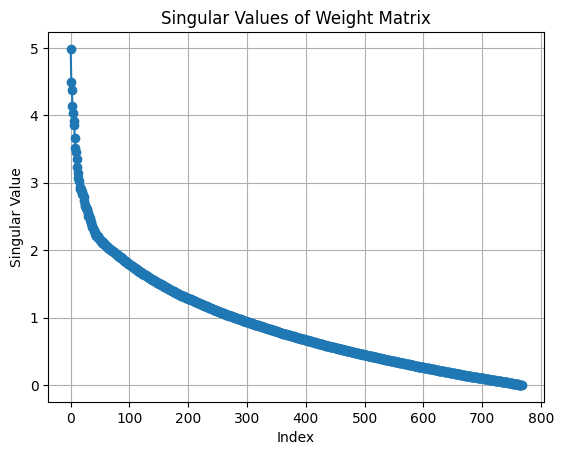

In [90]:
## Identifying the Rank via SVD
import torch
import numpy as np
import matplotlib.pyplot as plt

U, S, Vh = torch.linalg.svd(original_weight, full_matrices=False)

plt.plot(S.numpy(), marker='o')
plt.title("Singular Values of Weight Matrix")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd


ValueError: If using all scalar values, you must pass an index

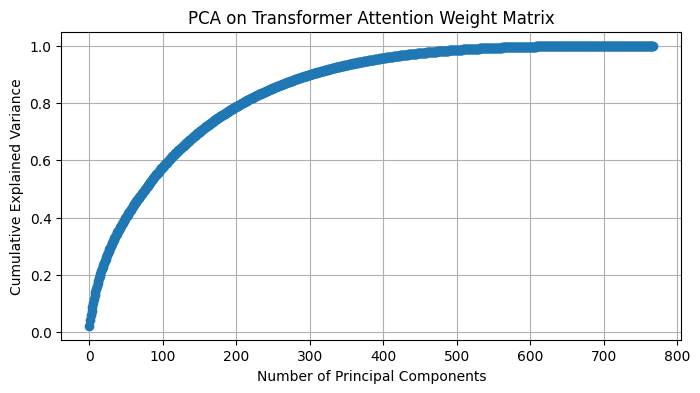

In [48]:
from sklearn.decomposition import PCA

weight_matrix = original_weight.numpy()

pca = PCA(n_components=min(weight_matrix.shape))
pca.fit(weight_matrix)

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Plot
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on Transformer Attention Weight Matrix')
plt.grid(True)
plt.show()

### Understanding the 2 evidence
There is considerable evidence that the weight matrice is of a lower rank due to the way the explained variance exists as a logarithm curve, this suggests that the principal componenets with the largest eigenvalues harbour a significantly higher proportion of the total variance. This means that we can attempt to approximate a intrinsic low rank matrix.

In [49]:
threshold = 1e-3 * S.max()
effective_rank = (S > threshold).sum().item()
print("Effective Rank:", effective_rank)

Effective Rank: 763


In [54]:

def energy_preserving_rank(S: torch.Tensor, threshold: float = 0.7) -> int:
    energy = S**2
    total_energy = energy.sum()
    cumulative_energy = energy.cumsum(dim=0)
    k = (cumulative_energy / total_energy >= threshold).nonzero(as_tuple=True)[0][0].item() + 1
    return k

optimal_rank = energy_preserving_rank(S, threshold=0.7)

print("Optimal Rank:", optimal_rank)

Optimal Rank: 151


## Fine tuning using LORA
Done using the financial phrasebank dataset
Several Limitations to the fine tuning process
1. Run 20 EPOCHS (Reliant on computer GPU)
2. Run a certain set amount of ranks to ascertain the status

In [95]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import torch
import numpy as np
import evaluate
import os

# Load dataset (financial sentiment dataset)
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree")
data = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_data = data["train"]
val_data = data["test"]

# Initialize tokenizer for BERT base model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocessing function
def preprocess(example):
    return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(preprocess, batched=True)
val_data = val_data.map(preprocess, batched=True)

# Prepare label map (string -> int if needed)
unique_labels = set(train_data["label"])
label_map = {label: i for i, label in enumerate(sorted(unique_labels))}
def encode_labels(example):
    return {"label": label_map[example["label"]]}
train_data = train_data.map(encode_labels)
val_data = val_data.map(encode_labels)

# Evaluation metric
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

# Make sure save directory exists
os.makedirs("./saved_lora_weights", exist_ok=True)

# Train with different LoRA ranks
r_values = [2 ** i for i in range(0, 12)]  # 1 to 512
results = {}

for r in r_values:
    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
    
    lora_config = LoraConfig(
        r=r,
        lora_alpha=16,
        target_modules=["query"],
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    
    model = get_peft_model(base_model, lora_config)
    
    training_args = TrainingArguments(
        output_dir=f"./results_lora_r{r}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=20,
        evaluation_strategy="epoch",
        logging_dir=f"./logs_lora_r{r}",
        logging_steps=10,
        save_strategy="no"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    eval_result = trainer.evaluate()
    results[r] = eval_result

    # Save the weights for this model
    model.save_pretrained(f"./saved_lora_weights/lora_rank_{r}")

# Output results
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0099, 'grad_norm': 6.725496768951416, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 0.968, 'grad_norm': 3.588639259338379, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9757, 'grad_norm': 6.807130813598633, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9837, 'grad_norm': 4.269562721252441, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0632, 'grad_norm': 6.283775329589844, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9127, 'grad_norm': 2.052619218826294, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8961, 'grad_norm': 3.3454060554504395, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.9094, 'grad_norm': 2.686275005340576, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.9402, 'grad_norm': 2.161536455154419, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8991, 'grad_norm': 3.1705148220062256, 'learning

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.8434693217277527, 'eval_accuracy': 0.6578366445916115, 'eval_runtime': 2.4929, 'eval_samples_per_second': 181.719, 'eval_steps_per_second': 22.865, 'epoch': 1.0}
{'loss': 0.8023, 'grad_norm': 6.840089797973633, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.8166, 'grad_norm': 6.37538480758667, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9573, 'grad_norm': 5.968976020812988, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.7218, 'grad_norm': 2.7466766834259033, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.7578, 'grad_norm': 2.877964735031128, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.6796, 'grad_norm': 5.071376800537109, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.7734, 'grad_norm': 5.314138412475586, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.6066, 'grad_norm': 5.074712753295898, 'learning_rate': 4.6696035242290756e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5901027321815491, 'eval_accuracy': 0.7350993377483444, 'eval_runtime': 2.4973, 'eval_samples_per_second': 181.395, 'eval_steps_per_second': 22.825, 'epoch': 2.0}
{'loss': 0.6456, 'grad_norm': 12.712506294250488, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.7043, 'grad_norm': 3.578667402267456, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6278, 'grad_norm': 9.268512725830078, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4771, 'grad_norm': 9.65078353881836, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4633, 'grad_norm': 9.804420471191406, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4677, 'grad_norm': 2.900738477706909, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5608, 'grad_norm': 4.857247352600098, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6215, 'grad_norm': 8.26253890991211, 'learning_rate': 4.416299559471366e-05, 'epoch': 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5650886297225952, 'eval_accuracy': 0.7461368653421634, 'eval_runtime': 2.5207, 'eval_samples_per_second': 179.712, 'eval_steps_per_second': 22.613, 'epoch': 3.0}
{'loss': 0.5966, 'grad_norm': 13.545809745788574, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5457, 'grad_norm': 5.170492172241211, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.5274, 'grad_norm': 10.61440658569336, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5329, 'grad_norm': 7.73715877532959, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4518, 'grad_norm': 6.360459327697754, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4622, 'grad_norm': 1.9997186660766602, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4899, 'grad_norm': 2.577491521835327, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6568, 'grad_norm': 5.8362603187561035, 'learning_rate': 4.1629955947136564e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5338301062583923, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 2.5312, 'eval_samples_per_second': 178.963, 'eval_steps_per_second': 22.519, 'epoch': 4.0}
{'loss': 0.4198, 'grad_norm': 4.493602752685547, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3729, 'grad_norm': 6.238892555236816, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3808, 'grad_norm': 7.555726528167725, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.4305, 'grad_norm': 12.291705131530762, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.62, 'grad_norm': 8.428117752075195, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.6529, 'grad_norm': 4.39404296875, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4847, 'grad_norm': 3.743177652359009, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.5248, 'grad_norm': 8.431389808654785, 'learning_rate': 3.920704845814978e-05, 'epoch': 4

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5170536637306213, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.5198, 'eval_samples_per_second': 179.774, 'eval_steps_per_second': 22.621, 'epoch': 5.0}
{'loss': 0.5525, 'grad_norm': 5.921943187713623, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4435, 'grad_norm': 7.351295471191406, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5339, 'grad_norm': 13.907126426696777, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.5023, 'grad_norm': 8.402615547180176, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5824, 'grad_norm': 6.6272101402282715, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.5004, 'grad_norm': 3.6664862632751465, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.4437, 'grad_norm': 1.1889863014221191, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5548, 'grad_norm': 10.028589248657227, 'learning_rate': 3.667400881057269e-05, 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5038563013076782, 'eval_accuracy': 0.7726269315673289, 'eval_runtime': 2.5343, 'eval_samples_per_second': 178.748, 'eval_steps_per_second': 22.491, 'epoch': 6.0}
{'loss': 0.3912, 'grad_norm': 3.545069456100464, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3501, 'grad_norm': 8.940528869628906, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4287, 'grad_norm': 4.0338215827941895, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4637, 'grad_norm': 2.265831470489502, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4423, 'grad_norm': 5.411266803741455, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3979, 'grad_norm': 4.977924346923828, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.3945, 'grad_norm': 15.511234283447266, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3414, 'grad_norm': 2.1459810733795166, 'learning_rate': 3.414096916299559e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4949262738227844, 'eval_accuracy': 0.7682119205298014, 'eval_runtime': 2.5344, 'eval_samples_per_second': 178.74, 'eval_steps_per_second': 22.49, 'epoch': 7.0}
{'loss': 0.3263, 'grad_norm': 3.2571871280670166, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.4012, 'grad_norm': 3.7770650386810303, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3717, 'grad_norm': 2.3282275199890137, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4365, 'grad_norm': 14.01461124420166, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.477, 'grad_norm': 29.204999923706055, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5022, 'grad_norm': 5.117916107177734, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4729, 'grad_norm': 2.390648126602173, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2605, 'grad_norm': 3.5657761096954346, 'learning_rate': 3.171806167400881e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4954642653465271, 'eval_accuracy': 0.7682119205298014, 'eval_runtime': 2.5333, 'eval_samples_per_second': 178.819, 'eval_steps_per_second': 22.5, 'epoch': 8.0}
{'loss': 0.6205, 'grad_norm': 13.264738082885742, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3472, 'grad_norm': 7.592961311340332, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.475, 'grad_norm': 5.577682971954346, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.3498, 'grad_norm': 14.295919418334961, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4136, 'grad_norm': 1.4914124011993408, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4974, 'grad_norm': 5.260472774505615, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3601, 'grad_norm': 20.33892822265625, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.5004, 'grad_norm': 3.0429179668426514, 'learning_rate': 2.918502202643172e-05, 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4841075539588928, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.5364, 'eval_samples_per_second': 178.601, 'eval_steps_per_second': 22.473, 'epoch': 9.0}
{'loss': 0.4827, 'grad_norm': 14.487035751342773, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4965, 'grad_norm': 2.725553274154663, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4676, 'grad_norm': 16.917448043823242, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.384, 'grad_norm': 4.538018226623535, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.37, 'grad_norm': 3.360351800918579, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5482, 'grad_norm': 32.931663513183594, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4818, 'grad_norm': 5.388885498046875, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3624, 'grad_norm': 2.2325713634490967, 'learning_rate': 2.6651982378854628e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4826645255088806, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.5351, 'eval_samples_per_second': 178.688, 'eval_steps_per_second': 22.484, 'epoch': 10.0}
{'loss': 0.3607, 'grad_norm': 20.491186141967773, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4481, 'grad_norm': 22.643875122070312, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.451, 'grad_norm': 8.821429252624512, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3964, 'grad_norm': 2.403573989868164, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4491, 'grad_norm': 15.523175239562988, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.2972, 'grad_norm': 3.1443605422973633, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4788, 'grad_norm': 3.363063335418701, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4884, 'grad_norm': 28.163827896118164, 'learning_rate': 2.4118942731

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46559807658195496, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 2.547, 'eval_samples_per_second': 177.859, 'eval_steps_per_second': 22.38, 'epoch': 11.0}
{'loss': 0.5074, 'grad_norm': 23.48818588256836, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3508, 'grad_norm': 3.883111000061035, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4981, 'grad_norm': 43.240753173828125, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3733, 'grad_norm': 1.8396275043487549, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3999, 'grad_norm': 10.869050025939941, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.4198, 'grad_norm': 24.870798110961914, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3829, 'grad_norm': 2.6619255542755127, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.4211, 'grad_norm': 2.0275425910949707, 'learning_rate': 2.1696035242

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.469071626663208, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 2.5517, 'eval_samples_per_second': 177.528, 'eval_steps_per_second': 22.338, 'epoch': 12.0}
{'loss': 0.3141, 'grad_norm': 15.954671859741211, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.3805, 'grad_norm': 3.687087059020996, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.4089, 'grad_norm': 30.31255531311035, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.3762, 'grad_norm': 3.729508876800537, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.446, 'grad_norm': 14.904863357543945, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.3775, 'grad_norm': 5.209315776824951, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.4289, 'grad_norm': 9.093040466308594, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.464, 'grad_norm': 4.502660751342773, 'learning_rate': 1.9162995594713656e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4638207256793976, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.5463, 'eval_samples_per_second': 177.903, 'eval_steps_per_second': 22.385, 'epoch': 13.0}
{'loss': 0.4174, 'grad_norm': 34.474632263183594, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4344, 'grad_norm': 19.417068481445312, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3729, 'grad_norm': 2.8071060180664062, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3143, 'grad_norm': 22.33547592163086, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2736, 'grad_norm': 4.996194839477539, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.3229, 'grad_norm': 5.2461676597595215, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4331, 'grad_norm': 3.0401148796081543, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.3189, 'grad_norm': 4.96516227722168, 'learning_rate': 1.6629955947

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4505591094493866, 'eval_accuracy': 0.8013245033112583, 'eval_runtime': 2.5519, 'eval_samples_per_second': 177.512, 'eval_steps_per_second': 22.336, 'epoch': 14.0}
{'loss': 0.3554, 'grad_norm': 4.402433395385742, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4197, 'grad_norm': 8.68659496307373, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.448, 'grad_norm': 5.960103511810303, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.4418, 'grad_norm': 3.2496533393859863, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.454, 'grad_norm': 31.923391342163086, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3823, 'grad_norm': 6.923343658447266, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3165, 'grad_norm': 4.478166103363037, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4753, 'grad_norm': 8.733275413513184, 'learning_rate': 1.42070484581497

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4522027373313904, 'eval_accuracy': 0.7902869757174393, 'eval_runtime': 2.5127, 'eval_samples_per_second': 180.284, 'eval_steps_per_second': 22.685, 'epoch': 15.0}
{'loss': 0.417, 'grad_norm': 20.117589950561523, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5961, 'grad_norm': 8.610821723937988, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3515, 'grad_norm': 1.924787998199463, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.414, 'grad_norm': 7.979339122772217, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3004, 'grad_norm': 10.97138786315918, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4492, 'grad_norm': 52.802406311035156, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2722, 'grad_norm': 5.056771278381348, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3581, 'grad_norm': 10.940900802612305, 'learning_rate': 1.1674008810572

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4461360573768616, 'eval_accuracy': 0.7947019867549668, 'eval_runtime': 2.4648, 'eval_samples_per_second': 183.79, 'eval_steps_per_second': 23.126, 'epoch': 16.0}
{'loss': 0.2966, 'grad_norm': 15.9990816116333, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2821, 'grad_norm': 2.151932954788208, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.359, 'grad_norm': 25.4097900390625, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5663, 'grad_norm': 18.055889129638672, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2591, 'grad_norm': 4.828908443450928, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3714, 'grad_norm': 11.796903610229492, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.4518, 'grad_norm': 18.819549560546875, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.358, 'grad_norm': 6.227016925811768, 'learning_rate': 9.140969162995595e-06, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4381150007247925, 'eval_accuracy': 0.8079470198675497, 'eval_runtime': 2.4678, 'eval_samples_per_second': 183.566, 'eval_steps_per_second': 23.098, 'epoch': 17.0}
{'loss': 0.3636, 'grad_norm': 3.834765672683716, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2511, 'grad_norm': 14.514067649841309, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.3636, 'grad_norm': 3.700920581817627, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3523, 'grad_norm': 7.256111145019531, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.4283, 'grad_norm': 38.17229461669922, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.3398, 'grad_norm': 17.447582244873047, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.4149, 'grad_norm': 3.121325731277466, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.3419, 'grad_norm': 2.3725368976593018, 'learning_rate': 6.718061674008811e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4398307800292969, 'eval_accuracy': 0.8057395143487859, 'eval_runtime': 2.4727, 'eval_samples_per_second': 183.201, 'eval_steps_per_second': 23.052, 'epoch': 18.0}
{'loss': 0.3163, 'grad_norm': 12.942635536193848, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2445, 'grad_norm': 2.165133237838745, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.3, 'grad_norm': 3.488624095916748, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4419, 'grad_norm': 4.924818515777588, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2185, 'grad_norm': 4.674060821533203, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.241, 'grad_norm': 7.944144248962402, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4971, 'grad_norm': 28.45231056213379, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4301, 'grad_norm': 17.723310470581055, 'learning_rate': 4.185022026431718e-06

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43924614787101746, 'eval_accuracy': 0.8057395143487859, 'eval_runtime': 2.476, 'eval_samples_per_second': 182.955, 'eval_steps_per_second': 23.021, 'epoch': 19.0}
{'loss': 0.5684, 'grad_norm': 12.018482208251953, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.3029, 'grad_norm': 4.968857288360596, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.385, 'grad_norm': 9.600873947143555, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.3356, 'grad_norm': 2.088444471359253, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3867, 'grad_norm': 8.427128791809082, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4197, 'grad_norm': 15.088268280029297, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.2652, 'grad_norm': 2.7588887214660645, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3918, 'grad_norm': 34.1196174621582, 'learning_rate': 1.65198237885462

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43790340423583984, 'eval_accuracy': 0.8079470198675497, 'eval_runtime': 2.4656, 'eval_samples_per_second': 183.73, 'eval_steps_per_second': 23.118, 'epoch': 20.0}
{'train_runtime': 480.2826, 'train_samples_per_second': 75.414, 'train_steps_per_second': 9.453, 'train_loss': 0.4626779904449564, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.410499572753906, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8971030712127686, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9802, 'grad_norm': 6.211624622344971, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.89982271194458, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.420044898986816, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9151, 'grad_norm': 2.5177106857299805, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8992, 'grad_norm': 3.02531361579895, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8967, 'grad_norm': 2.483029365539551, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8985, 'grad_norm': 2.541187286376953, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8893, 'grad_norm': 3.3421711921691895, 'learning

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.8994879722595215, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.4837, 'eval_samples_per_second': 182.389, 'eval_steps_per_second': 22.95, 'epoch': 1.0}
{'loss': 0.8779, 'grad_norm': 5.837151050567627, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9325, 'grad_norm': 7.110917091369629, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9883, 'grad_norm': 3.825941324234009, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8352, 'grad_norm': 2.9236342906951904, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8305, 'grad_norm': 3.5781819820404053, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7921, 'grad_norm': 4.346169948577881, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.8924, 'grad_norm': 5.3490495681762695, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7787, 'grad_norm': 5.4271697998046875, 'learning_rate': 4.6696035242290756e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.618341863155365, 'eval_accuracy': 0.7086092715231788, 'eval_runtime': 2.4724, 'eval_samples_per_second': 183.226, 'eval_steps_per_second': 23.055, 'epoch': 2.0}
{'loss': 0.679, 'grad_norm': 12.057913780212402, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.7102, 'grad_norm': 2.5056097507476807, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6987, 'grad_norm': 5.338901996612549, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.5089, 'grad_norm': 5.735403537750244, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4901, 'grad_norm': 8.900985717773438, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4773, 'grad_norm': 2.811220169067383, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5886, 'grad_norm': 5.29792594909668, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6635, 'grad_norm': 6.783533096313477, 'learning_rate': 4.416299559471366e-05, 'epoch': 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5690329074859619, 'eval_accuracy': 0.7417218543046358, 'eval_runtime': 2.4748, 'eval_samples_per_second': 183.044, 'eval_steps_per_second': 23.032, 'epoch': 3.0}
{'loss': 0.5472, 'grad_norm': 9.824682235717773, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5342, 'grad_norm': 8.93165111541748, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.5075, 'grad_norm': 10.528976440429688, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5384, 'grad_norm': 4.890629768371582, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4447, 'grad_norm': 2.7809789180755615, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.5226, 'grad_norm': 1.8965657949447632, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4994, 'grad_norm': 2.5196008682250977, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6331, 'grad_norm': 4.924400806427002, 'learning_rate': 4.1629955947136564e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5357282757759094, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 2.4782, 'eval_samples_per_second': 182.795, 'eval_steps_per_second': 23.001, 'epoch': 4.0}
{'loss': 0.4571, 'grad_norm': 4.7700581550598145, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3957, 'grad_norm': 5.106361389160156, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.4101, 'grad_norm': 6.12916374206543, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.4146, 'grad_norm': 14.276505470275879, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6688, 'grad_norm': 5.088998794555664, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5868, 'grad_norm': 13.470626831054688, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.496, 'grad_norm': 3.7767648696899414, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.503, 'grad_norm': 6.679654121398926, 'learning_rate': 3.920704845814978e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5171957015991211, 'eval_accuracy': 0.7505518763796909, 'eval_runtime': 2.4751, 'eval_samples_per_second': 183.019, 'eval_steps_per_second': 23.029, 'epoch': 5.0}
{'loss': 0.5508, 'grad_norm': 4.405446529388428, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4826, 'grad_norm': 12.493927955627441, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5685, 'grad_norm': 13.96501350402832, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.5141, 'grad_norm': 14.850454330444336, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5715, 'grad_norm': 4.041717052459717, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.5029, 'grad_norm': 7.285149574279785, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3953, 'grad_norm': 1.2362688779830933, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5697, 'grad_norm': 22.678808212280273, 'learning_rate': 3.667400881057269e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4995104670524597, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.4828, 'eval_samples_per_second': 182.454, 'eval_steps_per_second': 22.958, 'epoch': 6.0}
{'loss': 0.3904, 'grad_norm': 2.8405473232269287, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3511, 'grad_norm': 9.149558067321777, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.418, 'grad_norm': 4.535212516784668, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.5066, 'grad_norm': 1.746777057647705, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4526, 'grad_norm': 3.7170939445495605, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3764, 'grad_norm': 6.1395087242126465, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4241, 'grad_norm': 2.2489371299743652, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3312, 'grad_norm': 3.7417330741882324, 'learning_rate': 3.414096916299559e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4945877492427826, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.4773, 'eval_samples_per_second': 182.863, 'eval_steps_per_second': 23.009, 'epoch': 7.0}
{'loss': 0.3516, 'grad_norm': 7.015444278717041, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.4157, 'grad_norm': 5.218563079833984, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3925, 'grad_norm': 1.8594900369644165, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.499, 'grad_norm': 23.08720588684082, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4235, 'grad_norm': 15.063763618469238, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5532, 'grad_norm': 5.0256876945495605, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.5222, 'grad_norm': 1.8275697231292725, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.3251, 'grad_norm': 2.7877087593078613, 'learning_rate': 3.171806167400881e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.48879125714302063, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.4743, 'eval_samples_per_second': 183.081, 'eval_steps_per_second': 23.037, 'epoch': 8.0}
{'loss': 0.5229, 'grad_norm': 7.767087459564209, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3423, 'grad_norm': 6.714223861694336, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5676, 'grad_norm': 5.468376636505127, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.4055, 'grad_norm': 15.052101135253906, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.443, 'grad_norm': 1.295795202255249, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.5208, 'grad_norm': 3.758153200149536, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3316, 'grad_norm': 18.583261489868164, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.5275, 'grad_norm': 8.609688758850098, 'learning_rate': 2.918502202643172e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4833366274833679, 'eval_accuracy': 0.7682119205298014, 'eval_runtime': 2.4764, 'eval_samples_per_second': 182.927, 'eval_steps_per_second': 23.017, 'epoch': 9.0}
{'loss': 0.5354, 'grad_norm': 6.518644332885742, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.5013, 'grad_norm': 2.4751646518707275, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4163, 'grad_norm': 10.419086456298828, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3689, 'grad_norm': 7.575997352600098, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3997, 'grad_norm': 20.94197654724121, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5568, 'grad_norm': 2.55311918258667, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.438, 'grad_norm': 4.386247634887695, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.4098, 'grad_norm': 2.7349801063537598, 'learning_rate': 2.6651982378854628e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.48060840368270874, 'eval_accuracy': 0.7682119205298014, 'eval_runtime': 2.4823, 'eval_samples_per_second': 182.492, 'eval_steps_per_second': 22.963, 'epoch': 10.0}
{'loss': 0.3784, 'grad_norm': 13.473225593566895, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.5108, 'grad_norm': 5.401019096374512, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4135, 'grad_norm': 11.75739574432373, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.4391, 'grad_norm': 10.589518547058105, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4165, 'grad_norm': 20.39713478088379, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3855, 'grad_norm': 2.9710006713867188, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4648, 'grad_norm': 2.4843790531158447, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4777, 'grad_norm': 13.126509666442871, 'learning_rate': 2.41189427

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46704748272895813, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.4744, 'eval_samples_per_second': 183.073, 'eval_steps_per_second': 23.036, 'epoch': 11.0}
{'loss': 0.4747, 'grad_norm': 17.041330337524414, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3502, 'grad_norm': 11.054686546325684, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.5232, 'grad_norm': 17.273408889770508, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3485, 'grad_norm': 1.3926893472671509, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.4143, 'grad_norm': 10.550575256347656, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3674, 'grad_norm': 14.83888053894043, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.4431, 'grad_norm': 2.3310179710388184, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3969, 'grad_norm': 2.961656332015991, 'learning_rate': 2.16960352

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46407729387283325, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.4636, 'eval_samples_per_second': 183.88, 'eval_steps_per_second': 23.137, 'epoch': 12.0}
{'loss': 0.3812, 'grad_norm': 18.205791473388672, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4451, 'grad_norm': 2.324896812438965, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.4289, 'grad_norm': 16.819408416748047, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4976, 'grad_norm': 18.590463638305664, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4216, 'grad_norm': 22.805837631225586, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4772, 'grad_norm': 22.191360473632812, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.4036, 'grad_norm': 12.277966499328613, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4968, 'grad_norm': 2.553208827972412, 'learning_rate': 1.9162995594

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4599591791629791, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.4775, 'eval_samples_per_second': 182.843, 'eval_steps_per_second': 23.007, 'epoch': 13.0}
{'loss': 0.4318, 'grad_norm': 15.729372024536133, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4344, 'grad_norm': 3.7759640216827393, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.2963, 'grad_norm': 2.6886513233184814, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3872, 'grad_norm': 16.058279037475586, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.3085, 'grad_norm': 4.287818908691406, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.3231, 'grad_norm': 4.081655025482178, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4147, 'grad_norm': 4.804427146911621, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.3382, 'grad_norm': 23.074474334716797, 'learning_rate': 1.662995594

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4536512792110443, 'eval_accuracy': 0.7704194260485652, 'eval_runtime': 2.4756, 'eval_samples_per_second': 182.988, 'eval_steps_per_second': 23.025, 'epoch': 14.0}
{'loss': 0.4632, 'grad_norm': 13.884322166442871, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4015, 'grad_norm': 6.702787399291992, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4249, 'grad_norm': 3.249113082885742, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5833, 'grad_norm': 2.998297929763794, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.4637, 'grad_norm': 16.93805694580078, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.4338, 'grad_norm': 15.329347610473633, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3482, 'grad_norm': 4.34171724319458, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4841, 'grad_norm': 27.110980987548828, 'learning_rate': 1.42070484581

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46121111512184143, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.4641, 'eval_samples_per_second': 183.843, 'eval_steps_per_second': 23.133, 'epoch': 15.0}
{'loss': 0.3083, 'grad_norm': 20.338542938232422, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5374, 'grad_norm': 1.984587550163269, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3414, 'grad_norm': 7.102433681488037, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4662, 'grad_norm': 3.9875035285949707, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3874, 'grad_norm': 10.189963340759277, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4753, 'grad_norm': 16.852283477783203, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.254, 'grad_norm': 21.894678115844727, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3652, 'grad_norm': 17.622114181518555, 'learning_rate': 1.16740088

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4558597803115845, 'eval_accuracy': 0.7726269315673289, 'eval_runtime': 2.4815, 'eval_samples_per_second': 182.552, 'eval_steps_per_second': 22.97, 'epoch': 16.0}
{'loss': 0.4206, 'grad_norm': 27.6660213470459, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.268, 'grad_norm': 1.6529479026794434, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3559, 'grad_norm': 9.474381446838379, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5485, 'grad_norm': 39.131038665771484, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2602, 'grad_norm': 2.6042158603668213, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3216, 'grad_norm': 8.052672386169434, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.4486, 'grad_norm': 2.6438491344451904, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.463, 'grad_norm': 3.9267711639404297, 'learning_rate': 9.140969162995595e-06

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4491416811943054, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.4737, 'eval_samples_per_second': 183.129, 'eval_steps_per_second': 23.043, 'epoch': 17.0}
{'loss': 0.4292, 'grad_norm': 1.8521419763565063, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2979, 'grad_norm': 5.93674898147583, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4737, 'grad_norm': 3.8438875675201416, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.4062, 'grad_norm': 10.368605613708496, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.4432, 'grad_norm': 50.01372528076172, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.5225, 'grad_norm': 13.602028846740723, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.4181, 'grad_norm': 2.807352304458618, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.3266, 'grad_norm': 12.587092399597168, 'learning_rate': 6.718061674008811

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4524175524711609, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.4792, 'eval_samples_per_second': 182.722, 'eval_steps_per_second': 22.992, 'epoch': 18.0}
{'loss': 0.3282, 'grad_norm': 13.406168937683105, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2566, 'grad_norm': 1.74333655834198, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2672, 'grad_norm': 2.022186517715454, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4842, 'grad_norm': 4.71328067779541, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2251, 'grad_norm': 2.7916252613067627, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3728, 'grad_norm': 17.657255172729492, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.5523, 'grad_norm': 9.326757431030273, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4263, 'grad_norm': 33.55105972290039, 'learning_rate': 4.185022026431718e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4532175064086914, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.46, 'eval_samples_per_second': 184.148, 'eval_steps_per_second': 23.171, 'epoch': 19.0}
{'loss': 0.544, 'grad_norm': 9.565496444702148, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2986, 'grad_norm': 22.400014877319336, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3349, 'grad_norm': 24.455516815185547, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.3234, 'grad_norm': 2.2816741466522217, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.4327, 'grad_norm': 8.241018295288086, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4515, 'grad_norm': 25.339561462402344, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3357, 'grad_norm': 1.5586220026016235, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3404, 'grad_norm': 21.466224670410156, 'learning_rate': 1.651982378854

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.451810359954834, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.4643, 'eval_samples_per_second': 183.825, 'eval_steps_per_second': 23.13, 'epoch': 20.0}
{'train_runtime': 473.6049, 'train_samples_per_second': 76.477, 'train_steps_per_second': 9.586, 'train_loss': 0.47931071052467245, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.410989284515381, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8943049907684326, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9801, 'grad_norm': 6.211937427520752, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9646, 'grad_norm': 4.899792671203613, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0423, 'grad_norm': 5.420718669891357, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9153, 'grad_norm': 2.517683506011963, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.899, 'grad_norm': 3.0205090045928955, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8962, 'grad_norm': 2.5074691772460938, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8983, 'grad_norm': 2.5294272899627686, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8889, 'grad_norm': 3.3273556232452393, 'learn

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.8980411291122437, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 251.507, 'eval_samples_per_second': 1.801, 'eval_steps_per_second': 0.227, 'epoch': 1.0}
{'loss': 0.8771, 'grad_norm': 5.794205188751221, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9291, 'grad_norm': 6.884124755859375, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9905, 'grad_norm': 3.777949810028076, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8312, 'grad_norm': 2.811818838119507, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8354, 'grad_norm': 3.4253783226013184, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7865, 'grad_norm': 4.281566619873047, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.8954, 'grad_norm': 6.036061763763428, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7611, 'grad_norm': 4.488158702850342, 'learning_rate': 4.6696035242290756e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5942373275756836, 'eval_accuracy': 0.739514348785872, 'eval_runtime': 2.5227, 'eval_samples_per_second': 179.573, 'eval_steps_per_second': 22.595, 'epoch': 2.0}
{'loss': 0.6406, 'grad_norm': 11.64400863647461, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6851, 'grad_norm': 2.3043136596679688, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6585, 'grad_norm': 5.5593695640563965, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4707, 'grad_norm': 3.2134978771209717, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4619, 'grad_norm': 6.608305931091309, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4555, 'grad_norm': 2.72603440284729, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5739, 'grad_norm': 4.211363315582275, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6401, 'grad_norm': 6.082489013671875, 'learning_rate': 4.416299559471366e-05, 'epoch'

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.545009195804596, 'eval_accuracy': 0.7505518763796909, 'eval_runtime': 2.5262, 'eval_samples_per_second': 179.32, 'eval_steps_per_second': 22.563, 'epoch': 3.0}
{'loss': 0.506, 'grad_norm': 5.4783430099487305, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5345, 'grad_norm': 6.882957935333252, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4725, 'grad_norm': 9.955435752868652, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.512, 'grad_norm': 4.989264965057373, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4455, 'grad_norm': 5.315852165222168, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4982, 'grad_norm': 1.836893916130066, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4553, 'grad_norm': 2.387524127960205, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.622, 'grad_norm': 4.68017053604126, 'learning_rate': 4.1629955947136564e-05, 'epoch': 3

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5087075233459473, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.4708, 'eval_samples_per_second': 183.339, 'eval_steps_per_second': 23.069, 'epoch': 4.0}
{'loss': 0.401, 'grad_norm': 4.719997406005859, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3521, 'grad_norm': 4.48407506942749, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3773, 'grad_norm': 4.4499359130859375, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.4037, 'grad_norm': 10.522892951965332, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6601, 'grad_norm': 4.306958198547363, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5864, 'grad_norm': 3.555420160293579, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4821, 'grad_norm': 3.610643148422241, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.481, 'grad_norm': 5.806966781616211, 'learning_rate': 3.920704845814978e-05, 'epoch

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.48748916387557983, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.4793, 'eval_samples_per_second': 182.713, 'eval_steps_per_second': 22.99, 'epoch': 5.0}
{'loss': 0.5436, 'grad_norm': 3.515915870666504, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.445, 'grad_norm': 10.018218040466309, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.524, 'grad_norm': 8.955090522766113, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4649, 'grad_norm': 6.763878345489502, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5519, 'grad_norm': 2.7296273708343506, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.5162, 'grad_norm': 2.6566367149353027, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3893, 'grad_norm': 1.1028178930282593, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5383, 'grad_norm': 10.128090858459473, 'learning_rate': 3.667400881057269e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4657411277294159, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.4882, 'eval_samples_per_second': 182.062, 'eval_steps_per_second': 22.908, 'epoch': 6.0}
{'loss': 0.3741, 'grad_norm': 3.272226333618164, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3223, 'grad_norm': 7.777327537536621, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4104, 'grad_norm': 3.7069051265716553, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4683, 'grad_norm': 1.880791187286377, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4342, 'grad_norm': 4.48773717880249, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3588, 'grad_norm': 4.544137954711914, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4188, 'grad_norm': 2.207653045654297, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3099, 'grad_norm': 1.6996023654937744, 'learning_rate': 3.414096916299559e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.459952712059021, 'eval_accuracy': 0.7682119205298014, 'eval_runtime': 2.4881, 'eval_samples_per_second': 182.068, 'eval_steps_per_second': 22.909, 'epoch': 7.0}
{'loss': 0.335, 'grad_norm': 7.036248207092285, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3974, 'grad_norm': 2.7641918659210205, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3526, 'grad_norm': 2.028977870941162, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4543, 'grad_norm': 4.942763805389404, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4527, 'grad_norm': 9.109733581542969, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5105, 'grad_norm': 4.209618091583252, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4759, 'grad_norm': 2.1414053440093994, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2958, 'grad_norm': 1.9591715335845947, 'learning_rate': 3.171806167400881e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4454902708530426, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.5033, 'eval_samples_per_second': 180.963, 'eval_steps_per_second': 22.77, 'epoch': 8.0}
{'loss': 0.4849, 'grad_norm': 14.856935501098633, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3167, 'grad_norm': 6.600833892822266, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5097, 'grad_norm': 4.357463359832764, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.3699, 'grad_norm': 10.558927536010742, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4141, 'grad_norm': 1.3436923027038574, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4729, 'grad_norm': 4.244048118591309, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3351, 'grad_norm': 12.504648208618164, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4512, 'grad_norm': 1.8809092044830322, 'learning_rate': 2.918502202643172e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4455564618110657, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.4842, 'eval_samples_per_second': 182.355, 'eval_steps_per_second': 22.945, 'epoch': 9.0}
{'loss': 0.4562, 'grad_norm': 7.412119388580322, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4136, 'grad_norm': 2.4228267669677734, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4359, 'grad_norm': 9.371341705322266, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.327, 'grad_norm': 3.88946533203125, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3401, 'grad_norm': 3.615386962890625, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5489, 'grad_norm': 7.326862335205078, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4323, 'grad_norm': 4.284468173980713, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3713, 'grad_norm': 2.5996038913726807, 'learning_rate': 2.6651982378854628e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.44104012846946716, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.4909, 'eval_samples_per_second': 181.86, 'eval_steps_per_second': 22.883, 'epoch': 10.0}
{'loss': 0.3741, 'grad_norm': 14.284330368041992, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4198, 'grad_norm': 6.718166828155518, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4498, 'grad_norm': 9.812280654907227, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3729, 'grad_norm': 1.5589361190795898, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4414, 'grad_norm': 12.119622230529785, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3651, 'grad_norm': 3.4191815853118896, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4441, 'grad_norm': 2.319521903991699, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4529, 'grad_norm': 12.25351333618164, 'learning_rate': 2.4118942731

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4266884922981262, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 2.5061, 'eval_samples_per_second': 180.76, 'eval_steps_per_second': 22.745, 'epoch': 11.0}
{'loss': 0.4082, 'grad_norm': 14.705684661865234, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3313, 'grad_norm': 2.0207152366638184, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.5109, 'grad_norm': 17.18393325805664, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.2805, 'grad_norm': 1.4080160856246948, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3775, 'grad_norm': 8.01414966583252, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3897, 'grad_norm': 6.59978723526001, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.4078, 'grad_norm': 1.7615125179290771, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3505, 'grad_norm': 1.8422231674194336, 'learning_rate': 2.1696035242290

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43066635727882385, 'eval_accuracy': 0.7924944812362031, 'eval_runtime': 2.4932, 'eval_samples_per_second': 181.692, 'eval_steps_per_second': 22.862, 'epoch': 12.0}
{'loss': 0.3332, 'grad_norm': 10.668272972106934, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4041, 'grad_norm': 1.9024442434310913, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3463, 'grad_norm': 30.466445922851562, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.437, 'grad_norm': 1.6464334726333618, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4316, 'grad_norm': 26.90143394470215, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4032, 'grad_norm': 14.723578453063965, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3889, 'grad_norm': 10.177489280700684, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4836, 'grad_norm': 2.0102274417877197, 'learning_rate': 1.916299559

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4286889433860779, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 2.6568, 'eval_samples_per_second': 170.503, 'eval_steps_per_second': 21.454, 'epoch': 13.0}
{'loss': 0.3501, 'grad_norm': 16.062847137451172, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4007, 'grad_norm': 12.837042808532715, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3627, 'grad_norm': 2.758051633834839, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3451, 'grad_norm': 16.47303009033203, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2776, 'grad_norm': 4.267486095428467, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2597, 'grad_norm': 3.774442434310913, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4178, 'grad_norm': 5.7841949462890625, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.2995, 'grad_norm': 3.5712759494781494, 'learning_rate': 1.6629955947

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41857168078422546, 'eval_accuracy': 0.8013245033112583, 'eval_runtime': 2.6094, 'eval_samples_per_second': 173.606, 'eval_steps_per_second': 21.845, 'epoch': 14.0}
{'loss': 0.3438, 'grad_norm': 3.9854767322540283, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4227, 'grad_norm': 7.316272735595703, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.3957, 'grad_norm': 3.2393929958343506, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5455, 'grad_norm': 2.86867094039917, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.4456, 'grad_norm': 11.079147338867188, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3981, 'grad_norm': 4.919962406158447, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3183, 'grad_norm': 4.2235331535339355, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.465, 'grad_norm': 6.035270690917969, 'learning_rate': 1.4207048458

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4213627278804779, 'eval_accuracy': 0.8013245033112583, 'eval_runtime': 2.6194, 'eval_samples_per_second': 172.943, 'eval_steps_per_second': 21.761, 'epoch': 15.0}
{'loss': 0.2589, 'grad_norm': 6.796478271484375, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5312, 'grad_norm': 2.2706329822540283, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.269, 'grad_norm': 1.6540329456329346, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.3898, 'grad_norm': 2.554988384246826, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3688, 'grad_norm': 7.858878135681152, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.3821, 'grad_norm': 6.3948893547058105, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2282, 'grad_norm': 2.2735326290130615, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3284, 'grad_norm': 11.962748527526855, 'learning_rate': 1.1674008810

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41495418548583984, 'eval_accuracy': 0.8079470198675497, 'eval_runtime': 2.5648, 'eval_samples_per_second': 176.622, 'eval_steps_per_second': 22.224, 'epoch': 16.0}
{'loss': 0.3354, 'grad_norm': 22.720674514770508, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2545, 'grad_norm': 1.7867262363433838, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3159, 'grad_norm': 5.589066982269287, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5193, 'grad_norm': 15.949617385864258, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2707, 'grad_norm': 2.568596839904785, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.2895, 'grad_norm': 8.303686141967773, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.4037, 'grad_norm': 1.6305432319641113, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4103, 'grad_norm': 3.3254544734954834, 'learning_rate': 9.14096916299559

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40586957335472107, 'eval_accuracy': 0.8035320088300221, 'eval_runtime': 2.555, 'eval_samples_per_second': 177.302, 'eval_steps_per_second': 22.31, 'epoch': 17.0}
{'loss': 0.4219, 'grad_norm': 1.9225728511810303, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2402, 'grad_norm': 2.5418765544891357, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4496, 'grad_norm': 3.000922918319702, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3316, 'grad_norm': 2.4189391136169434, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3721, 'grad_norm': 27.579633712768555, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4048, 'grad_norm': 1.9290521144866943, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3807, 'grad_norm': 2.9582812786102295, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2702, 'grad_norm': 3.6063075065612793, 'learning_rate': 6.7180616740088

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4104587435722351, 'eval_accuracy': 0.8145695364238411, 'eval_runtime': 2.5525, 'eval_samples_per_second': 177.474, 'eval_steps_per_second': 22.331, 'epoch': 18.0}
{'loss': 0.2995, 'grad_norm': 15.425983428955078, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2194, 'grad_norm': 0.9603271484375, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2484, 'grad_norm': 2.334712505340576, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4403, 'grad_norm': 4.751221179962158, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2137, 'grad_norm': 2.997722625732422, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.31, 'grad_norm': 12.466038703918457, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.5011, 'grad_norm': 6.094272613525391, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.424, 'grad_norm': 23.232309341430664, 'learning_rate': 4.185022026431718e-06

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4106530249118805, 'eval_accuracy': 0.8123620309050773, 'eval_runtime': 2.5542, 'eval_samples_per_second': 177.352, 'eval_steps_per_second': 22.316, 'epoch': 19.0}
{'loss': 0.4953, 'grad_norm': 16.42690658569336, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2726, 'grad_norm': 13.539388656616211, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3261, 'grad_norm': 9.58764934539795, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2566, 'grad_norm': 2.106933832168579, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3846, 'grad_norm': 6.538078784942627, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4182, 'grad_norm': 3.762089490890503, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3157, 'grad_norm': 1.4515677690505981, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3422, 'grad_norm': 16.308271408081055, 'learning_rate': 1.6519823788546

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40915384888648987, 'eval_accuracy': 0.8123620309050773, 'eval_runtime': 2.574, 'eval_samples_per_second': 175.993, 'eval_steps_per_second': 22.145, 'epoch': 20.0}
{'train_runtime': 737.0096, 'train_samples_per_second': 49.145, 'train_steps_per_second': 6.16, 'train_loss': 0.44839214517156456, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ca103a40-0905-4763-8e2a-ffab5a544bd0)') - silently ignoring the lookup for the file config.json in bert-base-uncased.
  warnings.warn(
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in bert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resum

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.410364627838135, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8933537006378174, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9801, 'grad_norm': 6.2058424949646, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.897216796875, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.4164652824401855, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9151, 'grad_norm': 2.5161023139953613, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.899, 'grad_norm': 3.017888069152832, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8962, 'grad_norm': 2.5115036964416504, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8985, 'grad_norm': 2.5268607139587402, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8891, 'grad_norm': 3.327343702316284, 'learning_r

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.8971956968307495, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.56, 'eval_samples_per_second': 176.955, 'eval_steps_per_second': 22.266, 'epoch': 1.0}
{'loss': 0.8741, 'grad_norm': 5.657756328582764, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9281, 'grad_norm': 6.735806465148926, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9863, 'grad_norm': 3.4708261489868164, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8294, 'grad_norm': 2.8097362518310547, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8293, 'grad_norm': 3.375114679336548, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.786, 'grad_norm': 4.206525802612305, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.8872, 'grad_norm': 6.019975662231445, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7573, 'grad_norm': 4.351747512817383, 'learning_rate': 4.6696035242290756e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6055991053581238, 'eval_accuracy': 0.7262693156732892, 'eval_runtime': 2.5566, 'eval_samples_per_second': 177.186, 'eval_steps_per_second': 22.295, 'epoch': 2.0}
{'loss': 0.6456, 'grad_norm': 5.740479469299316, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6936, 'grad_norm': 2.2483205795288086, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6809, 'grad_norm': 3.8117575645446777, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4776, 'grad_norm': 3.0039501190185547, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4684, 'grad_norm': 6.420947551727295, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4471, 'grad_norm': 2.450146436691284, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5772, 'grad_norm': 3.5041325092315674, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6491, 'grad_norm': 4.897819995880127, 'learning_rate': 4.416299559471366e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5597705245018005, 'eval_accuracy': 0.7461368653421634, 'eval_runtime': 2.567, 'eval_samples_per_second': 176.467, 'eval_steps_per_second': 22.205, 'epoch': 3.0}
{'loss': 0.5357, 'grad_norm': 4.405722618103027, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.535, 'grad_norm': 4.834449768066406, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4934, 'grad_norm': 9.31555461883545, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5253, 'grad_norm': 5.051928997039795, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4319, 'grad_norm': 2.1925759315490723, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.502, 'grad_norm': 1.8176053762435913, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4579, 'grad_norm': 2.2494425773620605, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6287, 'grad_norm': 4.278444290161133, 'learning_rate': 4.1629955947136564e-05, 'epoch

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5185124278068542, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 2.5603, 'eval_samples_per_second': 176.935, 'eval_steps_per_second': 22.263, 'epoch': 4.0}
{'loss': 0.3995, 'grad_norm': 4.7014899253845215, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3553, 'grad_norm': 4.0859599113464355, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3844, 'grad_norm': 4.278280735015869, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3989, 'grad_norm': 6.995711326599121, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6653, 'grad_norm': 3.395709276199341, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5781, 'grad_norm': 4.279083728790283, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.474, 'grad_norm': 3.5828359127044678, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4525, 'grad_norm': 5.141543865203857, 'learning_rate': 3.920704845814978e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4977458715438843, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.836, 'eval_samples_per_second': 159.733, 'eval_steps_per_second': 20.099, 'epoch': 5.0}
{'loss': 0.5441, 'grad_norm': 2.6377906799316406, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4447, 'grad_norm': 8.518204689025879, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5266, 'grad_norm': 6.568024635314941, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4509, 'grad_norm': 5.085811138153076, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5543, 'grad_norm': 2.3560309410095215, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4975, 'grad_norm': 2.740295886993408, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3972, 'grad_norm': 0.976790726184845, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5431, 'grad_norm': 7.304897785186768, 'learning_rate': 3.667400881057269e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.47677916288375854, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.5654, 'eval_samples_per_second': 176.58, 'eval_steps_per_second': 22.219, 'epoch': 6.0}
{'loss': 0.3679, 'grad_norm': 3.09175705909729, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3336, 'grad_norm': 4.059324741363525, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4093, 'grad_norm': 3.722738027572632, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4648, 'grad_norm': 1.534271001815796, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4251, 'grad_norm': 3.807589530944824, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3538, 'grad_norm': 4.504240989685059, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.407, 'grad_norm': 2.1346116065979004, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3105, 'grad_norm': 1.7366886138916016, 'learning_rate': 3.414096916299559e-05, 'epoch

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4716687798500061, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 2.5666, 'eval_samples_per_second': 176.5, 'eval_steps_per_second': 22.209, 'epoch': 7.0}
{'loss': 0.3158, 'grad_norm': 3.9546170234680176, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3987, 'grad_norm': 3.98179292678833, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3512, 'grad_norm': 1.958200216293335, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4636, 'grad_norm': 9.933663368225098, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4446, 'grad_norm': 7.309589385986328, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5252, 'grad_norm': 3.129262924194336, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4492, 'grad_norm': 1.728860855102539, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.298, 'grad_norm': 1.8688805103302002, 'learning_rate': 3.171806167400881e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.458836168050766, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.563, 'eval_samples_per_second': 176.745, 'eval_steps_per_second': 22.239, 'epoch': 8.0}
{'loss': 0.492, 'grad_norm': 4.425500869750977, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3421, 'grad_norm': 6.612461090087891, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5098, 'grad_norm': 3.4941911697387695, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.378, 'grad_norm': 14.07083511352539, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4012, 'grad_norm': 1.3535374402999878, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4773, 'grad_norm': 4.166050434112549, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3232, 'grad_norm': 8.28695297241211, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4754, 'grad_norm': 1.9396440982818604, 'learning_rate': 2.918502202643172e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4532977342605591, 'eval_accuracy': 0.7726269315673289, 'eval_runtime': 2.5734, 'eval_samples_per_second': 176.029, 'eval_steps_per_second': 22.149, 'epoch': 9.0}
{'loss': 0.4608, 'grad_norm': 5.288973331451416, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4556, 'grad_norm': 2.3612143993377686, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4178, 'grad_norm': 5.365815162658691, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3361, 'grad_norm': 5.003750324249268, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3421, 'grad_norm': 7.794875144958496, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5429, 'grad_norm': 3.7310051918029785, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4031, 'grad_norm': 4.174352645874023, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3985, 'grad_norm': 2.527482032775879, 'learning_rate': 2.6651982378854628e-05, 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4465251863002777, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.5691, 'eval_samples_per_second': 176.327, 'eval_steps_per_second': 22.187, 'epoch': 10.0}
{'loss': 0.3832, 'grad_norm': 9.449440002441406, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4175, 'grad_norm': 4.918856143951416, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4176, 'grad_norm': 7.550519943237305, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3773, 'grad_norm': 1.4298512935638428, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4069, 'grad_norm': 7.385758876800537, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3586, 'grad_norm': 2.7515361309051514, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4391, 'grad_norm': 2.4398999214172363, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4533, 'grad_norm': 7.612844944000244, 'learning_rate': 2.41189427312

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43545082211494446, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.5673, 'eval_samples_per_second': 176.452, 'eval_steps_per_second': 22.203, 'epoch': 11.0}
{'loss': 0.3931, 'grad_norm': 9.133283615112305, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3264, 'grad_norm': 1.8664826154708862, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4823, 'grad_norm': 10.819140434265137, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.2961, 'grad_norm': 1.33540678024292, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3691, 'grad_norm': 6.702478408813477, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3773, 'grad_norm': 9.106526374816895, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.4118, 'grad_norm': 1.6764018535614014, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3549, 'grad_norm': 1.6255526542663574, 'learning_rate': 2.16960352422

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4330785572528839, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.5623, 'eval_samples_per_second': 176.791, 'eval_steps_per_second': 22.245, 'epoch': 12.0}
{'loss': 0.3128, 'grad_norm': 2.8170998096466064, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4115, 'grad_norm': 1.9127782583236694, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3684, 'grad_norm': 10.654282569885254, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.431, 'grad_norm': 1.4551013708114624, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4129, 'grad_norm': 14.02234935760498, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4481, 'grad_norm': 13.871373176574707, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3683, 'grad_norm': 8.71794319152832, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4346, 'grad_norm': 1.6535993814468384, 'learning_rate': 1.916299559471

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4307134449481964, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.5762, 'eval_samples_per_second': 175.838, 'eval_steps_per_second': 22.125, 'epoch': 13.0}
{'loss': 0.38, 'grad_norm': 8.120343208312988, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.3886, 'grad_norm': 3.1998300552368164, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3337, 'grad_norm': 2.692981719970703, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3627, 'grad_norm': 8.50998592376709, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2904, 'grad_norm': 4.282191753387451, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.272, 'grad_norm': 3.6918108463287354, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4333, 'grad_norm': 3.622619867324829, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.3013, 'grad_norm': 3.448620319366455, 'learning_rate': 1.6629955947136563

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4218592941761017, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 2.5582, 'eval_samples_per_second': 177.075, 'eval_steps_per_second': 22.281, 'epoch': 14.0}
{'loss': 0.3718, 'grad_norm': 2.2384307384490967, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4213, 'grad_norm': 6.850175857543945, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4153, 'grad_norm': 3.3437883853912354, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5508, 'grad_norm': 2.9696285724639893, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.4203, 'grad_norm': 9.25654125213623, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3388, 'grad_norm': 2.1661691665649414, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3088, 'grad_norm': 4.352723598480225, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4477, 'grad_norm': 4.157687187194824, 'learning_rate': 1.4207048458

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4279511570930481, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.5633, 'eval_samples_per_second': 176.728, 'eval_steps_per_second': 22.237, 'epoch': 15.0}
{'loss': 0.2355, 'grad_norm': 5.5939555168151855, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5226, 'grad_norm': 2.05133318901062, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.2997, 'grad_norm': 1.9834319353103638, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4182, 'grad_norm': 5.253119468688965, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3847, 'grad_norm': 5.663839817047119, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4237, 'grad_norm': 5.05600643157959, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2351, 'grad_norm': 1.988142490386963, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.343, 'grad_norm': 5.102970600128174, 'learning_rate': 1.167400881057268

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4216461479663849, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 2.5717, 'eval_samples_per_second': 176.15, 'eval_steps_per_second': 22.165, 'epoch': 16.0}
{'loss': 0.3483, 'grad_norm': 15.18919563293457, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2753, 'grad_norm': 1.346571683883667, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3246, 'grad_norm': 3.7960939407348633, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5041, 'grad_norm': 9.414782524108887, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2571, 'grad_norm': 2.1514103412628174, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3006, 'grad_norm': 6.102762222290039, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3763, 'grad_norm': 2.5065178871154785, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4171, 'grad_norm': 3.577587604522705, 'learning_rate': 9.140969162995595e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41439932584762573, 'eval_accuracy': 0.8079470198675497, 'eval_runtime': 7.2686, 'eval_samples_per_second': 62.323, 'eval_steps_per_second': 7.842, 'epoch': 17.0}
{'loss': 0.388, 'grad_norm': 1.5602970123291016, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2615, 'grad_norm': 2.8959367275238037, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4431, 'grad_norm': 2.8723132610321045, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3554, 'grad_norm': 9.771510124206543, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3171, 'grad_norm': 26.313119888305664, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4098, 'grad_norm': 1.245279312133789, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3723, 'grad_norm': 2.934591054916382, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2648, 'grad_norm': 5.762559413909912, 'learning_rate': 6.718061674008811e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.417301207780838, 'eval_accuracy': 0.7902869757174393, 'eval_runtime': 7.5533, 'eval_samples_per_second': 59.974, 'eval_steps_per_second': 7.546, 'epoch': 18.0}
{'loss': 0.3091, 'grad_norm': 14.285943984985352, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2506, 'grad_norm': 1.1175403594970703, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2587, 'grad_norm': 1.930884838104248, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4394, 'grad_norm': 4.735396385192871, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2304, 'grad_norm': 2.4794135093688965, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.305, 'grad_norm': 6.8999128341674805, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.5049, 'grad_norm': 5.48970365524292, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4107, 'grad_norm': 13.551971435546875, 'learning_rate': 4.185022026431718e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.417065292596817, 'eval_accuracy': 0.7902869757174393, 'eval_runtime': 6.8786, 'eval_samples_per_second': 65.857, 'eval_steps_per_second': 8.287, 'epoch': 19.0}
{'loss': 0.4986, 'grad_norm': 7.0498480796813965, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2772, 'grad_norm': 10.055381774902344, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3469, 'grad_norm': 7.4920525550842285, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2936, 'grad_norm': 1.6697801351547241, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.369, 'grad_norm': 5.2979350090026855, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4307, 'grad_norm': 4.3114399909973145, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3272, 'grad_norm': 1.2338988780975342, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3184, 'grad_norm': 9.858034133911133, 'learning_rate': 1.651982378854

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4156285524368286, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 6.8134, 'eval_samples_per_second': 66.486, 'eval_steps_per_second': 8.366, 'epoch': 20.0}
{'train_runtime': 626.807, 'train_samples_per_second': 57.785, 'train_steps_per_second': 7.243, 'train_loss': 0.45188186278952375, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001D606BC6010>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 1442c185-f200-4a43-a5b3-02e7765728d0)') - silently ignoring the lookup for the file config.json in bert-base-uncased.
  warnings.warn(
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in bert-base-uncased - will assume that the vocabulary was not modified.
  wa

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409656047821045, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8938117027282715, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9801, 'grad_norm': 6.209805488586426, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9644, 'grad_norm': 4.897483825683594, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0423, 'grad_norm': 5.41648530960083, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.915, 'grad_norm': 2.514763593673706, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8988, 'grad_norm': 3.020993947982788, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8959, 'grad_norm': 2.510183095932007, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8982, 'grad_norm': 2.5281472206115723, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8887, 'grad_norm': 3.3257498741149902, 'learning

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.8957291841506958, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 6.7127, 'eval_samples_per_second': 67.484, 'eval_steps_per_second': 8.491, 'epoch': 1.0}
{'loss': 0.8726, 'grad_norm': 5.634438991546631, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9215, 'grad_norm': 6.63540506362915, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9864, 'grad_norm': 3.514158010482788, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8261, 'grad_norm': 2.8120124340057373, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8291, 'grad_norm': 3.184269666671753, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7806, 'grad_norm': 4.018028736114502, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.8825, 'grad_norm': 6.345837593078613, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7426, 'grad_norm': 4.202754020690918, 'learning_rate': 4.6696035242290756e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6002128720283508, 'eval_accuracy': 0.7240618101545254, 'eval_runtime': 6.68, 'eval_samples_per_second': 67.814, 'eval_steps_per_second': 8.533, 'epoch': 2.0}
{'loss': 0.639, 'grad_norm': 5.390408992767334, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6909, 'grad_norm': 2.215730905532837, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6722, 'grad_norm': 3.620511770248413, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.476, 'grad_norm': 2.3959665298461914, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4654, 'grad_norm': 6.140374183654785, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4447, 'grad_norm': 2.4123597145080566, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5771, 'grad_norm': 3.2035293579101562, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6562, 'grad_norm': 4.601812839508057, 'learning_rate': 4.416299559471366e-05, 'epoch': 2.

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5512339472770691, 'eval_accuracy': 0.7439293598233996, 'eval_runtime': 6.7448, 'eval_samples_per_second': 67.163, 'eval_steps_per_second': 8.451, 'epoch': 3.0}
{'loss': 0.5309, 'grad_norm': 3.284499168395996, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5293, 'grad_norm': 4.104287147521973, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4766, 'grad_norm': 9.177311897277832, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5174, 'grad_norm': 4.826052188873291, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4316, 'grad_norm': 2.2362043857574463, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4893, 'grad_norm': 1.7452855110168457, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4605, 'grad_norm': 2.159409761428833, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6178, 'grad_norm': 4.017427444458008, 'learning_rate': 4.1629955947136564e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5133029222488403, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 5.9573, 'eval_samples_per_second': 76.041, 'eval_steps_per_second': 9.568, 'epoch': 4.0}
{'loss': 0.399, 'grad_norm': 4.704921245574951, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3553, 'grad_norm': 3.8639819622039795, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3794, 'grad_norm': 4.253781795501709, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3981, 'grad_norm': 5.318723201751709, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6617, 'grad_norm': 3.2189817428588867, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5832, 'grad_norm': 3.497396230697632, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4807, 'grad_norm': 3.55430269241333, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4683, 'grad_norm': 4.419533729553223, 'learning_rate': 3.920704845814978e-05, 'epoch'

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4922337532043457, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 5.9394, 'eval_samples_per_second': 76.27, 'eval_steps_per_second': 9.597, 'epoch': 5.0}
{'loss': 0.5301, 'grad_norm': 2.2691922187805176, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4464, 'grad_norm': 7.2789306640625, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.532, 'grad_norm': 4.784708023071289, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4576, 'grad_norm': 4.5797882080078125, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5409, 'grad_norm': 2.3107666969299316, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4965, 'grad_norm': 2.800198554992676, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3921, 'grad_norm': 0.992231011390686, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5345, 'grad_norm': 5.579939842224121, 'learning_rate': 3.667400881057269e-05, 'epoch':

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.47427186369895935, 'eval_accuracy': 0.7682119205298014, 'eval_runtime': 5.9074, 'eval_samples_per_second': 76.683, 'eval_steps_per_second': 9.649, 'epoch': 6.0}
{'loss': 0.3731, 'grad_norm': 3.1521382331848145, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3283, 'grad_norm': 3.055824041366577, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.418, 'grad_norm': 3.7107977867126465, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.474, 'grad_norm': 1.3944875001907349, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4216, 'grad_norm': 3.4252097606658936, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3556, 'grad_norm': 3.5156311988830566, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4005, 'grad_norm': 2.1519975662231445, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3089, 'grad_norm': 1.657575249671936, 'learning_rate': 3.414096916299559e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46685218811035156, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 5.8858, 'eval_samples_per_second': 76.965, 'eval_steps_per_second': 9.684, 'epoch': 7.0}
{'loss': 0.3036, 'grad_norm': 3.4697556495666504, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3907, 'grad_norm': 3.017406940460205, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3582, 'grad_norm': 2.001540184020996, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.453, 'grad_norm': 5.89904260635376, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4366, 'grad_norm': 5.693464756011963, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5255, 'grad_norm': 2.680809736251831, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4653, 'grad_norm': 1.745620608329773, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2927, 'grad_norm': 1.7805238962173462, 'learning_rate': 3.171806167400881e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4561779797077179, 'eval_accuracy': 0.7726269315673289, 'eval_runtime': 5.8816, 'eval_samples_per_second': 77.02, 'eval_steps_per_second': 9.691, 'epoch': 8.0}
{'loss': 0.5122, 'grad_norm': 6.059762001037598, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3313, 'grad_norm': 6.410549163818359, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.514, 'grad_norm': 3.046066999435425, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.3816, 'grad_norm': 8.322463035583496, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4032, 'grad_norm': 1.2701863050460815, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4861, 'grad_norm': 4.208123207092285, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3269, 'grad_norm': 5.638695240020752, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4648, 'grad_norm': 1.8828567266464233, 'learning_rate': 2.918502202643172e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4416564404964447, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 5.8871, 'eval_samples_per_second': 76.948, 'eval_steps_per_second': 9.682, 'epoch': 9.0}
{'loss': 0.4389, 'grad_norm': 4.464345932006836, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4218, 'grad_norm': 2.1928465366363525, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.426, 'grad_norm': 4.916786193847656, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3277, 'grad_norm': 4.232379913330078, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3348, 'grad_norm': 3.4150021076202393, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5398, 'grad_norm': 2.8737199306488037, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4073, 'grad_norm': 4.143929958343506, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3747, 'grad_norm': 2.4726171493530273, 'learning_rate': 2.6651982378854628e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4399171769618988, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 5.8745, 'eval_samples_per_second': 77.113, 'eval_steps_per_second': 9.703, 'epoch': 10.0}
{'loss': 0.3669, 'grad_norm': 4.823091506958008, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.403, 'grad_norm': 4.307744026184082, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4306, 'grad_norm': 5.6957879066467285, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3791, 'grad_norm': 1.364958643913269, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.3944, 'grad_norm': 6.117126941680908, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.37, 'grad_norm': 2.65562105178833, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4414, 'grad_norm': 2.428226947784424, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4734, 'grad_norm': 6.221296787261963, 'learning_rate': 2.4118942731277532e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42513230443000793, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 5.8641, 'eval_samples_per_second': 77.249, 'eval_steps_per_second': 9.72, 'epoch': 11.0}
{'loss': 0.4171, 'grad_norm': 6.765641212463379, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3289, 'grad_norm': 1.876138687133789, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4686, 'grad_norm': 7.3172430992126465, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.2976, 'grad_norm': 1.2928600311279297, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3785, 'grad_norm': 6.009866714477539, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3849, 'grad_norm': 5.991496562957764, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.4006, 'grad_norm': 1.5499788522720337, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.366, 'grad_norm': 1.6707465648651123, 'learning_rate': 2.16960352422907

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4267740547657013, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 6.3326, 'eval_samples_per_second': 71.534, 'eval_steps_per_second': 9.001, 'epoch': 12.0}
{'loss': 0.3167, 'grad_norm': 4.831114768981934, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.3985, 'grad_norm': 1.7337934970855713, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3794, 'grad_norm': 11.341421127319336, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4303, 'grad_norm': 1.4446059465408325, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4335, 'grad_norm': 11.163870811462402, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4174, 'grad_norm': 7.435949802398682, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3685, 'grad_norm': 6.580610752105713, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4488, 'grad_norm': 1.6275570392608643, 'learning_rate': 1.9162995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42234164476394653, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 5.676, 'eval_samples_per_second': 79.81, 'eval_steps_per_second': 10.042, 'epoch': 13.0}
{'loss': 0.3812, 'grad_norm': 7.221794605255127, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4015, 'grad_norm': 1.876651406288147, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3306, 'grad_norm': 2.6623494625091553, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3449, 'grad_norm': 6.214903831481934, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2967, 'grad_norm': 4.248602390289307, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2635, 'grad_norm': 3.612365961074829, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4282, 'grad_norm': 3.4095044136047363, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.2965, 'grad_norm': 2.468667507171631, 'learning_rate': 1.66299559471365

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41525134444236755, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 6.7461, 'eval_samples_per_second': 67.15, 'eval_steps_per_second': 8.449, 'epoch': 14.0}
{'loss': 0.3595, 'grad_norm': 2.2346184253692627, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.404, 'grad_norm': 6.853440284729004, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4209, 'grad_norm': 3.2702713012695312, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5271, 'grad_norm': 2.9571869373321533, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.4135, 'grad_norm': 6.506917953491211, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3526, 'grad_norm': 3.41974139213562, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3077, 'grad_norm': 4.224346160888672, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4573, 'grad_norm': 3.192840099334717, 'learning_rate': 1.42070484581497

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42006275057792664, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 5.7147, 'eval_samples_per_second': 79.27, 'eval_steps_per_second': 9.974, 'epoch': 15.0}
{'loss': 0.2642, 'grad_norm': 5.31431770324707, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5194, 'grad_norm': 1.8581616878509521, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.2967, 'grad_norm': 1.4984437227249146, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4244, 'grad_norm': 2.661628007888794, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3701, 'grad_norm': 4.634610652923584, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4177, 'grad_norm': 3.435959577560425, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2352, 'grad_norm': 1.9924654960632324, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3237, 'grad_norm': 4.556894302368164, 'learning_rate': 1.16740088105726

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41275617480278015, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 2.7496, 'eval_samples_per_second': 164.75, 'eval_steps_per_second': 20.73, 'epoch': 16.0}
{'loss': 0.3358, 'grad_norm': 10.228572845458984, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2582, 'grad_norm': 1.273167610168457, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3249, 'grad_norm': 3.4223904609680176, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.4988, 'grad_norm': 6.937976837158203, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2593, 'grad_norm': 2.282926559448242, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.2991, 'grad_norm': 3.6569600105285645, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3801, 'grad_norm': 2.0725388526916504, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4126, 'grad_norm': 3.3477623462677, 'learning_rate': 9.140969162995595e-06

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40628501772880554, 'eval_accuracy': 0.8079470198675497, 'eval_runtime': 2.5376, 'eval_samples_per_second': 178.515, 'eval_steps_per_second': 22.462, 'epoch': 17.0}
{'loss': 0.3964, 'grad_norm': 1.5692895650863647, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2622, 'grad_norm': 2.5801379680633545, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4322, 'grad_norm': 2.8895318508148193, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3437, 'grad_norm': 2.9159724712371826, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3165, 'grad_norm': 18.059093475341797, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4138, 'grad_norm': 1.2527321577072144, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3569, 'grad_norm': 2.880023717880249, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2868, 'grad_norm': 4.738738059997559, 'learning_rate': 6.718061674008

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.408568799495697, 'eval_accuracy': 0.7991169977924945, 'eval_runtime': 2.5478, 'eval_samples_per_second': 177.799, 'eval_steps_per_second': 22.372, 'epoch': 18.0}
{'loss': 0.3149, 'grad_norm': 9.958488464355469, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2443, 'grad_norm': 0.9469448924064636, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2545, 'grad_norm': 2.0736401081085205, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4332, 'grad_norm': 4.655454158782959, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2353, 'grad_norm': 2.5789318084716797, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3011, 'grad_norm': 4.1838178634643555, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.49, 'grad_norm': 4.428110599517822, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4113, 'grad_norm': 9.464316368103027, 'learning_rate': 4.185022026431718e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4078865349292755, 'eval_accuracy': 0.8013245033112583, 'eval_runtime': 2.5561, 'eval_samples_per_second': 177.223, 'eval_steps_per_second': 22.3, 'epoch': 19.0}
{'loss': 0.4732, 'grad_norm': 6.421628952026367, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2783, 'grad_norm': 7.840103626251221, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3467, 'grad_norm': 5.049404144287109, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2958, 'grad_norm': 1.8924720287322998, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3735, 'grad_norm': 3.881211280822754, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4155, 'grad_norm': 3.70127272605896, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3224, 'grad_norm': 1.1513094902038574, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3281, 'grad_norm': 6.585541248321533, 'learning_rate': 1.6519823788546256

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4064590036869049, 'eval_accuracy': 0.8013245033112583, 'eval_runtime': 2.5742, 'eval_samples_per_second': 175.979, 'eval_steps_per_second': 22.143, 'epoch': 20.0}
{'train_runtime': 1618.8811, 'train_samples_per_second': 22.373, 'train_steps_per_second': 2.804, 'train_loss': 0.4493660854873153, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409707546234131, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8937578201293945, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9801, 'grad_norm': 6.205844879150391, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.89747953414917, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.4145684242248535, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9151, 'grad_norm': 2.5136091709136963, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.899, 'grad_norm': 3.023664712905884, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8962, 'grad_norm': 2.506925106048584, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8985, 'grad_norm': 2.52713942527771, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.889, 'grad_norm': 3.3316195011138916, 'learning_

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.8990195393562317, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.5686, 'eval_samples_per_second': 176.364, 'eval_steps_per_second': 22.191, 'epoch': 1.0}
{'loss': 0.8757, 'grad_norm': 5.611636161804199, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9315, 'grad_norm': 6.63156270980835, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9892, 'grad_norm': 3.4995782375335693, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8321, 'grad_norm': 2.7770071029663086, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.833, 'grad_norm': 3.4154744148254395, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7879, 'grad_norm': 4.283292770385742, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.8932, 'grad_norm': 6.102961540222168, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7603, 'grad_norm': 4.20819616317749, 'learning_rate': 4.6696035242290756e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5965522527694702, 'eval_accuracy': 0.7373068432671082, 'eval_runtime': 2.5896, 'eval_samples_per_second': 174.931, 'eval_steps_per_second': 22.011, 'epoch': 2.0}
{'loss': 0.6368, 'grad_norm': 5.130972385406494, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6883, 'grad_norm': 2.2027764320373535, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6708, 'grad_norm': 3.3761701583862305, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4732, 'grad_norm': 2.267570734024048, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4606, 'grad_norm': 5.985363483428955, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4385, 'grad_norm': 2.4040770530700684, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5706, 'grad_norm': 3.053680896759033, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6507, 'grad_norm': 4.386463165283203, 'learning_rate': 4.416299559471366e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5470949411392212, 'eval_accuracy': 0.7461368653421634, 'eval_runtime': 2.5945, 'eval_samples_per_second': 174.599, 'eval_steps_per_second': 21.969, 'epoch': 3.0}
{'loss': 0.5336, 'grad_norm': 2.766531229019165, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5307, 'grad_norm': 3.6954989433288574, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4895, 'grad_norm': 9.025854110717773, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5211, 'grad_norm': 4.866809368133545, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4255, 'grad_norm': 2.1337432861328125, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4828, 'grad_norm': 1.7702308893203735, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4504, 'grad_norm': 2.157877206802368, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6121, 'grad_norm': 3.9448766708374023, 'learning_rate': 4.1629955947136564e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5110117197036743, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 2.6026, 'eval_samples_per_second': 174.054, 'eval_steps_per_second': 21.901, 'epoch': 4.0}
{'loss': 0.4025, 'grad_norm': 4.705204486846924, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3589, 'grad_norm': 3.7982003688812256, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3767, 'grad_norm': 4.271215438842773, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3857, 'grad_norm': 4.156938076019287, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6586, 'grad_norm': 3.008937120437622, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.591, 'grad_norm': 3.201864242553711, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4694, 'grad_norm': 3.5347561836242676, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4578, 'grad_norm': 4.249973297119141, 'learning_rate': 3.920704845814978e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4932406544685364, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.5935, 'eval_samples_per_second': 174.668, 'eval_steps_per_second': 21.978, 'epoch': 5.0}
{'loss': 0.5409, 'grad_norm': 2.169598340988159, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4434, 'grad_norm': 6.020900249481201, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5279, 'grad_norm': 4.436727523803711, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4511, 'grad_norm': 4.441162586212158, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5462, 'grad_norm': 2.014407157897949, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4955, 'grad_norm': 2.60860013961792, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3965, 'grad_norm': 0.9355229139328003, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5291, 'grad_norm': 5.070477485656738, 'learning_rate': 3.667400881057269e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4725557267665863, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.6138, 'eval_samples_per_second': 173.313, 'eval_steps_per_second': 21.808, 'epoch': 6.0}
{'loss': 0.3746, 'grad_norm': 3.2163522243499756, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3166, 'grad_norm': 1.6819369792938232, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4117, 'grad_norm': 3.9087486267089844, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4571, 'grad_norm': 1.3360661268234253, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4174, 'grad_norm': 3.3690614700317383, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3585, 'grad_norm': 3.551754951477051, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4002, 'grad_norm': 2.127105474472046, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3065, 'grad_norm': 1.693060278892517, 'learning_rate': 3.414096916299559e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4628734588623047, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.6118, 'eval_samples_per_second': 173.444, 'eval_steps_per_second': 21.824, 'epoch': 7.0}
{'loss': 0.3179, 'grad_norm': 2.912458658218384, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.4024, 'grad_norm': 2.497511863708496, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3607, 'grad_norm': 2.039216995239258, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4547, 'grad_norm': 5.816464424133301, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4437, 'grad_norm': 4.302557468414307, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5129, 'grad_norm': 2.380422830581665, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4547, 'grad_norm': 1.771933913230896, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2953, 'grad_norm': 1.8406673669815063, 'learning_rate': 3.171806167400881e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4496307373046875, 'eval_accuracy': 0.7704194260485652, 'eval_runtime': 2.51, 'eval_samples_per_second': 180.478, 'eval_steps_per_second': 22.709, 'epoch': 8.0}
{'loss': 0.5033, 'grad_norm': 3.6029551029205322, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3236, 'grad_norm': 6.304532051086426, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5139, 'grad_norm': 2.862131357192993, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.3743, 'grad_norm': 7.03954553604126, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.3943, 'grad_norm': 1.278275728225708, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4828, 'grad_norm': 4.353850364685059, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3215, 'grad_norm': 4.955957412719727, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4631, 'grad_norm': 1.5906426906585693, 'learning_rate': 2.918502202643172e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43930768966674805, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.5158, 'eval_samples_per_second': 180.061, 'eval_steps_per_second': 22.657, 'epoch': 9.0}
{'loss': 0.4513, 'grad_norm': 4.099353790283203, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4141, 'grad_norm': 2.199738025665283, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4008, 'grad_norm': 3.681823492050171, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3399, 'grad_norm': 4.4340009689331055, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3308, 'grad_norm': 3.382411479949951, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5398, 'grad_norm': 2.3223366737365723, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.3949, 'grad_norm': 3.9620988368988037, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3615, 'grad_norm': 2.560882329940796, 'learning_rate': 2.6651982378854628e-05

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43636828660964966, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.5247, 'eval_samples_per_second': 179.43, 'eval_steps_per_second': 22.577, 'epoch': 10.0}
{'loss': 0.3713, 'grad_norm': 4.637103080749512, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.3984, 'grad_norm': 4.356701850891113, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4113, 'grad_norm': 5.059454441070557, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3628, 'grad_norm': 1.362661361694336, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.3945, 'grad_norm': 4.776970863342285, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3611, 'grad_norm': 2.6117634773254395, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4229, 'grad_norm': 2.3121814727783203, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4496, 'grad_norm': 5.011664390563965, 'learning_rate': 2.411894273127

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4208593964576721, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.6289, 'eval_samples_per_second': 172.315, 'eval_steps_per_second': 21.682, 'epoch': 11.0}
{'loss': 0.3795, 'grad_norm': 4.089550018310547, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3423, 'grad_norm': 1.8328031301498413, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4783, 'grad_norm': 5.040740966796875, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.2914, 'grad_norm': 1.251053810119629, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3651, 'grad_norm': 6.005733489990234, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3794, 'grad_norm': 4.000674724578857, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3879, 'grad_norm': 1.511051893234253, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3589, 'grad_norm': 1.5280076265335083, 'learning_rate': 2.1696035242290

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4222952127456665, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 2.6439, 'eval_samples_per_second': 171.338, 'eval_steps_per_second': 21.559, 'epoch': 12.0}
{'loss': 0.3249, 'grad_norm': 3.2193284034729004, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4003, 'grad_norm': 1.7000504732131958, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3529, 'grad_norm': 6.3502421379089355, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4263, 'grad_norm': 1.3817470073699951, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4231, 'grad_norm': 7.9370036125183105, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4118, 'grad_norm': 6.695479869842529, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3756, 'grad_norm': 5.995304584503174, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4394, 'grad_norm': 1.4963513612747192, 'learning_rate': 1.9162995594

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4170408248901367, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 2.6344, 'eval_samples_per_second': 171.954, 'eval_steps_per_second': 21.637, 'epoch': 13.0}
{'loss': 0.3646, 'grad_norm': 5.432132720947266, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.3837, 'grad_norm': 1.8515563011169434, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3431, 'grad_norm': 2.7111592292785645, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3415, 'grad_norm': 4.984190940856934, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2922, 'grad_norm': 4.255551815032959, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2627, 'grad_norm': 3.584467887878418, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4283, 'grad_norm': 3.2276909351348877, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.2905, 'grad_norm': 2.309858798980713, 'learning_rate': 1.66299559471

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4082295894622803, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 2.6639, 'eval_samples_per_second': 170.049, 'eval_steps_per_second': 21.397, 'epoch': 14.0}
{'loss': 0.3504, 'grad_norm': 1.9303587675094604, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4297, 'grad_norm': 6.877993583679199, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.412, 'grad_norm': 3.1139886379241943, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5188, 'grad_norm': 2.9273974895477295, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.3909, 'grad_norm': 5.456303119659424, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3428, 'grad_norm': 1.8215843439102173, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3175, 'grad_norm': 4.250966548919678, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4422, 'grad_norm': 3.1559529304504395, 'learning_rate': 1.420704845

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41334328055381775, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 2.6792, 'eval_samples_per_second': 169.078, 'eval_steps_per_second': 21.275, 'epoch': 15.0}
{'loss': 0.2423, 'grad_norm': 5.776760101318359, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5113, 'grad_norm': 1.859057903289795, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.2965, 'grad_norm': 1.2602697610855103, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4112, 'grad_norm': 2.3002636432647705, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3794, 'grad_norm': 3.9815409183502197, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4177, 'grad_norm': 2.8937599658966064, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.234, 'grad_norm': 1.9522089958190918, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3366, 'grad_norm': 2.112407922744751, 'learning_rate': 1.167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40749967098236084, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 2.7558, 'eval_samples_per_second': 164.382, 'eval_steps_per_second': 20.684, 'epoch': 16.0}
{'loss': 0.3325, 'grad_norm': 7.479851722717285, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2568, 'grad_norm': 1.2180267572402954, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3144, 'grad_norm': 2.581458806991577, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5154, 'grad_norm': 5.024760723114014, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2531, 'grad_norm': 2.1683292388916016, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.2917, 'grad_norm': 3.1156978607177734, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3512, 'grad_norm': 1.5166831016540527, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4046, 'grad_norm': 3.407263994216919, 'learning_rate': 9.140969162995595

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40051448345184326, 'eval_accuracy': 0.8035320088300221, 'eval_runtime': 2.7316, 'eval_samples_per_second': 165.838, 'eval_steps_per_second': 20.867, 'epoch': 17.0}
{'loss': 0.3862, 'grad_norm': 1.5077606439590454, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2627, 'grad_norm': 2.4280290603637695, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4342, 'grad_norm': 2.6072566509246826, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3432, 'grad_norm': 2.4800307750701904, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.316, 'grad_norm': 11.40053939819336, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.3911, 'grad_norm': 1.247263789176941, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3671, 'grad_norm': 3.063030242919922, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2683, 'grad_norm': 2.5297367572784424, 'learning_rate': 6.71806167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40264710783958435, 'eval_accuracy': 0.8035320088300221, 'eval_runtime': 2.771, 'eval_samples_per_second': 163.48, 'eval_steps_per_second': 20.57, 'epoch': 18.0}
{'loss': 0.312, 'grad_norm': 7.163720607757568, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2442, 'grad_norm': 1.0039530992507935, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2466, 'grad_norm': 1.9714754819869995, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4256, 'grad_norm': 4.710192680358887, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2318, 'grad_norm': 2.579226016998291, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.2964, 'grad_norm': 3.519092559814453, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4812, 'grad_norm': 4.016003608703613, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4141, 'grad_norm': 6.629159927368164, 'learning_rate': 4.185022026431718e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4016648828983307, 'eval_accuracy': 0.8035320088300221, 'eval_runtime': 2.7873, 'eval_samples_per_second': 162.523, 'eval_steps_per_second': 20.45, 'epoch': 19.0}
{'loss': 0.4764, 'grad_norm': 6.173503875732422, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2751, 'grad_norm': 6.618473052978516, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3431, 'grad_norm': 4.32234001159668, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2798, 'grad_norm': 1.6432523727416992, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3679, 'grad_norm': 3.433943033218384, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4127, 'grad_norm': 2.9826648235321045, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.316, 'grad_norm': 1.1334058046340942, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3251, 'grad_norm': 5.301408767700195, 'learning_rate': 1.651982378854625

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40002354979515076, 'eval_accuracy': 0.8035320088300221, 'eval_runtime': 2.7704, 'eval_samples_per_second': 163.515, 'eval_steps_per_second': 20.575, 'epoch': 20.0}
{'train_runtime': 501.3623, 'train_samples_per_second': 72.243, 'train_steps_per_second': 9.055, 'train_loss': 0.44506281131164616, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.410208702087402, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8938491344451904, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9801, 'grad_norm': 6.2067484855651855, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.898223876953125, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.415975093841553, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9152, 'grad_norm': 2.5139713287353516, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.899, 'grad_norm': 3.023590087890625, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8963, 'grad_norm': 2.5057718753814697, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8987, 'grad_norm': 2.5303385257720947, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8891, 'grad_norm': 3.3317086696624756, 'lear

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.9052889347076416, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.9062, 'eval_samples_per_second': 155.872, 'eval_steps_per_second': 19.613, 'epoch': 1.0}
{'loss': 0.8818, 'grad_norm': 5.839559078216553, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9357, 'grad_norm': 6.895270824432373, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9934, 'grad_norm': 3.5293240547180176, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8406, 'grad_norm': 2.8986093997955322, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8404, 'grad_norm': 3.4423012733459473, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7972, 'grad_norm': 4.295743942260742, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.9018, 'grad_norm': 5.903532028198242, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7839, 'grad_norm': 4.046213626861572, 'learning_rate': 4.6696035242290756e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6036742329597473, 'eval_accuracy': 0.7196467991169978, 'eval_runtime': 2.8279, 'eval_samples_per_second': 160.189, 'eval_steps_per_second': 20.156, 'epoch': 2.0}
{'loss': 0.6495, 'grad_norm': 4.8600029945373535, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6972, 'grad_norm': 2.2471394538879395, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6813, 'grad_norm': 2.8826615810394287, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.48, 'grad_norm': 2.0468950271606445, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4685, 'grad_norm': 5.970571994781494, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4426, 'grad_norm': 2.373528242111206, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5774, 'grad_norm': 2.8606011867523193, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6498, 'grad_norm': 4.350353240966797, 'learning_rate': 4.416299559471366e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5538202524185181, 'eval_accuracy': 0.7461368653421634, 'eval_runtime': 2.6759, 'eval_samples_per_second': 169.286, 'eval_steps_per_second': 21.301, 'epoch': 3.0}
{'loss': 0.537, 'grad_norm': 2.6010653972625732, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5383, 'grad_norm': 3.276240110397339, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4891, 'grad_norm': 8.795639038085938, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5171, 'grad_norm': 4.90450382232666, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.436, 'grad_norm': 2.125410556793213, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4902, 'grad_norm': 1.808300495147705, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4553, 'grad_norm': 2.1393532752990723, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6206, 'grad_norm': 3.886333703994751, 'learning_rate': 4.1629955947136564e-05, 'epoch

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5194088220596313, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 2.6922, 'eval_samples_per_second': 168.262, 'eval_steps_per_second': 21.172, 'epoch': 4.0}
{'loss': 0.4017, 'grad_norm': 4.622987270355225, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3559, 'grad_norm': 3.6313276290893555, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3865, 'grad_norm': 4.099710464477539, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3944, 'grad_norm': 3.18939208984375, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.674, 'grad_norm': 2.927321195602417, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.581, 'grad_norm': 3.5115561485290527, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4758, 'grad_norm': 3.5654456615448, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4634, 'grad_norm': 4.2421488761901855, 'learning_rate': 3.920704845814978e-05, 'epoch'

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.49888134002685547, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.6334, 'eval_samples_per_second': 172.021, 'eval_steps_per_second': 21.645, 'epoch': 5.0}
{'loss': 0.5426, 'grad_norm': 2.0751569271087646, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4487, 'grad_norm': 5.40411901473999, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5345, 'grad_norm': 3.922553539276123, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4482, 'grad_norm': 4.078244209289551, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5442, 'grad_norm': 1.8532791137695312, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4967, 'grad_norm': 2.7927322387695312, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3944, 'grad_norm': 0.9244933128356934, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5386, 'grad_norm': 4.559844017028809, 'learning_rate': 3.667400881057269e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4810193181037903, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 2.7116, 'eval_samples_per_second': 167.063, 'eval_steps_per_second': 21.021, 'epoch': 6.0}
{'loss': 0.3746, 'grad_norm': 3.2081916332244873, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3249, 'grad_norm': 1.9376624822616577, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4133, 'grad_norm': 3.9068167209625244, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4832, 'grad_norm': 1.3181687593460083, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.432, 'grad_norm': 3.392029285430908, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3539, 'grad_norm': 3.717156410217285, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4042, 'grad_norm': 2.0817573070526123, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3069, 'grad_norm': 1.6583579778671265, 'learning_rate': 3.414096916299559e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.474582314491272, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.6801, 'eval_samples_per_second': 169.021, 'eval_steps_per_second': 21.268, 'epoch': 7.0}
{'loss': 0.317, 'grad_norm': 2.536461353302002, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.4016, 'grad_norm': 2.3220951557159424, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.358, 'grad_norm': 1.9498025178909302, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.46, 'grad_norm': 3.480158567428589, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4495, 'grad_norm': 3.6489064693450928, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5236, 'grad_norm': 2.447021722793579, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.456, 'grad_norm': 1.635147213935852, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.297, 'grad_norm': 1.8318836688995361, 'learning_rate': 3.171806167400881e-05, 'epoch

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4636435806751251, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.6377, 'eval_samples_per_second': 171.741, 'eval_steps_per_second': 21.61, 'epoch': 8.0}
{'loss': 0.5079, 'grad_norm': 3.470442056655884, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3354, 'grad_norm': 6.37092924118042, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5205, 'grad_norm': 2.745875120162964, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.3969, 'grad_norm': 5.575155735015869, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4045, 'grad_norm': 1.2608001232147217, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4843, 'grad_norm': 4.35207986831665, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3271, 'grad_norm': 3.7706544399261475, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4684, 'grad_norm': 1.631567120552063, 'learning_rate': 2.918502202643172e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4492690861225128, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.6688, 'eval_samples_per_second': 169.741, 'eval_steps_per_second': 21.358, 'epoch': 9.0}
{'loss': 0.4561, 'grad_norm': 3.9149599075317383, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4482, 'grad_norm': 2.2925286293029785, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4306, 'grad_norm': 4.356880187988281, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3454, 'grad_norm': 4.300387382507324, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3513, 'grad_norm': 3.200418710708618, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5435, 'grad_norm': 2.463054895401001, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4026, 'grad_norm': 4.081718444824219, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3748, 'grad_norm': 2.4855988025665283, 'learning_rate': 2.6651982378854628e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.44794461131095886, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.7021, 'eval_samples_per_second': 167.65, 'eval_steps_per_second': 21.095, 'epoch': 10.0}
{'loss': 0.3757, 'grad_norm': 3.129948377609253, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4182, 'grad_norm': 4.287654399871826, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4237, 'grad_norm': 4.415684223175049, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.398, 'grad_norm': 1.3876553773880005, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4005, 'grad_norm': 3.8189890384674072, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3591, 'grad_norm': 2.479966402053833, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4468, 'grad_norm': 2.3040249347686768, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4554, 'grad_norm': 4.8397016525268555, 'learning_rate': 2.41189427312

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4321230351924896, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.6523, 'eval_samples_per_second': 170.793, 'eval_steps_per_second': 21.49, 'epoch': 11.0}
{'loss': 0.3895, 'grad_norm': 3.9244589805603027, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3402, 'grad_norm': 1.7772376537322998, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4781, 'grad_norm': 3.717505931854248, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3088, 'grad_norm': 1.2863349914550781, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3734, 'grad_norm': 5.767881393432617, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3834, 'grad_norm': 4.247673988342285, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.397, 'grad_norm': 1.5011519193649292, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3641, 'grad_norm': 1.5338793992996216, 'learning_rate': 2.169603524229

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43307220935821533, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.6446, 'eval_samples_per_second': 171.294, 'eval_steps_per_second': 21.554, 'epoch': 12.0}
{'loss': 0.3287, 'grad_norm': 2.989543914794922, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4107, 'grad_norm': 1.5793592929840088, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3712, 'grad_norm': 5.080118656158447, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4285, 'grad_norm': 1.4914766550064087, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4302, 'grad_norm': 6.810582637786865, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4308, 'grad_norm': 5.494607925415039, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3673, 'grad_norm': 5.565679550170898, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.449, 'grad_norm': 1.5676398277282715, 'learning_rate': 1.9162995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42660149931907654, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.7342, 'eval_samples_per_second': 165.678, 'eval_steps_per_second': 20.847, 'epoch': 13.0}
{'loss': 0.392, 'grad_norm': 5.070867538452148, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4009, 'grad_norm': 1.5784143209457397, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3245, 'grad_norm': 2.7326531410217285, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3508, 'grad_norm': 4.344699859619141, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2933, 'grad_norm': 4.251809597015381, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2819, 'grad_norm': 3.692854642868042, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4256, 'grad_norm': 3.095369815826416, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.3055, 'grad_norm': 2.522721767425537, 'learning_rate': 1.662995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41975218057632446, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.6687, 'eval_samples_per_second': 169.745, 'eval_steps_per_second': 21.359, 'epoch': 14.0}
{'loss': 0.3694, 'grad_norm': 2.2574470043182373, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.419, 'grad_norm': 6.862174034118652, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4239, 'grad_norm': 3.244445562362671, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.533, 'grad_norm': 2.800539493560791, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.4007, 'grad_norm': 5.335338592529297, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3501, 'grad_norm': 2.1326394081115723, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3122, 'grad_norm': 4.2632036209106445, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4534, 'grad_norm': 2.8283610343933105, 'learning_rate': 1.4207048458

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4250201880931854, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.9242, 'eval_samples_per_second': 154.915, 'eval_steps_per_second': 19.493, 'epoch': 15.0}
{'loss': 0.2429, 'grad_norm': 4.858880996704102, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5208, 'grad_norm': 1.825514554977417, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3058, 'grad_norm': 1.2940000295639038, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4352, 'grad_norm': 3.0557456016540527, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3673, 'grad_norm': 3.5253682136535645, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4264, 'grad_norm': 2.6522088050842285, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2433, 'grad_norm': 1.8518255949020386, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3391, 'grad_norm': 1.8727132081985474, 'learning_rate': 1.16740088

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4193538427352905, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.8783, 'eval_samples_per_second': 157.384, 'eval_steps_per_second': 19.803, 'epoch': 16.0}
{'loss': 0.3565, 'grad_norm': 6.008416175842285, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2591, 'grad_norm': 1.3279216289520264, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3138, 'grad_norm': 2.4802021980285645, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5094, 'grad_norm': 4.008467197418213, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2596, 'grad_norm': 2.1294729709625244, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.311, 'grad_norm': 2.680950880050659, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3754, 'grad_norm': 1.1738778352737427, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4126, 'grad_norm': 3.5240135192871094, 'learning_rate': 9.140969162995595e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4115888476371765, 'eval_accuracy': 0.7947019867549668, 'eval_runtime': 2.8462, 'eval_samples_per_second': 159.159, 'eval_steps_per_second': 20.027, 'epoch': 17.0}
{'loss': 0.3797, 'grad_norm': 1.49141263961792, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2766, 'grad_norm': 2.71148943901062, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4277, 'grad_norm': 2.701082229614258, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3598, 'grad_norm': 3.3216779232025146, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3231, 'grad_norm': 8.034951210021973, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4283, 'grad_norm': 1.2829539775848389, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3632, 'grad_norm': 2.839730978012085, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2839, 'grad_norm': 2.5471508502960205, 'learning_rate': 6.718061674008811e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4131588935852051, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 2.8702, 'eval_samples_per_second': 157.826, 'eval_steps_per_second': 19.859, 'epoch': 18.0}
{'loss': 0.3214, 'grad_norm': 5.853198528289795, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2547, 'grad_norm': 1.022979497909546, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2561, 'grad_norm': 1.8912866115570068, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4321, 'grad_norm': 4.7151360511779785, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2429, 'grad_norm': 2.427656888961792, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3175, 'grad_norm': 2.8476920127868652, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.485, 'grad_norm': 3.9554362297058105, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4224, 'grad_norm': 5.1299004554748535, 'learning_rate': 4.1850220264317

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41222599148750305, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 2.8452, 'eval_samples_per_second': 159.214, 'eval_steps_per_second': 20.034, 'epoch': 19.0}
{'loss': 0.4766, 'grad_norm': 5.686281681060791, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2897, 'grad_norm': 6.105144023895264, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3554, 'grad_norm': 4.135365962982178, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2913, 'grad_norm': 1.7105472087860107, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3756, 'grad_norm': 3.118664503097534, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4269, 'grad_norm': 3.222804307937622, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3266, 'grad_norm': 1.1348743438720703, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3172, 'grad_norm': 3.8749334812164307, 'learning_rate': 1.65198237885

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41079142689704895, 'eval_accuracy': 0.7924944812362031, 'eval_runtime': 2.9612, 'eval_samples_per_second': 152.979, 'eval_steps_per_second': 19.249, 'epoch': 20.0}
{'train_runtime': 524.7669, 'train_samples_per_second': 69.021, 'train_steps_per_second': 8.651, 'train_loss': 0.45321561226760765, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409979343414307, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8934245109558105, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9801, 'grad_norm': 6.205775737762451, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.897873401641846, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0423, 'grad_norm': 5.413361549377441, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9151, 'grad_norm': 2.5143840312957764, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.899, 'grad_norm': 3.025602102279663, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8962, 'grad_norm': 2.5036494731903076, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8985, 'grad_norm': 2.5262551307678223, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8891, 'grad_norm': 3.3309543132781982, 'learn

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.9047028422355652, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.8931, 'eval_samples_per_second': 156.582, 'eval_steps_per_second': 19.702, 'epoch': 1.0}
{'loss': 0.881, 'grad_norm': 5.822291851043701, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9346, 'grad_norm': 6.842106819152832, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9934, 'grad_norm': 3.484238862991333, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8397, 'grad_norm': 2.871514081954956, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8405, 'grad_norm': 3.446063756942749, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7976, 'grad_norm': 4.2963032722473145, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.9025, 'grad_norm': 5.979735374450684, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7841, 'grad_norm': 3.982609272003174, 'learning_rate': 4.6696035242290756e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6002229452133179, 'eval_accuracy': 0.7240618101545254, 'eval_runtime': 2.9357, 'eval_samples_per_second': 154.308, 'eval_steps_per_second': 19.416, 'epoch': 2.0}
{'loss': 0.6531, 'grad_norm': 5.05828857421875, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6913, 'grad_norm': 2.2131686210632324, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6776, 'grad_norm': 2.8510560989379883, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4742, 'grad_norm': 1.8857100009918213, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4651, 'grad_norm': 5.8767008781433105, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4403, 'grad_norm': 2.381810426712036, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5725, 'grad_norm': 2.7923824787139893, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6476, 'grad_norm': 4.336374759674072, 'learning_rate': 4.416299559471366e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5489395260810852, 'eval_accuracy': 0.7461368653421634, 'eval_runtime': 2.9006, 'eval_samples_per_second': 156.172, 'eval_steps_per_second': 19.651, 'epoch': 3.0}
{'loss': 0.5398, 'grad_norm': 2.294248580932617, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5302, 'grad_norm': 3.093027114868164, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4817, 'grad_norm': 8.743242263793945, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5136, 'grad_norm': 4.971280574798584, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4326, 'grad_norm': 2.080266237258911, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4782, 'grad_norm': 1.8100028038024902, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4576, 'grad_norm': 2.110589027404785, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6168, 'grad_norm': 3.846916437149048, 'learning_rate': 4.1629955947136564e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5133464932441711, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.9857, 'eval_samples_per_second': 151.725, 'eval_steps_per_second': 19.091, 'epoch': 4.0}
{'loss': 0.399, 'grad_norm': 4.637635707855225, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3499, 'grad_norm': 3.672090530395508, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3821, 'grad_norm': 4.059670925140381, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3885, 'grad_norm': 2.7151639461517334, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6601, 'grad_norm': 2.854055166244507, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5864, 'grad_norm': 3.081631898880005, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4679, 'grad_norm': 3.5465214252471924, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4607, 'grad_norm': 4.223822116851807, 'learning_rate': 3.920704845814978e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.49393683671951294, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 3.1053, 'eval_samples_per_second': 145.882, 'eval_steps_per_second': 18.356, 'epoch': 5.0}
{'loss': 0.5455, 'grad_norm': 2.0060689449310303, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4455, 'grad_norm': 5.003633975982666, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5312, 'grad_norm': 3.677306890487671, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4389, 'grad_norm': 4.043013572692871, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5393, 'grad_norm': 1.8202015161514282, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4921, 'grad_norm': 2.5125153064727783, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3902, 'grad_norm': 0.8911712765693665, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5441, 'grad_norm': 4.385344982147217, 'learning_rate': 3.667400881057269e-05, 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4767908751964569, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.9791, 'eval_samples_per_second': 152.062, 'eval_steps_per_second': 19.134, 'epoch': 6.0}
{'loss': 0.3721, 'grad_norm': 3.1994776725769043, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3194, 'grad_norm': 1.5495432615280151, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4081, 'grad_norm': 3.9134557247161865, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4733, 'grad_norm': 1.2865188121795654, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.418, 'grad_norm': 3.345733880996704, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3515, 'grad_norm': 3.4807889461517334, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.3951, 'grad_norm': 2.083268880844116, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3067, 'grad_norm': 1.651634931564331, 'learning_rate': 3.414096916299559e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4705090820789337, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.7829, 'eval_samples_per_second': 162.778, 'eval_steps_per_second': 20.482, 'epoch': 7.0}
{'loss': 0.3078, 'grad_norm': 2.302255630493164, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3932, 'grad_norm': 2.3286027908325195, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3555, 'grad_norm': 1.9422006607055664, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4556, 'grad_norm': 2.5200095176696777, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4486, 'grad_norm': 3.1516551971435547, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5245, 'grad_norm': 2.3198511600494385, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4528, 'grad_norm': 1.6061756610870361, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2932, 'grad_norm': 1.7511799335479736, 'learning_rate': 3.171806167400881e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4586247205734253, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.8386, 'eval_samples_per_second': 159.585, 'eval_steps_per_second': 20.08, 'epoch': 8.0}
{'loss': 0.5021, 'grad_norm': 2.8077943325042725, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3271, 'grad_norm': 6.32131814956665, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5191, 'grad_norm': 2.6718716621398926, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.4028, 'grad_norm': 4.941944122314453, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.3998, 'grad_norm': 1.2680317163467407, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4858, 'grad_norm': 4.3213653564453125, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3249, 'grad_norm': 3.283994197845459, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4627, 'grad_norm': 1.566597580909729, 'learning_rate': 2.918502202643172e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4443800747394562, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.7459, 'eval_samples_per_second': 164.972, 'eval_steps_per_second': 20.758, 'epoch': 9.0}
{'loss': 0.45, 'grad_norm': 3.7680258750915527, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4271, 'grad_norm': 2.180408239364624, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4155, 'grad_norm': 3.903076171875, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3417, 'grad_norm': 4.158501148223877, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3396, 'grad_norm': 3.3072493076324463, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5496, 'grad_norm': 2.227036714553833, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.3957, 'grad_norm': 4.005249500274658, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3703, 'grad_norm': 2.4612936973571777, 'learning_rate': 2.6651982378854628e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4414695203304291, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.7748, 'eval_samples_per_second': 163.255, 'eval_steps_per_second': 20.542, 'epoch': 10.0}
{'loss': 0.3679, 'grad_norm': 2.7790799140930176, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.3973, 'grad_norm': 4.406723976135254, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4203, 'grad_norm': 4.063209533691406, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3816, 'grad_norm': 1.3299241065979004, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.3922, 'grad_norm': 3.442227363586426, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3607, 'grad_norm': 2.429978370666504, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4324, 'grad_norm': 2.310798168182373, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4622, 'grad_norm': 4.669898509979248, 'learning_rate': 2.411894273127

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.427295058965683, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.9227, 'eval_samples_per_second': 154.994, 'eval_steps_per_second': 19.503, 'epoch': 11.0}
{'loss': 0.3737, 'grad_norm': 2.6858184337615967, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3355, 'grad_norm': 1.803950548171997, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.464, 'grad_norm': 3.006143093109131, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3088, 'grad_norm': 1.28693425655365, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3605, 'grad_norm': 5.66849946975708, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3875, 'grad_norm': 4.221597671508789, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3864, 'grad_norm': 1.5039260387420654, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3611, 'grad_norm': 1.4743448495864868, 'learning_rate': 2.169603524229075e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42646080255508423, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 2.8441, 'eval_samples_per_second': 159.276, 'eval_steps_per_second': 20.041, 'epoch': 12.0}
{'loss': 0.3235, 'grad_norm': 2.281069278717041, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4092, 'grad_norm': 1.544667363166809, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3704, 'grad_norm': 4.17259407043457, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.42, 'grad_norm': 1.3791649341583252, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4296, 'grad_norm': 5.0800042152404785, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.421, 'grad_norm': 4.746174335479736, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3769, 'grad_norm': 5.3344902992248535, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4454, 'grad_norm': 1.5134649276733398, 'learning_rate': 1.916299559471365

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4204309582710266, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.7467, 'eval_samples_per_second': 164.925, 'eval_steps_per_second': 20.752, 'epoch': 13.0}
{'loss': 0.3855, 'grad_norm': 4.502878189086914, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.3918, 'grad_norm': 1.4111605882644653, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3339, 'grad_norm': 2.7231950759887695, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3454, 'grad_norm': 3.7418999671936035, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2866, 'grad_norm': 4.197906494140625, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2694, 'grad_norm': 3.6121883392333984, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.422, 'grad_norm': 2.7822585105895996, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.3, 'grad_norm': 2.144212484359741, 'learning_rate': 1.6629955947136

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4139874577522278, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.7738, 'eval_samples_per_second': 163.316, 'eval_steps_per_second': 20.55, 'epoch': 14.0}
{'loss': 0.3606, 'grad_norm': 2.170349359512329, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4189, 'grad_norm': 6.891654968261719, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4262, 'grad_norm': 3.1307461261749268, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5225, 'grad_norm': 2.8637795448303223, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.3851, 'grad_norm': 4.666790962219238, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3426, 'grad_norm': 1.896271824836731, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3173, 'grad_norm': 4.235410690307617, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4393, 'grad_norm': 2.7032902240753174, 'learning_rate': 1.42070484581

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41739752888679504, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.7722, 'eval_samples_per_second': 163.406, 'eval_steps_per_second': 20.561, 'epoch': 15.0}
{'loss': 0.2463, 'grad_norm': 5.088726997375488, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5118, 'grad_norm': 1.8101611137390137, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3023, 'grad_norm': 1.236992597579956, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4318, 'grad_norm': 2.414128303527832, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3737, 'grad_norm': 3.3275322914123535, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4295, 'grad_norm': 2.385373115539551, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2401, 'grad_norm': 1.8742533922195435, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3372, 'grad_norm': 1.1596324443817139, 'learning_rate': 1.167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.411852091550827, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.8578, 'eval_samples_per_second': 158.513, 'eval_steps_per_second': 19.945, 'epoch': 16.0}
{'loss': 0.3435, 'grad_norm': 5.292081356048584, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2584, 'grad_norm': 1.3091487884521484, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3151, 'grad_norm': 2.329535961151123, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5175, 'grad_norm': 3.408024787902832, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2605, 'grad_norm': 2.180333375930786, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.2992, 'grad_norm': 2.4065983295440674, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3592, 'grad_norm': 1.2183928489685059, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4038, 'grad_norm': 3.4522783756256104, 'learning_rate': 9.140969162995595e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4050518572330475, 'eval_accuracy': 0.7947019867549668, 'eval_runtime': 2.7847, 'eval_samples_per_second': 162.675, 'eval_steps_per_second': 20.469, 'epoch': 17.0}
{'loss': 0.3787, 'grad_norm': 1.5092090368270874, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2749, 'grad_norm': 2.5082671642303467, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4254, 'grad_norm': 2.644258499145508, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3458, 'grad_norm': 1.480826497077942, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3071, 'grad_norm': 4.012982368469238, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4194, 'grad_norm': 1.3386346101760864, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3706, 'grad_norm': 2.9359660148620605, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2801, 'grad_norm': 2.2921512126922607, 'learning_rate': 6.71806167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4056670367717743, 'eval_accuracy': 0.7902869757174393, 'eval_runtime': 2.751, 'eval_samples_per_second': 164.666, 'eval_steps_per_second': 20.72, 'epoch': 18.0}
{'loss': 0.3191, 'grad_norm': 5.210791110992432, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2491, 'grad_norm': 0.9939982295036316, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2565, 'grad_norm': 1.8885667324066162, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4195, 'grad_norm': 4.694607257843018, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2437, 'grad_norm': 2.4394636154174805, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3074, 'grad_norm': 2.311645984649658, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4808, 'grad_norm': 3.6919591426849365, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4189, 'grad_norm': 3.5431900024414062, 'learning_rate': 4.18502202643171

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40412312746047974, 'eval_accuracy': 0.7924944812362031, 'eval_runtime': 2.8147, 'eval_samples_per_second': 160.939, 'eval_steps_per_second': 20.251, 'epoch': 19.0}
{'loss': 0.4702, 'grad_norm': 5.720876216888428, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2865, 'grad_norm': 5.8552565574646, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3531, 'grad_norm': 3.8122620582580566, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2793, 'grad_norm': 1.6222319602966309, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3653, 'grad_norm': 2.975835084915161, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4219, 'grad_norm': 2.7708070278167725, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3263, 'grad_norm': 1.1281393766403198, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3089, 'grad_norm': 3.188432216644287, 'learning_rate': 1.651982378854

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40259820222854614, 'eval_accuracy': 0.7947019867549668, 'eval_runtime': 2.7599, 'eval_samples_per_second': 164.135, 'eval_steps_per_second': 20.653, 'epoch': 20.0}
{'train_runtime': 544.4629, 'train_samples_per_second': 66.524, 'train_steps_per_second': 8.338, 'train_loss': 0.4488586516894958, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409497261047363, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.893284320831299, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9802, 'grad_norm': 6.205294609069824, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.897860527038574, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.412810802459717, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9152, 'grad_norm': 2.5142083168029785, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8991, 'grad_norm': 3.022319793701172, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8963, 'grad_norm': 2.505362033843994, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8986, 'grad_norm': 2.5231146812438965, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8892, 'grad_norm': 3.3294339179992676, 'learni

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.9010711908340454, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.8386, 'eval_samples_per_second': 159.589, 'eval_steps_per_second': 20.081, 'epoch': 1.0}
{'loss': 0.8779, 'grad_norm': 5.71303129196167, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9309, 'grad_norm': 6.752291679382324, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9912, 'grad_norm': 3.5201776027679443, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8359, 'grad_norm': 2.8270068168640137, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8372, 'grad_norm': 3.4485771656036377, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.7935, 'grad_norm': 4.318262577056885, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.8998, 'grad_norm': 5.893146514892578, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7776, 'grad_norm': 4.001511573791504, 'learning_rate': 4.6696035242290756e-05, 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6031628847122192, 'eval_accuracy': 0.7284768211920529, 'eval_runtime': 2.8369, 'eval_samples_per_second': 159.682, 'eval_steps_per_second': 20.092, 'epoch': 2.0}
{'loss': 0.6511, 'grad_norm': 4.930572509765625, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6969, 'grad_norm': 2.221860647201538, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.6844, 'grad_norm': 2.4898195266723633, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.477, 'grad_norm': 1.8196399211883545, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4659, 'grad_norm': 5.844784736633301, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4477, 'grad_norm': 2.3457043170928955, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.576, 'grad_norm': 2.7265069484710693, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.653, 'grad_norm': 4.337147235870361, 'learning_rate': 4.416299559471366e-05, 'epoch'

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5537827014923096, 'eval_accuracy': 0.7439293598233996, 'eval_runtime': 2.8181, 'eval_samples_per_second': 160.747, 'eval_steps_per_second': 20.226, 'epoch': 3.0}
{'loss': 0.5454, 'grad_norm': 2.28460431098938, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5323, 'grad_norm': 2.990335464477539, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4852, 'grad_norm': 8.679276466369629, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5166, 'grad_norm': 4.945224285125732, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4363, 'grad_norm': 2.068765163421631, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4892, 'grad_norm': 1.837130069732666, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4575, 'grad_norm': 2.0879573822021484, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6201, 'grad_norm': 3.814417839050293, 'learning_rate': 4.1629955947136564e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5179011225700378, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.8806, 'eval_samples_per_second': 157.259, 'eval_steps_per_second': 19.788, 'epoch': 4.0}
{'loss': 0.4025, 'grad_norm': 4.561764717102051, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3524, 'grad_norm': 3.603074789047241, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3868, 'grad_norm': 4.0110554695129395, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3901, 'grad_norm': 2.392988920211792, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6685, 'grad_norm': 2.845684766769409, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5846, 'grad_norm': 2.9009108543395996, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4684, 'grad_norm': 3.544591188430786, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4596, 'grad_norm': 4.182178020477295, 'learning_rate': 3.920704845814978e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.49892956018447876, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.8599, 'eval_samples_per_second': 158.396, 'eval_steps_per_second': 19.931, 'epoch': 5.0}
{'loss': 0.5518, 'grad_norm': 1.973024845123291, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4449, 'grad_norm': 4.39039945602417, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5344, 'grad_norm': 3.5929677486419678, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4496, 'grad_norm': 3.7991721630096436, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5475, 'grad_norm': 1.846832275390625, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4907, 'grad_norm': 2.595940351486206, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3938, 'grad_norm': 0.8939458131790161, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5545, 'grad_norm': 4.108323574066162, 'learning_rate': 3.667400881057269e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.48242130875587463, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.8025, 'eval_samples_per_second': 161.64, 'eval_steps_per_second': 20.339, 'epoch': 6.0}
{'loss': 0.3789, 'grad_norm': 3.1549668312072754, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3237, 'grad_norm': 1.5357247591018677, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4128, 'grad_norm': 3.822383403778076, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4809, 'grad_norm': 1.283291220664978, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4276, 'grad_norm': 3.3615617752075195, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3595, 'grad_norm': 3.451976776123047, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4011, 'grad_norm': 2.068117618560791, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3079, 'grad_norm': 1.6673660278320312, 'learning_rate': 3.414096916299559e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.47626352310180664, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 2.7939, 'eval_samples_per_second': 162.137, 'eval_steps_per_second': 20.401, 'epoch': 7.0}
{'loss': 0.3186, 'grad_norm': 2.2076523303985596, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3952, 'grad_norm': 2.169004201889038, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.363, 'grad_norm': 1.9211896657943726, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4629, 'grad_norm': 2.489034652709961, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.459, 'grad_norm': 2.8025152683258057, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5286, 'grad_norm': 2.3535122871398926, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4552, 'grad_norm': 1.557992935180664, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2975, 'grad_norm': 1.7863984107971191, 'learning_rate': 3.171806167400881e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46551620960235596, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.7793, 'eval_samples_per_second': 162.993, 'eval_steps_per_second': 20.509, 'epoch': 8.0}
{'loss': 0.5021, 'grad_norm': 2.516547679901123, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3324, 'grad_norm': 6.340726375579834, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5216, 'grad_norm': 2.6316771507263184, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.4131, 'grad_norm': 4.389904975891113, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4057, 'grad_norm': 1.2492598295211792, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4847, 'grad_norm': 4.305534362792969, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3249, 'grad_norm': 3.039125442504883, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4741, 'grad_norm': 1.5209710597991943, 'learning_rate': 2.918502202643172e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4503011405467987, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.9622, 'eval_samples_per_second': 152.928, 'eval_steps_per_second': 19.243, 'epoch': 9.0}
{'loss': 0.4618, 'grad_norm': 3.7514939308166504, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4443, 'grad_norm': 2.229973077774048, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4235, 'grad_norm': 3.9699912071228027, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3617, 'grad_norm': 4.492076873779297, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3488, 'grad_norm': 3.0729153156280518, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5504, 'grad_norm': 2.144709348678589, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4089, 'grad_norm': 3.965157985687256, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3825, 'grad_norm': 2.4304189682006836, 'learning_rate': 2.6651982378854628e-05

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4476734697818756, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.6727, 'eval_samples_per_second': 169.49, 'eval_steps_per_second': 21.327, 'epoch': 10.0}
{'loss': 0.3755, 'grad_norm': 2.532221555709839, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4142, 'grad_norm': 4.2105278968811035, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4208, 'grad_norm': 3.8822407722473145, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.3933, 'grad_norm': 1.3676469326019287, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.395, 'grad_norm': 3.1417417526245117, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3575, 'grad_norm': 2.3639535903930664, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4411, 'grad_norm': 2.2392494678497314, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4534, 'grad_norm': 4.584720611572266, 'learning_rate': 2.4118942731

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4323803186416626, 'eval_accuracy': 0.7726269315673289, 'eval_runtime': 2.6462, 'eval_samples_per_second': 171.19, 'eval_steps_per_second': 21.54, 'epoch': 11.0}
{'loss': 0.3863, 'grad_norm': 2.6129207611083984, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3442, 'grad_norm': 1.7579315900802612, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4719, 'grad_norm': 2.733226776123047, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3178, 'grad_norm': 1.2401490211486816, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3712, 'grad_norm': 5.535995960235596, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.386, 'grad_norm': 3.9187796115875244, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3938, 'grad_norm': 1.5043624639511108, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3743, 'grad_norm': 1.441618800163269, 'learning_rate': 2.1696035242290

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43126243352890015, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.6325, 'eval_samples_per_second': 172.077, 'eval_steps_per_second': 21.652, 'epoch': 12.0}
{'loss': 0.3292, 'grad_norm': 1.968479871749878, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4149, 'grad_norm': 1.57138192653656, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3809, 'grad_norm': 3.7445528507232666, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4334, 'grad_norm': 1.4675488471984863, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4246, 'grad_norm': 4.175169944763184, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4354, 'grad_norm': 4.505208492279053, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3776, 'grad_norm': 5.138728141784668, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4529, 'grad_norm': 1.4741463661193848, 'learning_rate': 1.9162995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4247095584869385, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.6487, 'eval_samples_per_second': 171.027, 'eval_steps_per_second': 21.52, 'epoch': 13.0}
{'loss': 0.3991, 'grad_norm': 4.296101093292236, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4014, 'grad_norm': 1.4618481397628784, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3251, 'grad_norm': 2.718632936477661, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3503, 'grad_norm': 3.5732758045196533, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2944, 'grad_norm': 4.137111663818359, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2891, 'grad_norm': 3.6659693717956543, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4263, 'grad_norm': 2.756345510482788, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.304, 'grad_norm': 2.224491596221924, 'learning_rate': 1.6629955947136

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4198879301548004, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.6443, 'eval_samples_per_second': 171.312, 'eval_steps_per_second': 21.556, 'epoch': 14.0}
{'loss': 0.3752, 'grad_norm': 1.9078404903411865, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4266, 'grad_norm': 6.799351692199707, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4281, 'grad_norm': 3.1697309017181396, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5338, 'grad_norm': 2.79424786567688, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.3997, 'grad_norm': 4.5135579109191895, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3526, 'grad_norm': 2.0556366443634033, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3171, 'grad_norm': 4.272737503051758, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4511, 'grad_norm': 2.7089743614196777, 'learning_rate': 1.420704845

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42414823174476624, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.7814, 'eval_samples_per_second': 162.868, 'eval_steps_per_second': 20.493, 'epoch': 15.0}
{'loss': 0.2617, 'grad_norm': 4.950314998626709, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5122, 'grad_norm': 1.733222246170044, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3131, 'grad_norm': 1.2813254594802856, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4414, 'grad_norm': 2.524233102798462, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3723, 'grad_norm': 3.1764190196990967, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4369, 'grad_norm': 2.2990007400512695, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2482, 'grad_norm': 1.7688109874725342, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3407, 'grad_norm': 1.159664273262024, 'learning_rate': 1.167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41950884461402893, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.6742, 'eval_samples_per_second': 169.394, 'eval_steps_per_second': 21.315, 'epoch': 16.0}
{'loss': 0.3605, 'grad_norm': 4.725457668304443, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2621, 'grad_norm': 1.3361341953277588, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3167, 'grad_norm': 2.298537492752075, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5267, 'grad_norm': 3.017547369003296, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2606, 'grad_norm': 2.0868418216705322, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3077, 'grad_norm': 2.2748515605926514, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3675, 'grad_norm': 1.1748130321502686, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4118, 'grad_norm': 3.5283806324005127, 'learning_rate': 9.14096916299559

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41229745745658875, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 2.6921, 'eval_samples_per_second': 168.273, 'eval_steps_per_second': 21.173, 'epoch': 17.0}
{'loss': 0.3759, 'grad_norm': 1.438530445098877, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2879, 'grad_norm': 2.510772943496704, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4313, 'grad_norm': 2.6503686904907227, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3565, 'grad_norm': 1.7286317348480225, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3252, 'grad_norm': 3.7972397804260254, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.43, 'grad_norm': 1.412865400314331, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.379, 'grad_norm': 2.871396064758301, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2859, 'grad_norm': 2.0693204402923584, 'learning_rate': 6.718061674008811e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41301652789115906, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.6979, 'eval_samples_per_second': 167.911, 'eval_steps_per_second': 21.128, 'epoch': 18.0}
{'loss': 0.3218, 'grad_norm': 4.8554511070251465, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2566, 'grad_norm': 1.0507586002349854, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2623, 'grad_norm': 1.7897871732711792, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4214, 'grad_norm': 4.685628890991211, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2471, 'grad_norm': 2.3553597927093506, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3223, 'grad_norm': 2.194329023361206, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4918, 'grad_norm': 3.747637987136841, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4181, 'grad_norm': 2.7786831855773926, 'learning_rate': 4.18502202643

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4114636480808258, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 2.6985, 'eval_samples_per_second': 167.873, 'eval_steps_per_second': 21.123, 'epoch': 19.0}
{'loss': 0.4821, 'grad_norm': 5.403474807739258, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2988, 'grad_norm': 5.716765403747559, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.355, 'grad_norm': 3.728792905807495, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2899, 'grad_norm': 1.5777130126953125, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3789, 'grad_norm': 2.9230291843414307, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4345, 'grad_norm': 2.8436062335968018, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.33, 'grad_norm': 1.1057822704315186, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3156, 'grad_norm': 2.697110652923584, 'learning_rate': 1.65198237885462

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.40975967049598694, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 2.7, 'eval_samples_per_second': 167.777, 'eval_steps_per_second': 21.111, 'epoch': 20.0}
{'train_runtime': 5156.1478, 'train_samples_per_second': 7.025, 'train_steps_per_second': 0.881, 'train_loss': 0.4547109053260954, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409708499908447, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.8931283950805664, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9802, 'grad_norm': 6.204157829284668, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9645, 'grad_norm': 4.897859573364258, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.413312911987305, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9153, 'grad_norm': 2.5145530700683594, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8992, 'grad_norm': 3.023092269897461, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8965, 'grad_norm': 2.505105495452881, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8988, 'grad_norm': 2.5237176418304443, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8894, 'grad_norm': 3.3301944732666016, 'learn

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.9067984223365784, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 2.6892, 'eval_samples_per_second': 168.454, 'eval_steps_per_second': 21.196, 'epoch': 1.0}
{'loss': 0.8827, 'grad_norm': 5.848647594451904, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9378, 'grad_norm': 6.890990257263184, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9948, 'grad_norm': 3.501432418823242, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8428, 'grad_norm': 2.9170334339141846, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8425, 'grad_norm': 3.4505505561828613, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.8003, 'grad_norm': 4.2790679931640625, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.9044, 'grad_norm': 5.940779209136963, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.7906, 'grad_norm': 3.9171266555786133, 'learning_rate': 4.6696035242290756e-05

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6032452583312988, 'eval_accuracy': 0.7240618101545254, 'eval_runtime': 2.7036, 'eval_samples_per_second': 167.552, 'eval_steps_per_second': 21.083, 'epoch': 2.0}
{'loss': 0.6556, 'grad_norm': 4.8831787109375, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.6961, 'grad_norm': 2.242983341217041, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.682, 'grad_norm': 2.599154472351074, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4773, 'grad_norm': 1.8295419216156006, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4666, 'grad_norm': 5.8907365798950195, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4444, 'grad_norm': 2.3624210357666016, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5746, 'grad_norm': 2.736924648284912, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6498, 'grad_norm': 4.345489025115967, 'learning_rate': 4.416299559471366e-05, 'epoch':

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5531240105628967, 'eval_accuracy': 0.7439293598233996, 'eval_runtime': 2.7007, 'eval_samples_per_second': 167.732, 'eval_steps_per_second': 21.105, 'epoch': 3.0}
{'loss': 0.5402, 'grad_norm': 2.254288911819458, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5357, 'grad_norm': 2.9948244094848633, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.486, 'grad_norm': 8.714728355407715, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5164, 'grad_norm': 4.950284957885742, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.437, 'grad_norm': 2.0856974124908447, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4877, 'grad_norm': 1.8349528312683105, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4563, 'grad_norm': 2.1050000190734863, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6183, 'grad_norm': 3.8143234252929688, 'learning_rate': 4.1629955947136564e-05, 'e

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5187065601348877, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.7006, 'eval_samples_per_second': 167.741, 'eval_steps_per_second': 21.106, 'epoch': 4.0}
{'loss': 0.4025, 'grad_norm': 4.59153413772583, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3516, 'grad_norm': 3.5897207260131836, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3858, 'grad_norm': 4.0136942863464355, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.39, 'grad_norm': 2.2637441158294678, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6685, 'grad_norm': 2.8461105823516846, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5852, 'grad_norm': 2.8558967113494873, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4689, 'grad_norm': 3.5550191402435303, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4635, 'grad_norm': 4.19196891784668, 'learning_rate': 3.920704845814978e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.49850764870643616, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.7179, 'eval_samples_per_second': 166.671, 'eval_steps_per_second': 20.972, 'epoch': 5.0}
{'loss': 0.548, 'grad_norm': 1.972261667251587, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4485, 'grad_norm': 4.630655765533447, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5318, 'grad_norm': 3.416771173477173, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4476, 'grad_norm': 3.8559398651123047, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5462, 'grad_norm': 1.8323482275009155, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4977, 'grad_norm': 2.6236250400543213, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.392, 'grad_norm': 0.8935717344284058, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5421, 'grad_norm': 4.05447244644165, 'learning_rate': 3.667400881057269e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4822395145893097, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 2.7174, 'eval_samples_per_second': 166.706, 'eval_steps_per_second': 20.976, 'epoch': 6.0}
{'loss': 0.3772, 'grad_norm': 3.1724798679351807, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3229, 'grad_norm': 1.501175045967102, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4118, 'grad_norm': 3.9291141033172607, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4784, 'grad_norm': 1.275246500968933, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4247, 'grad_norm': 3.230644941329956, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3559, 'grad_norm': 3.426335573196411, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4001, 'grad_norm': 2.06885027885437, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3049, 'grad_norm': 1.644369125366211, 'learning_rate': 3.414096916299559e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.47678664326667786, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 2.7174, 'eval_samples_per_second': 166.706, 'eval_steps_per_second': 20.976, 'epoch': 7.0}
{'loss': 0.315, 'grad_norm': 2.157238006591797, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3956, 'grad_norm': 2.1518301963806152, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3599, 'grad_norm': 1.926828145980835, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.458, 'grad_norm': 1.880808711051941, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4584, 'grad_norm': 2.756187677383423, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5283, 'grad_norm': 2.360215902328491, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4599, 'grad_norm': 1.5826830863952637, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2969, 'grad_norm': 1.7534754276275635, 'learning_rate': 3.171806167400881e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.466146856546402, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 2.7363, 'eval_samples_per_second': 165.555, 'eval_steps_per_second': 20.831, 'epoch': 8.0}
{'loss': 0.5035, 'grad_norm': 2.503988742828369, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3323, 'grad_norm': 6.412207126617432, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.524, 'grad_norm': 2.6284542083740234, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.4091, 'grad_norm': 4.149921894073486, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4039, 'grad_norm': 1.2560287714004517, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4848, 'grad_norm': 4.292394638061523, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3247, 'grad_norm': 2.9542691707611084, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4667, 'grad_norm': 1.5368971824645996, 'learning_rate': 2.918502202643172e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4495427906513214, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.8085, 'eval_samples_per_second': 161.298, 'eval_steps_per_second': 20.296, 'epoch': 9.0}
{'loss': 0.4595, 'grad_norm': 3.7295894622802734, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4352, 'grad_norm': 2.220592737197876, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4237, 'grad_norm': 3.9174022674560547, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3571, 'grad_norm': 4.3441853523254395, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3474, 'grad_norm': 3.1394569873809814, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5496, 'grad_norm': 2.1903843879699707, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4074, 'grad_norm': 4.014155864715576, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3792, 'grad_norm': 2.4316556453704834, 'learning_rate': 2.6651982378854628e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.44765985012054443, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 2.9249, 'eval_samples_per_second': 154.877, 'eval_steps_per_second': 19.488, 'epoch': 10.0}
{'loss': 0.3756, 'grad_norm': 2.491029977798462, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4151, 'grad_norm': 4.256430149078369, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4233, 'grad_norm': 3.883201837539673, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.398, 'grad_norm': 1.3475602865219116, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4005, 'grad_norm': 3.0156123638153076, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3581, 'grad_norm': 2.3740649223327637, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4418, 'grad_norm': 2.274766683578491, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4503, 'grad_norm': 4.412326335906982, 'learning_rate': 2.41189427312

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43184447288513184, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.0182, 'eval_samples_per_second': 150.088, 'eval_steps_per_second': 18.885, 'epoch': 11.0}
{'loss': 0.3841, 'grad_norm': 2.5803420543670654, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.344, 'grad_norm': 1.7881015539169312, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4734, 'grad_norm': 2.483795166015625, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3172, 'grad_norm': 1.257407546043396, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3739, 'grad_norm': 5.551999568939209, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3855, 'grad_norm': 3.688689708709717, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3935, 'grad_norm': 1.4814075231552124, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3688, 'grad_norm': 1.4659011363983154, 'learning_rate': 2.16960352422

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4319387376308441, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 3.0315, 'eval_samples_per_second': 149.43, 'eval_steps_per_second': 18.802, 'epoch': 12.0}
{'loss': 0.3285, 'grad_norm': 1.836927890777588, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4147, 'grad_norm': 1.5653049945831299, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3733, 'grad_norm': 3.465290069580078, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4339, 'grad_norm': 1.4581612348556519, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4316, 'grad_norm': 4.048144817352295, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4335, 'grad_norm': 4.465749740600586, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3758, 'grad_norm': 5.1394572257995605, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4515, 'grad_norm': 1.4993853569030762, 'learning_rate': 1.9162995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4253937304019928, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.9729, 'eval_samples_per_second': 152.377, 'eval_steps_per_second': 19.173, 'epoch': 13.0}
{'loss': 0.3952, 'grad_norm': 4.178192138671875, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.403, 'grad_norm': 1.411634087562561, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3272, 'grad_norm': 2.7316441535949707, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3515, 'grad_norm': 3.529364585876465, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2912, 'grad_norm': 4.1818718910217285, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2834, 'grad_norm': 3.6757469177246094, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4285, 'grad_norm': 2.8366260528564453, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.306, 'grad_norm': 2.151745319366455, 'learning_rate': 1.662995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41987672448158264, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 2.952, 'eval_samples_per_second': 153.456, 'eval_steps_per_second': 19.309, 'epoch': 14.0}
{'loss': 0.3677, 'grad_norm': 1.9178019762039185, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4226, 'grad_norm': 6.897355556488037, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4274, 'grad_norm': 3.1674070358276367, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5284, 'grad_norm': 2.7721643447875977, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.3991, 'grad_norm': 4.399521827697754, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3548, 'grad_norm': 2.0743110179901123, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3182, 'grad_norm': 4.265169620513916, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4495, 'grad_norm': 2.7034668922424316, 'learning_rate': 1.42070484

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42343616485595703, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.0294, 'eval_samples_per_second': 149.533, 'eval_steps_per_second': 18.815, 'epoch': 15.0}
{'loss': 0.2581, 'grad_norm': 4.849213123321533, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5159, 'grad_norm': 1.7733463048934937, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3078, 'grad_norm': 1.2925407886505127, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4363, 'grad_norm': 2.3869802951812744, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3721, 'grad_norm': 3.1291232109069824, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4275, 'grad_norm': 2.2298431396484375, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2471, 'grad_norm': 1.840651273727417, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.338, 'grad_norm': 1.097160816192627, 'learning_rate': 1.167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41919851303100586, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.0111, 'eval_samples_per_second': 150.442, 'eval_steps_per_second': 18.93, 'epoch': 16.0}
{'loss': 0.3618, 'grad_norm': 4.5717644691467285, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2625, 'grad_norm': 1.3273513317108154, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3127, 'grad_norm': 2.259892463684082, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.52, 'grad_norm': 2.8233509063720703, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.262, 'grad_norm': 2.103754997253418, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3085, 'grad_norm': 2.1964683532714844, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3668, 'grad_norm': 1.117340087890625, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4108, 'grad_norm': 3.4975688457489014, 'learning_rate': 9.140969162995595e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41224032640457153, 'eval_accuracy': 0.7902869757174393, 'eval_runtime': 2.9983, 'eval_samples_per_second': 151.087, 'eval_steps_per_second': 19.011, 'epoch': 17.0}
{'loss': 0.3806, 'grad_norm': 1.4691866636276245, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2856, 'grad_norm': 2.4944419860839844, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4298, 'grad_norm': 2.6154580116271973, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3551, 'grad_norm': 1.5231683254241943, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3213, 'grad_norm': 3.624520778656006, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4345, 'grad_norm': 1.3776935338974, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3742, 'grad_norm': 2.8123703002929688, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2841, 'grad_norm': 1.7717349529266357, 'learning_rate': 6.71806167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4127863645553589, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 3.1837, 'eval_samples_per_second': 142.287, 'eval_steps_per_second': 17.904, 'epoch': 18.0}
{'loss': 0.3242, 'grad_norm': 4.727712154388428, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2579, 'grad_norm': 1.0080446004867554, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2594, 'grad_norm': 1.85631263256073, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4237, 'grad_norm': 4.69480562210083, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2471, 'grad_norm': 2.3926079273223877, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3234, 'grad_norm': 2.0804526805877686, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4883, 'grad_norm': 3.6985068321228027, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4294, 'grad_norm': 2.6415510177612305, 'learning_rate': 4.18502202643171

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41110000014305115, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 3.0267, 'eval_samples_per_second': 149.668, 'eval_steps_per_second': 18.832, 'epoch': 19.0}
{'loss': 0.4779, 'grad_norm': 5.477022647857666, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2938, 'grad_norm': 5.581317901611328, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3573, 'grad_norm': 3.6868178844451904, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2949, 'grad_norm': 1.6408860683441162, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3723, 'grad_norm': 2.8802857398986816, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4313, 'grad_norm': 2.79723858833313, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.329, 'grad_norm': 1.1280092000961304, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3132, 'grad_norm': 2.5823190212249756, 'learning_rate': 1.65198237885

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.409503698348999, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 3.0673, 'eval_samples_per_second': 147.685, 'eval_steps_per_second': 18.583, 'epoch': 20.0}
{'train_runtime': 564.2575, 'train_samples_per_second': 64.191, 'train_steps_per_second': 8.046, 'train_loss': 0.45413675350239624, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409618377685547, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.893169403076172, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9802, 'grad_norm': 6.203559398651123, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9646, 'grad_norm': 4.898026466369629, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0424, 'grad_norm': 5.413288593292236, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9153, 'grad_norm': 2.5147030353546143, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8994, 'grad_norm': 3.02344012260437, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8967, 'grad_norm': 2.5038230419158936, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8991, 'grad_norm': 2.52420711517334, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.8896, 'grad_norm': 3.331462860107422, 'learning_

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.9104849100112915, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 3.4784, 'eval_samples_per_second': 130.232, 'eval_steps_per_second': 16.387, 'epoch': 1.0}
{'loss': 0.8857, 'grad_norm': 5.86772346496582, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9426, 'grad_norm': 6.979737281799316, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9969, 'grad_norm': 3.524876356124878, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.849, 'grad_norm': 2.9646105766296387, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8476, 'grad_norm': 3.497361421585083, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.8079, 'grad_norm': 4.405035018920898, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.9127, 'grad_norm': 5.42396354675293, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.815, 'grad_norm': 3.3927011489868164, 'learning_rate': 4.6696035242290756e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6063885688781738, 'eval_accuracy': 0.7196467991169978, 'eval_runtime': 3.3115, 'eval_samples_per_second': 136.797, 'eval_steps_per_second': 17.213, 'epoch': 2.0}
{'loss': 0.6661, 'grad_norm': 4.996927738189697, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.702, 'grad_norm': 2.255108118057251, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.689, 'grad_norm': 2.531038522720337, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.481, 'grad_norm': 1.8213722705841064, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4691, 'grad_norm': 5.839770793914795, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4496, 'grad_norm': 2.353458881378174, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5779, 'grad_norm': 2.784414052963257, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.655, 'grad_norm': 4.3553056716918945, 'learning_rate': 4.416299559471366e-05, 'epoch': 2

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5541965961456299, 'eval_accuracy': 0.7439293598233996, 'eval_runtime': 3.4729, 'eval_samples_per_second': 130.439, 'eval_steps_per_second': 16.413, 'epoch': 3.0}
{'loss': 0.5435, 'grad_norm': 2.213270902633667, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5363, 'grad_norm': 2.935500383377075, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4902, 'grad_norm': 8.729172706604004, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5198, 'grad_norm': 4.978775501251221, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.4385, 'grad_norm': 2.0991222858428955, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4888, 'grad_norm': 1.8078771829605103, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4596, 'grad_norm': 2.112769365310669, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.62, 'grad_norm': 3.8124020099639893, 'learning_rate': 4.1629955947136564e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5194921493530273, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 3.2753, 'eval_samples_per_second': 138.307, 'eval_steps_per_second': 17.403, 'epoch': 4.0}
{'loss': 0.4068, 'grad_norm': 4.626965045928955, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.355, 'grad_norm': 3.596207857131958, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3884, 'grad_norm': 4.004350185394287, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3902, 'grad_norm': 2.1403563022613525, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6676, 'grad_norm': 2.835576057434082, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5897, 'grad_norm': 2.847338914871216, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4684, 'grad_norm': 3.5391745567321777, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.4626, 'grad_norm': 4.192497730255127, 'learning_rate': 3.920704845814978e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5002733469009399, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 3.3161, 'eval_samples_per_second': 136.605, 'eval_steps_per_second': 17.189, 'epoch': 5.0}
{'loss': 0.5528, 'grad_norm': 1.9751273393630981, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4451, 'grad_norm': 4.3278679847717285, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5344, 'grad_norm': 3.492601156234741, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4486, 'grad_norm': 3.873760461807251, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5486, 'grad_norm': 1.8457459211349487, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4971, 'grad_norm': 2.738001823425293, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3939, 'grad_norm': 0.8914851546287537, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5514, 'grad_norm': 3.974311590194702, 'learning_rate': 3.667400881057269e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4836675822734833, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 3.2945, 'eval_samples_per_second': 137.503, 'eval_steps_per_second': 17.302, 'epoch': 6.0}
{'loss': 0.3802, 'grad_norm': 3.178967237472534, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.327, 'grad_norm': 1.501241683959961, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4108, 'grad_norm': 3.9449126720428467, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.476, 'grad_norm': 1.2773220539093018, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4292, 'grad_norm': 3.202402114868164, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3601, 'grad_norm': 3.446255922317505, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.402, 'grad_norm': 2.1056466102600098, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3048, 'grad_norm': 1.6498275995254517, 'learning_rate': 3.414096916299559e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4780651330947876, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 3.3496, 'eval_samples_per_second': 135.241, 'eval_steps_per_second': 17.017, 'epoch': 7.0}
{'loss': 0.3204, 'grad_norm': 2.1389365196228027, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.397, 'grad_norm': 2.148998975753784, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3648, 'grad_norm': 1.9301813840866089, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4588, 'grad_norm': 1.8384031057357788, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4588, 'grad_norm': 2.6123900413513184, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5304, 'grad_norm': 2.361351728439331, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.4584, 'grad_norm': 1.5872386693954468, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.3001, 'grad_norm': 1.7514102458953857, 'learning_rate': 3.171806167400881e-05

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.46763941645622253, 'eval_accuracy': 0.7660044150110376, 'eval_runtime': 3.3361, 'eval_samples_per_second': 135.787, 'eval_steps_per_second': 17.086, 'epoch': 8.0}
{'loss': 0.5093, 'grad_norm': 2.4381790161132812, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3358, 'grad_norm': 6.397378444671631, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.528, 'grad_norm': 2.6160035133361816, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.412, 'grad_norm': 4.06629753112793, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4082, 'grad_norm': 1.2637176513671875, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4865, 'grad_norm': 4.275687217712402, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3255, 'grad_norm': 2.785611391067505, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4667, 'grad_norm': 1.5486198663711548, 'learning_rate': 2.918502202643172e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4503050744533539, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.3298, 'eval_samples_per_second': 136.046, 'eval_steps_per_second': 17.118, 'epoch': 9.0}
{'loss': 0.4617, 'grad_norm': 3.7671871185302734, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4393, 'grad_norm': 2.205834150314331, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.4211, 'grad_norm': 3.8938446044921875, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3588, 'grad_norm': 4.3377909660339355, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3495, 'grad_norm': 3.1350932121276855, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5543, 'grad_norm': 2.166701555252075, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4045, 'grad_norm': 4.019006252288818, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3839, 'grad_norm': 2.452988862991333, 'learning_rate': 2.6651982378854628e-05

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.44846516847610474, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.4136, 'eval_samples_per_second': 132.706, 'eval_steps_per_second': 16.698, 'epoch': 10.0}
{'loss': 0.3779, 'grad_norm': 2.4389243125915527, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4132, 'grad_norm': 4.2951765060424805, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.423, 'grad_norm': 3.8361918926239014, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.4034, 'grad_norm': 1.3375824689865112, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4015, 'grad_norm': 2.915073871612549, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3628, 'grad_norm': 2.3558313846588135, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4405, 'grad_norm': 2.285977840423584, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4516, 'grad_norm': 4.345818042755127, 'learning_rate': 2.411894273

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43306466937065125, 'eval_accuracy': 0.7726269315673289, 'eval_runtime': 3.3565, 'eval_samples_per_second': 134.962, 'eval_steps_per_second': 16.982, 'epoch': 11.0}
{'loss': 0.3882, 'grad_norm': 2.5393295288085938, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.345, 'grad_norm': 1.7812916040420532, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4748, 'grad_norm': 2.435851573944092, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3214, 'grad_norm': 1.26475191116333, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.374, 'grad_norm': 5.540215015411377, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3917, 'grad_norm': 3.701878786087036, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3928, 'grad_norm': 1.4708575010299683, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3694, 'grad_norm': 1.4381353855133057, 'learning_rate': 2.1696035242290

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.43205711245536804, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.4643, 'eval_samples_per_second': 130.761, 'eval_steps_per_second': 16.453, 'epoch': 12.0}
{'loss': 0.3304, 'grad_norm': 1.7344892024993896, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4157, 'grad_norm': 1.546392798423767, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3776, 'grad_norm': 3.2919607162475586, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4326, 'grad_norm': 1.4573841094970703, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4355, 'grad_norm': 3.878587484359741, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4338, 'grad_norm': 4.421627998352051, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.38, 'grad_norm': 5.107836723327637, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4504, 'grad_norm': 1.4995349645614624, 'learning_rate': 1.9162995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42606595158576965, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.3225, 'eval_samples_per_second': 136.344, 'eval_steps_per_second': 17.156, 'epoch': 13.0}
{'loss': 0.4014, 'grad_norm': 4.0504631996154785, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4058, 'grad_norm': 1.3538758754730225, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3307, 'grad_norm': 2.715769052505493, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3524, 'grad_norm': 3.4863648414611816, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2913, 'grad_norm': 4.150143146514893, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.285, 'grad_norm': 3.6428520679473877, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4297, 'grad_norm': 2.7713119983673096, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.306, 'grad_norm': 2.0984597206115723, 'learning_rate': 1.662995594

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.42104408144950867, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.2902, 'eval_samples_per_second': 137.68, 'eval_steps_per_second': 17.324, 'epoch': 14.0}
{'loss': 0.3704, 'grad_norm': 1.8856106996536255, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.4279, 'grad_norm': 6.863975524902344, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4288, 'grad_norm': 3.1293976306915283, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.534, 'grad_norm': 2.7410728931427, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.3968, 'grad_norm': 4.33033561706543, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3566, 'grad_norm': 2.0936639308929443, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3211, 'grad_norm': 4.272756099700928, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.448, 'grad_norm': 2.691775321960449, 'learning_rate': 1.420704845814978

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4240953028202057, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.2956, 'eval_samples_per_second': 137.458, 'eval_steps_per_second': 17.296, 'epoch': 15.0}
{'loss': 0.2548, 'grad_norm': 4.8828301429748535, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5171, 'grad_norm': 1.7847943305969238, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.3114, 'grad_norm': 1.3109173774719238, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4376, 'grad_norm': 2.3802177906036377, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3753, 'grad_norm': 3.097243309020996, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4306, 'grad_norm': 2.1668612957000732, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.2475, 'grad_norm': 1.8389976024627686, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3419, 'grad_norm': 1.0670583248138428, 'learning_rate': 1.1674008

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4206673204898834, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.3811, 'eval_samples_per_second': 133.98, 'eval_steps_per_second': 16.858, 'epoch': 16.0}
{'loss': 0.3662, 'grad_norm': 4.458308219909668, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.2661, 'grad_norm': 1.3356854915618896, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3154, 'grad_norm': 2.285106897354126, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5268, 'grad_norm': 2.7568283081054688, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2643, 'grad_norm': 2.08544659614563, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3098, 'grad_norm': 2.0863113403320312, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3693, 'grad_norm': 1.1039069890975952, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4134, 'grad_norm': 3.5272202491760254, 'learning_rate': 9.140969162995595e-

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4133206903934479, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 3.3974, 'eval_samples_per_second': 133.338, 'eval_steps_per_second': 16.778, 'epoch': 17.0}
{'loss': 0.382, 'grad_norm': 1.4602882862091064, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2893, 'grad_norm': 2.503736734390259, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4345, 'grad_norm': 2.637530565261841, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3572, 'grad_norm': 1.4676134586334229, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3245, 'grad_norm': 3.1947431564331055, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4395, 'grad_norm': 1.4597537517547607, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.3796, 'grad_norm': 2.8307483196258545, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2828, 'grad_norm': 1.7664966583251953, 'learning_rate': 6.71806167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4133009612560272, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.4259, 'eval_samples_per_second': 132.227, 'eval_steps_per_second': 16.638, 'epoch': 18.0}
{'loss': 0.3275, 'grad_norm': 4.733207702636719, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2601, 'grad_norm': 1.0205271244049072, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2635, 'grad_norm': 1.8573660850524902, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4266, 'grad_norm': 4.7056803703308105, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2495, 'grad_norm': 2.3832197189331055, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3293, 'grad_norm': 2.11787486076355, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4923, 'grad_norm': 3.676003932952881, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.4283, 'grad_norm': 2.3483998775482178, 'learning_rate': 4.1850220264317

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4116505980491638, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.4157, 'eval_samples_per_second': 132.621, 'eval_steps_per_second': 16.687, 'epoch': 19.0}
{'loss': 0.4846, 'grad_norm': 5.485648155212402, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2998, 'grad_norm': 5.639462471008301, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.358, 'grad_norm': 3.678687810897827, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2932, 'grad_norm': 1.6356322765350342, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3707, 'grad_norm': 2.83919358253479, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4364, 'grad_norm': 2.730985641479492, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3314, 'grad_norm': 1.136694312095642, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.3106, 'grad_norm': 2.3863072395324707, 'learning_rate': 1.651982378854625

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4101564288139343, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 3.395, 'eval_samples_per_second': 133.431, 'eval_steps_per_second': 16.789, 'epoch': 20.0}
{'train_runtime': 677.6403, 'train_samples_per_second': 53.45, 'train_steps_per_second': 6.7, 'train_loss': 0.4565789067535148, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/4540 [00:00<?, ?it/s]

{'loss': 1.0804, 'grad_norm': 7.409717082977295, 'learning_rate': 4.988986784140969e-05, 'epoch': 0.04}
{'loss': 1.0106, 'grad_norm': 2.893164873123169, 'learning_rate': 4.9779735682819384e-05, 'epoch': 0.09}
{'loss': 0.9802, 'grad_norm': 6.202368259429932, 'learning_rate': 4.9669603524229075e-05, 'epoch': 0.13}
{'loss': 0.9646, 'grad_norm': 4.898060321807861, 'learning_rate': 4.955947136563877e-05, 'epoch': 0.18}
{'loss': 1.0425, 'grad_norm': 5.413203239440918, 'learning_rate': 4.9449339207048464e-05, 'epoch': 0.22}
{'loss': 0.9155, 'grad_norm': 2.5148496627807617, 'learning_rate': 4.9339207048458155e-05, 'epoch': 0.26}
{'loss': 0.8995, 'grad_norm': 3.0229547023773193, 'learning_rate': 4.9229074889867845e-05, 'epoch': 0.31}
{'loss': 0.8969, 'grad_norm': 2.5015335083007812, 'learning_rate': 4.9118942731277536e-05, 'epoch': 0.35}
{'loss': 0.8994, 'grad_norm': 2.5230844020843506, 'learning_rate': 4.900881057268723e-05, 'epoch': 0.4}
{'loss': 0.89, 'grad_norm': 3.331606864929199, 'learnin

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.914894163608551, 'eval_accuracy': 0.6181015452538632, 'eval_runtime': 3.8801, 'eval_samples_per_second': 116.749, 'eval_steps_per_second': 14.69, 'epoch': 1.0}
{'loss': 0.8896, 'grad_norm': 5.9418559074401855, 'learning_rate': 4.746696035242291e-05, 'epoch': 1.01}
{'loss': 0.9484, 'grad_norm': 7.144990921020508, 'learning_rate': 4.7356828193832604e-05, 'epoch': 1.06}
{'loss': 0.9995, 'grad_norm': 3.567798376083374, 'learning_rate': 4.7246696035242295e-05, 'epoch': 1.1}
{'loss': 0.8537, 'grad_norm': 2.9825642108917236, 'learning_rate': 4.7136563876651986e-05, 'epoch': 1.15}
{'loss': 0.8545, 'grad_norm': 3.5511715412139893, 'learning_rate': 4.702643171806168e-05, 'epoch': 1.19}
{'loss': 0.8164, 'grad_norm': 4.541776657104492, 'learning_rate': 4.691629955947137e-05, 'epoch': 1.23}
{'loss': 0.9219, 'grad_norm': 4.232202053070068, 'learning_rate': 4.680616740088106e-05, 'epoch': 1.28}
{'loss': 0.8447, 'grad_norm': 3.1415884494781494, 'learning_rate': 4.6696035242290756e-05, 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.6176645159721375, 'eval_accuracy': 0.7196467991169978, 'eval_runtime': 3.897, 'eval_samples_per_second': 116.242, 'eval_steps_per_second': 14.626, 'epoch': 2.0}
{'loss': 0.6804, 'grad_norm': 5.552383899688721, 'learning_rate': 4.493392070484582e-05, 'epoch': 2.03}
{'loss': 0.7094, 'grad_norm': 2.2635269165039062, 'learning_rate': 4.482378854625551e-05, 'epoch': 2.07}
{'loss': 0.7014, 'grad_norm': 2.320308208465576, 'learning_rate': 4.47136563876652e-05, 'epoch': 2.11}
{'loss': 0.4886, 'grad_norm': 1.826751947402954, 'learning_rate': 4.46035242290749e-05, 'epoch': 2.16}
{'loss': 0.4763, 'grad_norm': 5.774153232574463, 'learning_rate': 4.449339207048459e-05, 'epoch': 2.2}
{'loss': 0.4609, 'grad_norm': 2.333787202835083, 'learning_rate': 4.438325991189428e-05, 'epoch': 2.25}
{'loss': 0.5804, 'grad_norm': 2.7072229385375977, 'learning_rate': 4.427312775330397e-05, 'epoch': 2.29}
{'loss': 0.6557, 'grad_norm': 4.385616302490234, 'learning_rate': 4.416299559471366e-05, 'epoch'

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5578133463859558, 'eval_accuracy': 0.7439293598233996, 'eval_runtime': 3.7949, 'eval_samples_per_second': 119.37, 'eval_steps_per_second': 15.02, 'epoch': 3.0}
{'loss': 0.5502, 'grad_norm': 2.183899164199829, 'learning_rate': 4.240088105726873e-05, 'epoch': 3.04}
{'loss': 0.5354, 'grad_norm': 2.8194382190704346, 'learning_rate': 4.229074889867842e-05, 'epoch': 3.08}
{'loss': 0.4911, 'grad_norm': 8.66769790649414, 'learning_rate': 4.218061674008811e-05, 'epoch': 3.13}
{'loss': 0.5209, 'grad_norm': 4.989757061004639, 'learning_rate': 4.20704845814978e-05, 'epoch': 3.17}
{'loss': 0.445, 'grad_norm': 2.1040847301483154, 'learning_rate': 4.196035242290749e-05, 'epoch': 3.22}
{'loss': 0.4946, 'grad_norm': 1.8549433946609497, 'learning_rate': 4.185022026431718e-05, 'epoch': 3.26}
{'loss': 0.4607, 'grad_norm': 2.1482291221618652, 'learning_rate': 4.1740088105726874e-05, 'epoch': 3.3}
{'loss': 0.6218, 'grad_norm': 3.812671422958374, 'learning_rate': 4.1629955947136564e-05, 'epoc

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5206943154335022, 'eval_accuracy': 0.7571743929359823, 'eval_runtime': 3.817, 'eval_samples_per_second': 118.679, 'eval_steps_per_second': 14.933, 'epoch': 4.0}
{'loss': 0.4085, 'grad_norm': 4.6079936027526855, 'learning_rate': 3.997797356828194e-05, 'epoch': 4.01}
{'loss': 0.3573, 'grad_norm': 3.6100049018859863, 'learning_rate': 3.986784140969163e-05, 'epoch': 4.05}
{'loss': 0.3881, 'grad_norm': 3.9979441165924072, 'learning_rate': 3.975770925110132e-05, 'epoch': 4.1}
{'loss': 0.3979, 'grad_norm': 2.1440470218658447, 'learning_rate': 3.9647577092511014e-05, 'epoch': 4.14}
{'loss': 0.6706, 'grad_norm': 2.783167600631714, 'learning_rate': 3.953744493392071e-05, 'epoch': 4.19}
{'loss': 0.5877, 'grad_norm': 2.768239736557007, 'learning_rate': 3.94273127753304e-05, 'epoch': 4.23}
{'loss': 0.4679, 'grad_norm': 3.564218759536743, 'learning_rate': 3.9317180616740094e-05, 'epoch': 4.27}
{'loss': 0.46, 'grad_norm': 4.148589611053467, 'learning_rate': 3.920704845814978e-05, 'epo

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.5014351010322571, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 3.875, 'eval_samples_per_second': 116.904, 'eval_steps_per_second': 14.71, 'epoch': 5.0}
{'loss': 0.5466, 'grad_norm': 1.9902129173278809, 'learning_rate': 3.744493392070485e-05, 'epoch': 5.02}
{'loss': 0.4398, 'grad_norm': 4.076037883758545, 'learning_rate': 3.733480176211454e-05, 'epoch': 5.07}
{'loss': 0.5368, 'grad_norm': 3.501936674118042, 'learning_rate': 3.7224669603524234e-05, 'epoch': 5.11}
{'loss': 0.4468, 'grad_norm': 3.896824836730957, 'learning_rate': 3.7114537444933925e-05, 'epoch': 5.15}
{'loss': 0.5494, 'grad_norm': 1.8325432538986206, 'learning_rate': 3.7004405286343616e-05, 'epoch': 5.2}
{'loss': 0.4967, 'grad_norm': 2.6564013957977295, 'learning_rate': 3.689427312775331e-05, 'epoch': 5.24}
{'loss': 0.3942, 'grad_norm': 0.860884428024292, 'learning_rate': 3.6784140969163e-05, 'epoch': 5.29}
{'loss': 0.5486, 'grad_norm': 3.8490641117095947, 'learning_rate': 3.667400881057269e-05, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.48411449790000916, 'eval_accuracy': 0.7593818984547461, 'eval_runtime': 3.6318, 'eval_samples_per_second': 124.733, 'eval_steps_per_second': 15.695, 'epoch': 6.0}
{'loss': 0.3788, 'grad_norm': 3.1479921340942383, 'learning_rate': 3.4911894273127756e-05, 'epoch': 6.04}
{'loss': 0.3227, 'grad_norm': 1.4581981897354126, 'learning_rate': 3.480176211453745e-05, 'epoch': 6.08}
{'loss': 0.4117, 'grad_norm': 3.968095064163208, 'learning_rate': 3.469162995594714e-05, 'epoch': 6.12}
{'loss': 0.4824, 'grad_norm': 1.263851523399353, 'learning_rate': 3.458149779735683e-05, 'epoch': 6.17}
{'loss': 0.4358, 'grad_norm': 3.196561336517334, 'learning_rate': 3.447136563876652e-05, 'epoch': 6.21}
{'loss': 0.3578, 'grad_norm': 3.4377100467681885, 'learning_rate': 3.436123348017621e-05, 'epoch': 6.26}
{'loss': 0.4021, 'grad_norm': 2.060751438140869, 'learning_rate': 3.42511013215859e-05, 'epoch': 6.3}
{'loss': 0.3038, 'grad_norm': 1.6190264225006104, 'learning_rate': 3.414096916299559e-05, '

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4772440493106842, 'eval_accuracy': 0.7615894039735099, 'eval_runtime': 3.6765, 'eval_samples_per_second': 123.215, 'eval_steps_per_second': 15.504, 'epoch': 7.0}
{'loss': 0.3187, 'grad_norm': 2.1867992877960205, 'learning_rate': 3.2488986784140976e-05, 'epoch': 7.0}
{'loss': 0.3931, 'grad_norm': 2.1079282760620117, 'learning_rate': 3.237885462555067e-05, 'epoch': 7.05}
{'loss': 0.3668, 'grad_norm': 1.9112480878829956, 'learning_rate': 3.226872246696036e-05, 'epoch': 7.09}
{'loss': 0.4655, 'grad_norm': 2.0576534271240234, 'learning_rate': 3.215859030837005e-05, 'epoch': 7.14}
{'loss': 0.4503, 'grad_norm': 2.4988279342651367, 'learning_rate': 3.204845814977973e-05, 'epoch': 7.18}
{'loss': 0.5294, 'grad_norm': 2.357388496398926, 'learning_rate': 3.1938325991189424e-05, 'epoch': 7.22}
{'loss': 0.452, 'grad_norm': 1.6183438301086426, 'learning_rate': 3.1828193832599115e-05, 'epoch': 7.27}
{'loss': 0.2957, 'grad_norm': 1.7441068887710571, 'learning_rate': 3.171806167400881e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4669468402862549, 'eval_accuracy': 0.7637969094922737, 'eval_runtime': 3.6589, 'eval_samples_per_second': 123.807, 'eval_steps_per_second': 15.578, 'epoch': 8.0}
{'loss': 0.5091, 'grad_norm': 2.449901819229126, 'learning_rate': 2.9955947136563877e-05, 'epoch': 8.02}
{'loss': 0.3356, 'grad_norm': 6.42882776260376, 'learning_rate': 2.9845814977973568e-05, 'epoch': 8.06}
{'loss': 0.5244, 'grad_norm': 2.6155807971954346, 'learning_rate': 2.973568281938326e-05, 'epoch': 8.11}
{'loss': 0.4072, 'grad_norm': 4.017618656158447, 'learning_rate': 2.9625550660792957e-05, 'epoch': 8.15}
{'loss': 0.4017, 'grad_norm': 1.2852872610092163, 'learning_rate': 2.9515418502202647e-05, 'epoch': 8.19}
{'loss': 0.4832, 'grad_norm': 4.209110260009766, 'learning_rate': 2.940528634361234e-05, 'epoch': 8.24}
{'loss': 0.3292, 'grad_norm': 3.1598570346832275, 'learning_rate': 2.929515418502203e-05, 'epoch': 8.28}
{'loss': 0.4627, 'grad_norm': 1.532691240310669, 'learning_rate': 2.918502202643172e-05,

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.44911351799964905, 'eval_accuracy': 0.7770419426048565, 'eval_runtime': 3.73, 'eval_samples_per_second': 121.447, 'eval_steps_per_second': 15.281, 'epoch': 9.0}
{'loss': 0.4566, 'grad_norm': 3.7123970985412598, 'learning_rate': 2.7422907488986788e-05, 'epoch': 9.03}
{'loss': 0.4312, 'grad_norm': 2.2240121364593506, 'learning_rate': 2.731277533039648e-05, 'epoch': 9.07}
{'loss': 0.413, 'grad_norm': 3.8951547145843506, 'learning_rate': 2.720264317180617e-05, 'epoch': 9.12}
{'loss': 0.3535, 'grad_norm': 4.258303165435791, 'learning_rate': 2.709251101321586e-05, 'epoch': 9.16}
{'loss': 0.3485, 'grad_norm': 3.1691336631774902, 'learning_rate': 2.698237885462555e-05, 'epoch': 9.21}
{'loss': 0.5515, 'grad_norm': 2.125358819961548, 'learning_rate': 2.6872246696035242e-05, 'epoch': 9.25}
{'loss': 0.4043, 'grad_norm': 3.9836878776550293, 'learning_rate': 2.6762114537444937e-05, 'epoch': 9.3}
{'loss': 0.3813, 'grad_norm': 2.4356958866119385, 'learning_rate': 2.6651982378854628e-05

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.44709861278533936, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.5225, 'eval_samples_per_second': 128.601, 'eval_steps_per_second': 16.182, 'epoch': 10.0}
{'loss': 0.3771, 'grad_norm': 2.458435297012329, 'learning_rate': 2.4889867841409692e-05, 'epoch': 10.04}
{'loss': 0.4106, 'grad_norm': 4.244174480438232, 'learning_rate': 2.4779735682819386e-05, 'epoch': 10.09}
{'loss': 0.4202, 'grad_norm': 3.801255941390991, 'learning_rate': 2.4669603524229077e-05, 'epoch': 10.13}
{'loss': 0.4066, 'grad_norm': 1.3402645587921143, 'learning_rate': 2.4559471365638768e-05, 'epoch': 10.18}
{'loss': 0.4066, 'grad_norm': 2.899813652038574, 'learning_rate': 2.444933920704846e-05, 'epoch': 10.22}
{'loss': 0.3634, 'grad_norm': 2.372175455093384, 'learning_rate': 2.433920704845815e-05, 'epoch': 10.26}
{'loss': 0.4424, 'grad_norm': 2.297830820083618, 'learning_rate': 2.422907488986784e-05, 'epoch': 10.31}
{'loss': 0.4504, 'grad_norm': 4.264017581939697, 'learning_rate': 2.411894273127

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4318965673446655, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.6332, 'eval_samples_per_second': 124.682, 'eval_steps_per_second': 15.688, 'epoch': 11.0}
{'loss': 0.3869, 'grad_norm': 2.5577950477600098, 'learning_rate': 2.246696035242291e-05, 'epoch': 11.01}
{'loss': 0.3425, 'grad_norm': 1.7733137607574463, 'learning_rate': 2.23568281938326e-05, 'epoch': 11.06}
{'loss': 0.4775, 'grad_norm': 2.4499175548553467, 'learning_rate': 2.2246696035242294e-05, 'epoch': 11.1}
{'loss': 0.3206, 'grad_norm': 1.2673124074935913, 'learning_rate': 2.2136563876651985e-05, 'epoch': 11.15}
{'loss': 0.3709, 'grad_norm': 5.496506690979004, 'learning_rate': 2.2026431718061676e-05, 'epoch': 11.19}
{'loss': 0.3912, 'grad_norm': 3.622498035430908, 'learning_rate': 2.1916299559471367e-05, 'epoch': 11.23}
{'loss': 0.3907, 'grad_norm': 1.451249599456787, 'learning_rate': 2.1806167400881057e-05, 'epoch': 11.28}
{'loss': 0.3731, 'grad_norm': 1.4330590963363647, 'learning_rate': 2.1696035242

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.432140976190567, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.5571, 'eval_samples_per_second': 127.352, 'eval_steps_per_second': 16.024, 'epoch': 12.0}
{'loss': 0.3281, 'grad_norm': 1.6418331861495972, 'learning_rate': 1.9933920704845816e-05, 'epoch': 12.03}
{'loss': 0.4136, 'grad_norm': 1.5495694875717163, 'learning_rate': 1.9823788546255507e-05, 'epoch': 12.07}
{'loss': 0.3718, 'grad_norm': 3.183607816696167, 'learning_rate': 1.97136563876652e-05, 'epoch': 12.11}
{'loss': 0.4285, 'grad_norm': 1.4494178295135498, 'learning_rate': 1.960352422907489e-05, 'epoch': 12.16}
{'loss': 0.4324, 'grad_norm': 3.637111186981201, 'learning_rate': 1.949339207048458e-05, 'epoch': 12.2}
{'loss': 0.4334, 'grad_norm': 4.427538871765137, 'learning_rate': 1.9383259911894274e-05, 'epoch': 12.25}
{'loss': 0.3777, 'grad_norm': 5.030977249145508, 'learning_rate': 1.9273127753303965e-05, 'epoch': 12.29}
{'loss': 0.4499, 'grad_norm': 1.5099425315856934, 'learning_rate': 1.9162995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4258309006690979, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.6634, 'eval_samples_per_second': 123.657, 'eval_steps_per_second': 15.56, 'epoch': 13.0}
{'loss': 0.4035, 'grad_norm': 4.0589141845703125, 'learning_rate': 1.7400881057268724e-05, 'epoch': 13.04}
{'loss': 0.4018, 'grad_norm': 1.365342140197754, 'learning_rate': 1.7290748898678415e-05, 'epoch': 13.08}
{'loss': 0.3295, 'grad_norm': 2.6824662685394287, 'learning_rate': 1.7180616740088105e-05, 'epoch': 13.13}
{'loss': 0.3553, 'grad_norm': 3.506899118423462, 'learning_rate': 1.7070484581497796e-05, 'epoch': 13.17}
{'loss': 0.2897, 'grad_norm': 4.143375396728516, 'learning_rate': 1.696035242290749e-05, 'epoch': 13.22}
{'loss': 0.2854, 'grad_norm': 3.583529233932495, 'learning_rate': 1.685022026431718e-05, 'epoch': 13.26}
{'loss': 0.4248, 'grad_norm': 2.740708112716675, 'learning_rate': 1.6740088105726872e-05, 'epoch': 13.3}
{'loss': 0.3052, 'grad_norm': 2.0364317893981934, 'learning_rate': 1.662995594713

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41994309425354004, 'eval_accuracy': 0.7748344370860927, 'eval_runtime': 3.6053, 'eval_samples_per_second': 125.649, 'eval_steps_per_second': 15.81, 'epoch': 14.0}
{'loss': 0.361, 'grad_norm': 1.8410990238189697, 'learning_rate': 1.4977973568281939e-05, 'epoch': 14.01}
{'loss': 0.431, 'grad_norm': 6.830147743225098, 'learning_rate': 1.486784140969163e-05, 'epoch': 14.05}
{'loss': 0.4229, 'grad_norm': 3.130730152130127, 'learning_rate': 1.4757709251101324e-05, 'epoch': 14.1}
{'loss': 0.5288, 'grad_norm': 2.7169361114501953, 'learning_rate': 1.4647577092511015e-05, 'epoch': 14.14}
{'loss': 0.3903, 'grad_norm': 4.159097671508789, 'learning_rate': 1.4537444933920706e-05, 'epoch': 14.19}
{'loss': 0.3544, 'grad_norm': 1.9561200141906738, 'learning_rate': 1.4427312775330398e-05, 'epoch': 14.23}
{'loss': 0.3197, 'grad_norm': 4.261581897735596, 'learning_rate': 1.4317180616740089e-05, 'epoch': 14.27}
{'loss': 0.4422, 'grad_norm': 2.6658644676208496, 'learning_rate': 1.42070484581

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4233495593070984, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.613, 'eval_samples_per_second': 125.382, 'eval_steps_per_second': 15.777, 'epoch': 15.0}
{'loss': 0.2475, 'grad_norm': 4.819488048553467, 'learning_rate': 1.2444933920704846e-05, 'epoch': 15.02}
{'loss': 0.5161, 'grad_norm': 1.7835321426391602, 'learning_rate': 1.2334801762114539e-05, 'epoch': 15.07}
{'loss': 0.308, 'grad_norm': 1.2739605903625488, 'learning_rate': 1.222466960352423e-05, 'epoch': 15.11}
{'loss': 0.4341, 'grad_norm': 2.3843817710876465, 'learning_rate': 1.211453744493392e-05, 'epoch': 15.15}
{'loss': 0.3708, 'grad_norm': 3.091618537902832, 'learning_rate': 1.2004405286343613e-05, 'epoch': 15.2}
{'loss': 0.4306, 'grad_norm': 2.15754771232605, 'learning_rate': 1.1894273127753304e-05, 'epoch': 15.24}
{'loss': 0.246, 'grad_norm': 1.8385558128356934, 'learning_rate': 1.1784140969162996e-05, 'epoch': 15.29}
{'loss': 0.3438, 'grad_norm': 1.0706114768981934, 'learning_rate': 1.1674008810572

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41905900835990906, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 3.6299, 'eval_samples_per_second': 124.796, 'eval_steps_per_second': 15.703, 'epoch': 16.0}
{'loss': 0.3568, 'grad_norm': 4.4388298988342285, 'learning_rate': 9.911894273127754e-06, 'epoch': 16.04}
{'loss': 0.265, 'grad_norm': 1.331313133239746, 'learning_rate': 9.801762114537444e-06, 'epoch': 16.08}
{'loss': 0.3156, 'grad_norm': 2.31451416015625, 'learning_rate': 9.691629955947137e-06, 'epoch': 16.12}
{'loss': 0.5229, 'grad_norm': 2.687068462371826, 'learning_rate': 9.581497797356828e-06, 'epoch': 16.17}
{'loss': 0.2629, 'grad_norm': 2.104729652404785, 'learning_rate': 9.47136563876652e-06, 'epoch': 16.21}
{'loss': 0.3042, 'grad_norm': 2.0706307888031006, 'learning_rate': 9.361233480176213e-06, 'epoch': 16.26}
{'loss': 0.3685, 'grad_norm': 0.975970447063446, 'learning_rate': 9.251101321585904e-06, 'epoch': 16.3}
{'loss': 0.4134, 'grad_norm': 3.5323476791381836, 'learning_rate': 9.140969162995595e-0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4122600853443146, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 3.6452, 'eval_samples_per_second': 124.272, 'eval_steps_per_second': 15.637, 'epoch': 17.0}
{'loss': 0.3816, 'grad_norm': 1.4618362188339233, 'learning_rate': 7.488986784140969e-06, 'epoch': 17.0}
{'loss': 0.2868, 'grad_norm': 2.4895501136779785, 'learning_rate': 7.378854625550662e-06, 'epoch': 17.05}
{'loss': 0.4338, 'grad_norm': 2.656848669052124, 'learning_rate': 7.268722466960353e-06, 'epoch': 17.09}
{'loss': 0.3562, 'grad_norm': 1.2953369617462158, 'learning_rate': 7.1585903083700445e-06, 'epoch': 17.14}
{'loss': 0.3238, 'grad_norm': 3.0310966968536377, 'learning_rate': 7.048458149779737e-06, 'epoch': 17.18}
{'loss': 0.4326, 'grad_norm': 1.386893391609192, 'learning_rate': 6.938325991189427e-06, 'epoch': 17.22}
{'loss': 0.371, 'grad_norm': 2.7881715297698975, 'learning_rate': 6.82819383259912e-06, 'epoch': 17.27}
{'loss': 0.2791, 'grad_norm': 1.7580487728118896, 'learning_rate': 6.71806167400881

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41256335377693176, 'eval_accuracy': 0.7814569536423841, 'eval_runtime': 3.5447, 'eval_samples_per_second': 127.797, 'eval_steps_per_second': 16.08, 'epoch': 18.0}
{'loss': 0.3266, 'grad_norm': 4.6538166999816895, 'learning_rate': 4.955947136563877e-06, 'epoch': 18.02}
{'loss': 0.2593, 'grad_norm': 0.992466390132904, 'learning_rate': 4.8458149779735685e-06, 'epoch': 18.06}
{'loss': 0.2552, 'grad_norm': 1.8494845628738403, 'learning_rate': 4.73568281938326e-06, 'epoch': 18.11}
{'loss': 0.4252, 'grad_norm': 4.705496788024902, 'learning_rate': 4.625550660792952e-06, 'epoch': 18.15}
{'loss': 0.2459, 'grad_norm': 2.3759207725524902, 'learning_rate': 4.515418502202643e-06, 'epoch': 18.19}
{'loss': 0.3304, 'grad_norm': 2.007765531539917, 'learning_rate': 4.4052863436123355e-06, 'epoch': 18.24}
{'loss': 0.4918, 'grad_norm': 3.6614880561828613, 'learning_rate': 4.295154185022026e-06, 'epoch': 18.28}
{'loss': 0.431, 'grad_norm': 2.250563621520996, 'learning_rate': 4.18502202643171

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.41050514578819275, 'eval_accuracy': 0.7836644591611479, 'eval_runtime': 3.6284, 'eval_samples_per_second': 124.849, 'eval_steps_per_second': 15.709, 'epoch': 19.0}
{'loss': 0.4793, 'grad_norm': 5.465636253356934, 'learning_rate': 2.4229074889867843e-06, 'epoch': 19.03}
{'loss': 0.2959, 'grad_norm': 5.562479019165039, 'learning_rate': 2.312775330396476e-06, 'epoch': 19.07}
{'loss': 0.3538, 'grad_norm': 3.6579649448394775, 'learning_rate': 2.2026431718061677e-06, 'epoch': 19.12}
{'loss': 0.2878, 'grad_norm': 1.6397271156311035, 'learning_rate': 2.092511013215859e-06, 'epoch': 19.16}
{'loss': 0.3751, 'grad_norm': 2.8217480182647705, 'learning_rate': 1.982378854625551e-06, 'epoch': 19.21}
{'loss': 0.4372, 'grad_norm': 2.669254779815674, 'learning_rate': 1.8722466960352423e-06, 'epoch': 19.25}
{'loss': 0.3298, 'grad_norm': 1.1302812099456787, 'learning_rate': 1.7621145374449343e-06, 'epoch': 19.3}
{'loss': 0.311, 'grad_norm': 2.435441017150879, 'learning_rate': 1.65198237885

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.4089483916759491, 'eval_accuracy': 0.7858719646799117, 'eval_runtime': 3.6363, 'eval_samples_per_second': 124.576, 'eval_steps_per_second': 15.675, 'epoch': 20.0}
{'train_runtime': 767.7317, 'train_samples_per_second': 47.178, 'train_steps_per_second': 5.914, 'train_loss': 0.45642162734716474, 'epoch': 20.0}


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{1: {'eval_loss': 0.43790340423583984, 'eval_accuracy': 0.8079470198675497, 'eval_runtime': 2.4535, 'eval_samples_per_second': 184.633, 'eval_steps_per_second': 23.232, 'epoch': 20.0}, 2: {'eval_loss': 0.451810359954834, 'eval_accuracy': 0.7792494481236203, 'eval_runtime': 2.464, 'eval_samples_per_second': 183.844, 'eval_steps_per_second': 23.133, 'epoch': 20.0}, 4: {'eval_loss': 0.40915384888648987, 'eval_accuracy': 0.8123620309050773, 'eval_runtime': 2.5453, 'eval_samples_per_second': 177.977, 'eval_steps_per_second': 22.394, 'epoch': 20.0}, 8: {'eval_loss': 0.4156285524368286, 'eval_accuracy': 0.7880794701986755, 'eval_runtime': 6.7999, 'eval_samples_per_second': 66.619, 'eval_steps_per_second': 8.382, 'epoch': 20.0}, 16: {'eval_loss': 0.4064590036869049, 'eval_accuracy': 0.8013245033112583, 'eval_runtime': 2.5579, 'eval_samples_per_second': 177.097, 'eval_steps_per_second': 22.284, 'epoch': 20.0}, 32: {'eval_loss': 0.40002354979515076, 'eval_accuracy': 0.8035320088300221, 'eval_run

# Plot out the results


## Plotting the Correlation Matrices
Understanding whether they do indeed have correlations
Each base weight is juxtaposed against a B@A implementation to understand the interactions amongst the directions of both matrices


In [108]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from peft import PeftModel
from sklearn.preprocessing import StandardScaler

def get_correlations(rank_to_load, lora_dir):
    num_layers = 12
    alpha = 16
    correlations = np.zeros((num_layers, num_layers))
    scaler = StandardScaler()

    # Load LoRA model
    model_path = os.path.join(lora_dir, f"lora_rank_{rank_to_load}")
    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
    lora_model = PeftModel.from_pretrained(base_model, model_path)
    state_dict = lora_model.base_model.model.state_dict()

    # Calculate correlations
    for i in range(num_layers):
        base_w = state_dict[f"bert.encoder.layer.{i}.attention.self.query.base_layer.weight"].flatten().cpu().numpy()
        base_w = scaler.fit_transform(base_w.reshape(-1, 1)).flatten()
        for j in range(num_layers):
            A = state_dict[f"bert.encoder.layer.{j}.attention.self.query.lora_A.default.weight"].cpu().numpy()
            B = state_dict[f"bert.encoder.layer.{j}.attention.self.query.lora_B.default.weight"].cpu().numpy()
            BA = (B @ A * (alpha / A.shape[0])).flatten()
            BA = scaler.fit_transform(BA.reshape(-1, 1)).flatten()
            
            correlations[i, j] = np.corrcoef(base_w, BA)[0, 1]
    return correlations

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new downl

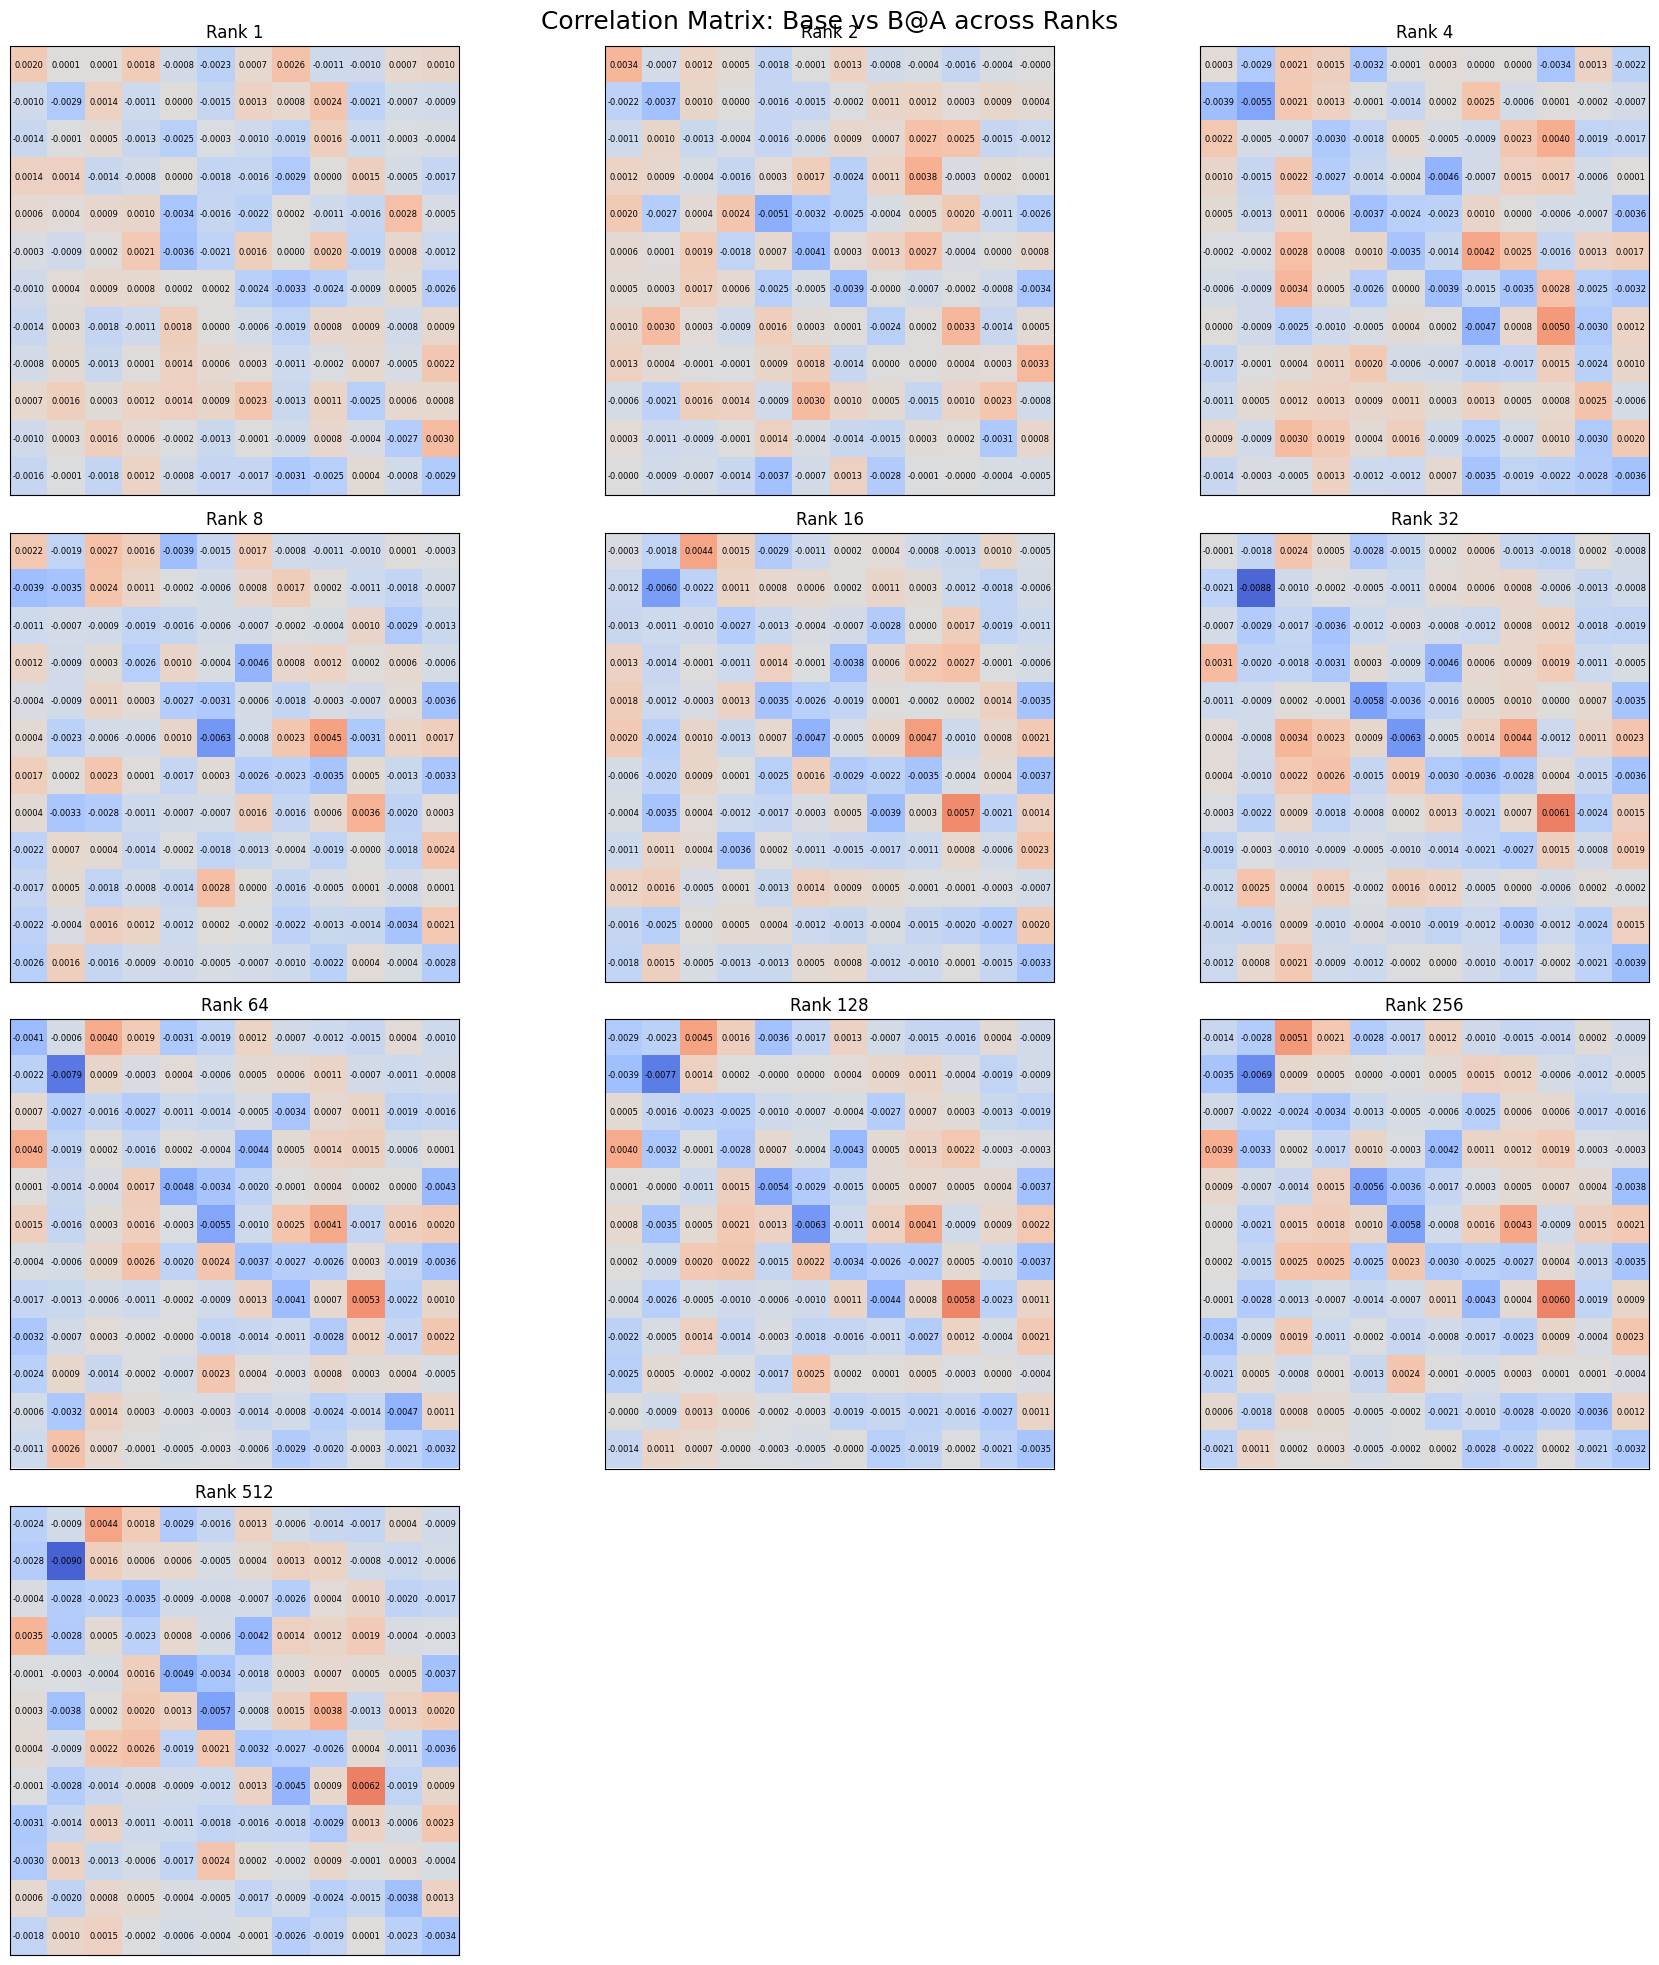

In [109]:
# Ranks to plot
rank_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
ncols = 3
nrows = int(np.ceil(len(rank_values) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for idx, rank in enumerate(rank_values):
    try:
        correlations = get_correlations(rank, "./saved_lora_weights")
        ax = axes[idx]
        cax = ax.matshow(correlations, cmap="coolwarm", vmin=-0.01, vmax=0.01)
        ax.set_title(f"Rank {rank}", fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        for i in range(12):
            for j in range(12):
                ax.text(j, i, f"{correlations[i, j]:.4f}", ha="center", va="center", fontsize=6, color="black")
    except Exception as e:
        print(f"Error at rank {rank}: {e}")
        axes[idx].set_visible(False)

# Hide unused subplots if any
for idx in range(len(rank_values), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle("Correlation Matrix: Base vs B@A across Ranks", fontsize=18)
plt.tight_layout()
plt.show()

## Attempt to do on a different DATASET

This time with the IMDB Dataset


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
import evaluate
import os

# Load the small Emotion dataset
dataset = load_dataset("emotion")
train_data = dataset["train"]
val_data = dataset["validation"]

# Initialize tokenizer for BERT base model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocessing function
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(preprocess, batched=True)
val_data = val_data.map(preprocess, batched=True)

# Evaluation metric
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

# Directory for saving LoRA weights
save_path = "./saved_lora_weights/EMOTION"
os.makedirs(save_path, exist_ok=True)

# LoRA rank values
r_values = [2 ** i for i in range(0, 9)]  # 1 to 256
results_emotion = {}

for r in r_values:
    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
    
    lora_config = LoraConfig(
        r=r,
        lora_alpha=16,
        target_modules=["query"],
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.SEQ_CLS
    )
    
    model = get_peft_model(base_model, lora_config)
    
    training_args = TrainingArguments(
        output_dir=f"./results_emotion_lora_r{r}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        evaluation_strategy="epoch",
        logging_dir=f"./logs_emotion_lora_r{r}",
        logging_steps=10,
        save_strategy="no"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    eval_result = trainer.evaluate()
    results_emotion[r] = eval_result

    # Save LoRA model weights
    model.save_pretrained(os.path.join(save_path, f"lora_rank_{r}"))

# Output results
print(results_emotion)




README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tay Han\.cache\huggingface\hub\datasets--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.811, 'grad_norm': 4.959838390350342, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7684, 'grad_norm': 9.706708908081055, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7054, 'grad_norm': 7.286405086517334, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6824, 'grad_norm': 5.5403361320495605, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7156, 'grad_norm': 6.207887172698975, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.6043, 'grad_norm': 3.935976505279541, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6862, 'grad_norm': 3.953125238418579, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5567, 'grad_norm': 5.384867191314697, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.5821, 'grad_norm': 3.624795436859131, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6289, 'grad_norm': 5.758533477783203, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6456, 'grad_norm': 3

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.2167787551879883, 'eval_accuracy': 0.5425, 'eval_runtime': 11.4506, 'eval_samples_per_second': 174.663, 'eval_steps_per_second': 21.833, 'epoch': 1.0}
{'loss': 1.3367, 'grad_norm': 11.763575553894043, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.2431, 'grad_norm': 6.983242034912109, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.3458, 'grad_norm': 13.228214263916016, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2745, 'grad_norm': 6.194521427154541, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2513, 'grad_norm': 8.194140434265137, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1969, 'grad_norm': 7.948251247406006, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.1595, 'grad_norm': 12.533746719360352, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.2898, 'grad_norm': 9.111169815063477, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.2971, 'grad_norm': 9.04813098907470

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0914827585220337, 'eval_accuracy': 0.5765, 'eval_runtime': 11.7346, 'eval_samples_per_second': 170.437, 'eval_steps_per_second': 21.305, 'epoch': 2.0}
{'loss': 1.238, 'grad_norm': 10.798946380615234, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.0425, 'grad_norm': 10.942604064941406, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.1171, 'grad_norm': 4.078036785125732, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 1.0204, 'grad_norm': 12.474665641784668, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.3319, 'grad_norm': 49.53506851196289, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9967, 'grad_norm': 6.370283126831055, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3484, 'grad_norm': 14.686939239501953, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.251, 'grad_norm': 6.660370349884033, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9779, 'grad_norm': 8.228440284729004, 'learning_rate': 2.955e-05, 'epoch': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0304259061813354, 'eval_accuracy': 0.613, 'eval_runtime': 11.4871, 'eval_samples_per_second': 174.108, 'eval_steps_per_second': 21.764, 'epoch': 3.0}
{'loss': 0.9801, 'grad_norm': 27.01114845275879, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.1042, 'grad_norm': 10.051131248474121, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 1.0417, 'grad_norm': 19.998376846313477, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.1647, 'grad_norm': 11.881534576416016, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1915, 'grad_norm': 15.602476119995117, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 1.0127, 'grad_norm': 10.813005447387695, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8675, 'grad_norm': 12.946246147155762, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.25, 'grad_norm': 9.955205917358398, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 1.0234, 'grad_norm': 1

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9919208884239197, 'eval_accuracy': 0.66, 'eval_runtime': 11.3955, 'eval_samples_per_second': 175.508, 'eval_steps_per_second': 21.938, 'epoch': 4.0}
{'loss': 1.1328, 'grad_norm': 6.766276836395264, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0983, 'grad_norm': 21.893402099609375, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0774, 'grad_norm': 14.348321914672852, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9742, 'grad_norm': 16.001846313476562, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.9063, 'grad_norm': 15.113913536071777, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.9009, 'grad_norm': 6.314342021942139, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9892, 'grad_norm': 13.039704322814941, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0982, 'grad_norm': 29.74818992614746, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.2189, 'grad_norm': 12.846961

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9793969392776489, 'eval_accuracy': 0.663, 'eval_runtime': 11.4695, 'eval_samples_per_second': 174.376, 'eval_steps_per_second': 21.797, 'epoch': 5.0}
{'train_runtime': 1067.9842, 'train_samples_per_second': 74.907, 'train_steps_per_second': 9.363, 'train_loss': 1.1679063205242157, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.887721538543701, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7126, 'grad_norm': 8.675938606262207, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7245, 'grad_norm': 6.984129905700684, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6473, 'grad_norm': 5.688600063323975, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7071, 'grad_norm': 7.030157566070557, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5968, 'grad_norm': 3.9622695446014404, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6796, 'grad_norm': 3.7427210807800293, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5272, 'grad_norm': 5.1813435554504395, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.602, 'grad_norm': 3.7327630519866943, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6368, 'grad_norm': 5.679451942443848, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6405, 'grad_norm'

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1802978515625, 'eval_accuracy': 0.5595, 'eval_runtime': 11.3996, 'eval_samples_per_second': 175.444, 'eval_steps_per_second': 21.931, 'epoch': 1.0}
{'loss': 1.3492, 'grad_norm': 8.781442642211914, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.1896, 'grad_norm': 6.5633344650268555, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.3753, 'grad_norm': 8.970892906188965, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.3357, 'grad_norm': 13.845236778259277, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2093, 'grad_norm': 7.975281715393066, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1249, 'grad_norm': 5.555514812469482, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.1925, 'grad_norm': 17.589622497558594, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.3214, 'grad_norm': 11.237595558166504, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3609, 'grad_norm': 9.654533386230469,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0846935510635376, 'eval_accuracy': 0.58, 'eval_runtime': 11.4073, 'eval_samples_per_second': 175.327, 'eval_steps_per_second': 21.916, 'epoch': 2.0}
{'loss': 1.2081, 'grad_norm': 12.946410179138184, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.0269, 'grad_norm': 9.265204429626465, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.2002, 'grad_norm': 3.765289306640625, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 1.0127, 'grad_norm': 9.162392616271973, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.301, 'grad_norm': 22.181283950805664, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9841, 'grad_norm': 5.644051551818848, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.2994, 'grad_norm': 16.59349250793457, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.1994, 'grad_norm': 7.850066184997559, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9937, 'grad_norm': 8.860931396484375, 'learning_rate': 2.955e-05, 'epoch': 2.0

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.01941978931427, 'eval_accuracy': 0.625, 'eval_runtime': 11.4569, 'eval_samples_per_second': 174.568, 'eval_steps_per_second': 21.821, 'epoch': 3.0}
{'loss': 0.9972, 'grad_norm': 12.812446594238281, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.1503, 'grad_norm': 7.554504871368408, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 1.0167, 'grad_norm': 6.28631591796875, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.1031, 'grad_norm': 6.640601634979248, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1819, 'grad_norm': 12.601092338562012, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 1.0044, 'grad_norm': 8.020108222961426, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8897, 'grad_norm': 17.308378219604492, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.2469, 'grad_norm': 7.002900123596191, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 1.0066, 'grad_norm': 11.43

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.982214093208313, 'eval_accuracy': 0.659, 'eval_runtime': 11.449, 'eval_samples_per_second': 174.687, 'eval_steps_per_second': 21.836, 'epoch': 4.0}
{'loss': 1.0652, 'grad_norm': 6.106194019317627, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0772, 'grad_norm': 13.331123352050781, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0822, 'grad_norm': 12.646866798400879, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9429, 'grad_norm': 14.379484176635742, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.8478, 'grad_norm': 14.723063468933105, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8928, 'grad_norm': 16.52505874633789, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 1.0495, 'grad_norm': 16.68488121032715, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0828, 'grad_norm': 25.856760025024414, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1814, 'grad_norm': 8.34705734

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9624398350715637, 'eval_accuracy': 0.6615, 'eval_runtime': 11.4997, 'eval_samples_per_second': 173.918, 'eval_steps_per_second': 21.74, 'epoch': 5.0}
{'train_runtime': 1036.8038, 'train_samples_per_second': 77.16, 'train_steps_per_second': 9.645, 'train_loss': 1.1533259941577911, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7868, 'grad_norm': 4.886261940002441, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7127, 'grad_norm': 8.675223350524902, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7246, 'grad_norm': 6.976339340209961, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6473, 'grad_norm': 5.682642936706543, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7074, 'grad_norm': 7.030141353607178, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5964, 'grad_norm': 3.9485037326812744, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6799, 'grad_norm': 3.7361435890197754, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5286, 'grad_norm': 5.171318531036377, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.602, 'grad_norm': 3.734593629837036, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6366, 'grad_norm': 5.653791904449463, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.64, 'grad_norm': 3.

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1842089891433716, 'eval_accuracy': 0.5505, 'eval_runtime': 11.4405, 'eval_samples_per_second': 174.817, 'eval_steps_per_second': 21.852, 'epoch': 1.0}
{'loss': 1.3806, 'grad_norm': 8.602922439575195, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.2015, 'grad_norm': 4.9349684715271, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.2826, 'grad_norm': 10.07590103149414, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2776, 'grad_norm': 7.108577251434326, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2299, 'grad_norm': 6.897769927978516, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1442, 'grad_norm': 5.1129326820373535, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.2232, 'grad_norm': 7.3186540603637695, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.3178, 'grad_norm': 8.045589447021484, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3201, 'grad_norm': 8.429377555847168, 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0460197925567627, 'eval_accuracy': 0.612, 'eval_runtime': 11.6712, 'eval_samples_per_second': 171.363, 'eval_steps_per_second': 21.42, 'epoch': 2.0}
{'loss': 1.2735, 'grad_norm': 9.933690071105957, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 0.986, 'grad_norm': 8.762869834899902, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.1089, 'grad_norm': 3.4615590572357178, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.9572, 'grad_norm': 5.591935634613037, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.2168, 'grad_norm': 9.40511703491211, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.966, 'grad_norm': 4.897767066955566, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.2933, 'grad_norm': 11.765186309814453, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.2009, 'grad_norm': 5.881893157958984, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9491, 'grad_norm': 7.061611652374268, 'learning_rate': 2.955e-05, 'epoch': 2.04}

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9731715321540833, 'eval_accuracy': 0.6695, 'eval_runtime': 11.4716, 'eval_samples_per_second': 174.344, 'eval_steps_per_second': 21.793, 'epoch': 3.0}
{'loss': 0.9084, 'grad_norm': 3.50134015083313, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.0761, 'grad_norm': 7.280062198638916, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9512, 'grad_norm': 6.058703899383545, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.0767, 'grad_norm': 6.360466957092285, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1452, 'grad_norm': 7.837217330932617, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9497, 'grad_norm': 6.794705390930176, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8383, 'grad_norm': 9.827356338500977, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.1714, 'grad_norm': 5.250778675079346, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.9686, 'grad_norm': 8.423

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9250369668006897, 'eval_accuracy': 0.68, 'eval_runtime': 11.5431, 'eval_samples_per_second': 173.264, 'eval_steps_per_second': 21.658, 'epoch': 4.0}
{'loss': 0.9255, 'grad_norm': 4.694746017456055, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0485, 'grad_norm': 11.819371223449707, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0727, 'grad_norm': 8.203703880310059, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.8834, 'grad_norm': 10.775965690612793, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.8865, 'grad_norm': 14.149736404418945, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8222, 'grad_norm': 7.7031354904174805, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9149, 'grad_norm': 9.347225189208984, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0413, 'grad_norm': 10.582661628723145, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1712, 'grad_norm': 8.0395650

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9064100384712219, 'eval_accuracy': 0.691, 'eval_runtime': 11.5448, 'eval_samples_per_second': 173.238, 'eval_steps_per_second': 21.655, 'epoch': 5.0}
{'train_runtime': 1044.2491, 'train_samples_per_second': 76.61, 'train_steps_per_second': 9.576, 'train_loss': 1.123783871936798, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.8846869468688965, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7128, 'grad_norm': 8.672438621520996, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7248, 'grad_norm': 6.972168445587158, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6475, 'grad_norm': 5.678078651428223, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7075, 'grad_norm': 7.017037868499756, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5966, 'grad_norm': 3.9438343048095703, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6801, 'grad_norm': 3.734553098678589, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5289, 'grad_norm': 5.176028728485107, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.6025, 'grad_norm': 3.728477954864502, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6365, 'grad_norm': 5.650519847869873, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6398, 'grad_norm':

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1651238203048706, 'eval_accuracy': 0.558, 'eval_runtime': 11.5468, 'eval_samples_per_second': 173.209, 'eval_steps_per_second': 21.651, 'epoch': 1.0}
{'loss': 1.3846, 'grad_norm': 5.564003944396973, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.2071, 'grad_norm': 4.155767440795898, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.3085, 'grad_norm': 8.148743629455566, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2489, 'grad_norm': 5.6800336837768555, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2229, 'grad_norm': 6.62153434753418, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1284, 'grad_norm': 4.447243690490723, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.1838, 'grad_norm': 6.636517524719238, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.284, 'grad_norm': 8.112048149108887, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3145, 'grad_norm': 6.460119247436523, 'l

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0534446239471436, 'eval_accuracy': 0.585, 'eval_runtime': 11.4933, 'eval_samples_per_second': 174.015, 'eval_steps_per_second': 21.752, 'epoch': 2.0}
{'loss': 1.2359, 'grad_norm': 7.206099987030029, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 0.9992, 'grad_norm': 9.14968204498291, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.1289, 'grad_norm': 3.505833148956299, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.973, 'grad_norm': 4.81839656829834, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.2816, 'grad_norm': 13.538962364196777, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9484, 'grad_norm': 4.808432102203369, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3226, 'grad_norm': 7.808091163635254, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.1974, 'grad_norm': 5.049373626708984, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9744, 'grad_norm': 6.328214645385742, 'learning_rate': 2.955e-05, 'epoch': 2.04}

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9920487403869629, 'eval_accuracy': 0.659, 'eval_runtime': 11.6812, 'eval_samples_per_second': 171.215, 'eval_steps_per_second': 21.402, 'epoch': 3.0}
{'loss': 0.9847, 'grad_norm': 3.2351253032684326, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.0963, 'grad_norm': 7.0747151374816895, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9428, 'grad_norm': 4.854903697967529, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.1088, 'grad_norm': 4.754313945770264, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1519, 'grad_norm': 8.002096176147461, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9534, 'grad_norm': 5.0672478675842285, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8291, 'grad_norm': 5.746997356414795, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.1886, 'grad_norm': 4.251461029052734, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.994, 'grad_norm': 7.3

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9428606033325195, 'eval_accuracy': 0.6885, 'eval_runtime': 11.4852, 'eval_samples_per_second': 174.137, 'eval_steps_per_second': 21.767, 'epoch': 4.0}
{'loss': 0.9685, 'grad_norm': 4.598361015319824, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0458, 'grad_norm': 7.642058372497559, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0838, 'grad_norm': 6.6346435546875, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9411, 'grad_norm': 9.704219818115234, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.9124, 'grad_norm': 12.581507682800293, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8629, 'grad_norm': 5.412877082824707, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9506, 'grad_norm': 7.483043193817139, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0202, 'grad_norm': 5.616154670715332, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1376, 'grad_norm': 5.39807415008

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9229012727737427, 'eval_accuracy': 0.688, 'eval_runtime': 11.5691, 'eval_samples_per_second': 172.874, 'eval_steps_per_second': 21.609, 'epoch': 5.0}
{'train_runtime': 1049.6226, 'train_samples_per_second': 76.218, 'train_steps_per_second': 9.527, 'train_loss': 1.1307861586093904, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.884973049163818, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7127, 'grad_norm': 8.674492835998535, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7246, 'grad_norm': 6.971477508544922, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6473, 'grad_norm': 5.6820573806762695, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7073, 'grad_norm': 7.0258660316467285, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5966, 'grad_norm': 3.9515109062194824, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6798, 'grad_norm': 3.732550859451294, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.528, 'grad_norm': 5.169518947601318, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.6021, 'grad_norm': 3.7271971702575684, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6365, 'grad_norm': 5.6561598777771, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6399, 'grad_norm': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1681358814239502, 'eval_accuracy': 0.558, 'eval_runtime': 11.6494, 'eval_samples_per_second': 171.682, 'eval_steps_per_second': 21.46, 'epoch': 1.0}
{'loss': 1.3833, 'grad_norm': 6.659657001495361, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.213, 'grad_norm': 4.840935230255127, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.3102, 'grad_norm': 7.229640007019043, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2766, 'grad_norm': 6.246694087982178, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2112, 'grad_norm': 6.725562572479248, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1165, 'grad_norm': 4.366860389709473, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.2033, 'grad_norm': 4.3276166915893555, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.3002, 'grad_norm': 7.4371490478515625, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3358, 'grad_norm': 6.211573600769043, '

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.048263430595398, 'eval_accuracy': 0.5865, 'eval_runtime': 11.613, 'eval_samples_per_second': 172.22, 'eval_steps_per_second': 21.528, 'epoch': 2.0}
{'loss': 1.2242, 'grad_norm': 6.769824981689453, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.0103, 'grad_norm': 7.845096588134766, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.127, 'grad_norm': 3.4391517639160156, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.9627, 'grad_norm': 4.25785493850708, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.2803, 'grad_norm': 9.54722785949707, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9687, 'grad_norm': 4.6950764656066895, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3067, 'grad_norm': 7.630066394805908, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.2046, 'grad_norm': 4.934676170349121, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9641, 'grad_norm': 5.017083644866943, 'learning_rate': 2.955e-05, 'epoch': 2.04}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9840301275253296, 'eval_accuracy': 0.66, 'eval_runtime': 11.7303, 'eval_samples_per_second': 170.499, 'eval_steps_per_second': 21.312, 'epoch': 3.0}
{'loss': 0.9683, 'grad_norm': 2.6893389225006104, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.1036, 'grad_norm': 5.3882646560668945, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9516, 'grad_norm': 4.730069160461426, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.0823, 'grad_norm': 4.4515509605407715, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.108, 'grad_norm': 6.792721271514893, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9384, 'grad_norm': 5.2485456466674805, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8365, 'grad_norm': 5.908378601074219, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.1963, 'grad_norm': 4.1177215576171875, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.9709, 'grad_norm': 6.

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9353830218315125, 'eval_accuracy': 0.686, 'eval_runtime': 11.5052, 'eval_samples_per_second': 173.835, 'eval_steps_per_second': 21.729, 'epoch': 4.0}
{'loss': 0.9582, 'grad_norm': 4.262078285217285, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0342, 'grad_norm': 5.57914400100708, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0561, 'grad_norm': 6.8788275718688965, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9134, 'grad_norm': 8.767388343811035, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.8326, 'grad_norm': 7.047133445739746, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8435, 'grad_norm': 5.202419757843018, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.954, 'grad_norm': 7.123679161071777, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0481, 'grad_norm': 5.7957763671875, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1743, 'grad_norm': 5.13713407516479

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9142889380455017, 'eval_accuracy': 0.684, 'eval_runtime': 11.7028, 'eval_samples_per_second': 170.899, 'eval_steps_per_second': 21.362, 'epoch': 5.0}
{'train_runtime': 1050.9942, 'train_samples_per_second': 76.118, 'train_steps_per_second': 9.515, 'train_loss': 1.125215532875061, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.884774684906006, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7127, 'grad_norm': 8.674695014953613, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7246, 'grad_norm': 6.97088623046875, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6474, 'grad_norm': 5.680907249450684, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7074, 'grad_norm': 7.0260009765625, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5966, 'grad_norm': 3.95052170753479, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6798, 'grad_norm': 3.733208417892456, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5282, 'grad_norm': 5.1704230308532715, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.602, 'grad_norm': 3.726436138153076, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6367, 'grad_norm': 5.6618828773498535, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6398, 'grad_norm': 3.11

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1614000797271729, 'eval_accuracy': 0.5585, 'eval_runtime': 11.7198, 'eval_samples_per_second': 170.651, 'eval_steps_per_second': 21.331, 'epoch': 1.0}
{'loss': 1.3862, 'grad_norm': 4.736963748931885, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.191, 'grad_norm': 3.9897236824035645, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.293, 'grad_norm': 7.347085952758789, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2651, 'grad_norm': 4.965753555297852, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2131, 'grad_norm': 6.780049800872803, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1136, 'grad_norm': 4.021203994750977, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.1877, 'grad_norm': 3.6043972969055176, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.2953, 'grad_norm': 7.5879292488098145, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3226, 'grad_norm': 5.950577259063721,

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.046980619430542, 'eval_accuracy': 0.5855, 'eval_runtime': 11.576, 'eval_samples_per_second': 172.771, 'eval_steps_per_second': 21.596, 'epoch': 2.0}
{'loss': 1.2435, 'grad_norm': 6.463024139404297, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.003, 'grad_norm': 8.25401782989502, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.1233, 'grad_norm': 3.3608038425445557, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.9637, 'grad_norm': 4.080196857452393, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.2519, 'grad_norm': 9.099954605102539, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9561, 'grad_norm': 4.784958839416504, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3044, 'grad_norm': 7.362279891967773, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.2058, 'grad_norm': 4.806270599365234, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9615, 'grad_norm': 4.367565155029297, 'learning_rate': 2.955e-05, 'epoch': 2.04}

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9886890649795532, 'eval_accuracy': 0.66, 'eval_runtime': 11.6132, 'eval_samples_per_second': 172.218, 'eval_steps_per_second': 21.527, 'epoch': 3.0}
{'loss': 0.9727, 'grad_norm': 2.785663604736328, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.1, 'grad_norm': 5.210541725158691, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9406, 'grad_norm': 4.684352397918701, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.1058, 'grad_norm': 4.563984394073486, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1034, 'grad_norm': 5.445916175842285, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9459, 'grad_norm': 4.637947082519531, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8457, 'grad_norm': 4.801337242126465, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.2001, 'grad_norm': 4.032584190368652, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.9774, 'grad_norm': 6.1895051

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9404229521751404, 'eval_accuracy': 0.6845, 'eval_runtime': 11.7126, 'eval_samples_per_second': 170.756, 'eval_steps_per_second': 21.344, 'epoch': 4.0}
{'loss': 0.9721, 'grad_norm': 3.4876983165740967, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0429, 'grad_norm': 5.307676792144775, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0732, 'grad_norm': 5.508184909820557, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9258, 'grad_norm': 8.693589210510254, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.871, 'grad_norm': 6.54756498336792, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8587, 'grad_norm': 4.584243297576904, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9551, 'grad_norm': 6.127035140991211, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.034, 'grad_norm': 3.809722661972046, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1553, 'grad_norm': 4.837641239166

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9211827516555786, 'eval_accuracy': 0.688, 'eval_runtime': 11.6674, 'eval_samples_per_second': 171.418, 'eval_steps_per_second': 21.427, 'epoch': 5.0}
{'train_runtime': 1054.6335, 'train_samples_per_second': 75.856, 'train_steps_per_second': 9.482, 'train_loss': 1.1275980093955993, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.884562969207764, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7127, 'grad_norm': 8.67363166809082, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7246, 'grad_norm': 6.970510959625244, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6474, 'grad_norm': 5.680832862854004, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7074, 'grad_norm': 7.025132179260254, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5966, 'grad_norm': 3.9482510089874268, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6799, 'grad_norm': 3.7328195571899414, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5282, 'grad_norm': 5.167257308959961, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.6021, 'grad_norm': 3.7302305698394775, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6366, 'grad_norm': 5.658373832702637, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.64, 'grad_norm': 3

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1591569185256958, 'eval_accuracy': 0.56, 'eval_runtime': 11.8753, 'eval_samples_per_second': 168.417, 'eval_steps_per_second': 21.052, 'epoch': 1.0}
{'loss': 1.3811, 'grad_norm': 4.568719863891602, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.1988, 'grad_norm': 3.762712001800537, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.2946, 'grad_norm': 7.05471134185791, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2695, 'grad_norm': 4.845008850097656, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2128, 'grad_norm': 6.686637878417969, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1112, 'grad_norm': 4.015951633453369, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.1847, 'grad_norm': 3.507315158843994, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.2971, 'grad_norm': 7.369004726409912, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3247, 'grad_norm': 5.885585308074951, 'le

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0473239421844482, 'eval_accuracy': 0.586, 'eval_runtime': 11.9, 'eval_samples_per_second': 168.067, 'eval_steps_per_second': 21.008, 'epoch': 2.0}
{'loss': 1.2328, 'grad_norm': 5.982975482940674, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.0052, 'grad_norm': 8.131373405456543, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.123, 'grad_norm': 3.3235976696014404, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.9653, 'grad_norm': 3.921682119369507, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.257, 'grad_norm': 6.884056568145752, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9626, 'grad_norm': 4.714059829711914, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3056, 'grad_norm': 6.735759735107422, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.2052, 'grad_norm': 4.750274658203125, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.9693, 'grad_norm': 4.081124782562256, 'learning_rate': 2.955e-05, 'epoch': 2.04}
{

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.988863468170166, 'eval_accuracy': 0.6535, 'eval_runtime': 11.9677, 'eval_samples_per_second': 167.116, 'eval_steps_per_second': 20.89, 'epoch': 3.0}
{'loss': 0.9693, 'grad_norm': 2.642111301422119, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.102, 'grad_norm': 5.142066478729248, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9447, 'grad_norm': 4.538407802581787, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.1005, 'grad_norm': 4.326111793518066, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1273, 'grad_norm': 5.0890703201293945, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9485, 'grad_norm': 4.608235836029053, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8514, 'grad_norm': 5.3521952629089355, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.1886, 'grad_norm': 4.000207424163818, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.9756, 'grad_norm': 5.995

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9415231943130493, 'eval_accuracy': 0.6835, 'eval_runtime': 11.7168, 'eval_samples_per_second': 170.694, 'eval_steps_per_second': 21.337, 'epoch': 4.0}
{'loss': 0.9793, 'grad_norm': 3.6334054470062256, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0343, 'grad_norm': 4.380364418029785, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0789, 'grad_norm': 4.425172328948975, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9253, 'grad_norm': 8.397771835327148, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.8584, 'grad_norm': 5.570143222808838, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8651, 'grad_norm': 4.130052089691162, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9599, 'grad_norm': 6.193916320800781, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0375, 'grad_norm': 3.590444803237915, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1434, 'grad_norm': 4.533854484

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9219627976417542, 'eval_accuracy': 0.6845, 'eval_runtime': 11.749, 'eval_samples_per_second': 170.227, 'eval_steps_per_second': 21.278, 'epoch': 5.0}
{'train_runtime': 1069.4469, 'train_samples_per_second': 74.805, 'train_steps_per_second': 9.351, 'train_loss': 1.1271770656585693, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.8844733238220215, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7127, 'grad_norm': 8.67540168762207, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7245, 'grad_norm': 6.971157550811768, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6473, 'grad_norm': 5.682490348815918, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7073, 'grad_norm': 7.030062198638916, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5965, 'grad_norm': 3.9529671669006348, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6798, 'grad_norm': 3.7320616245269775, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.528, 'grad_norm': 5.169507026672363, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.602, 'grad_norm': 3.729621648788452, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6365, 'grad_norm': 5.6640801429748535, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6398, 'grad_norm': 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1611241102218628, 'eval_accuracy': 0.559, 'eval_runtime': 11.8672, 'eval_samples_per_second': 168.531, 'eval_steps_per_second': 21.066, 'epoch': 1.0}
{'loss': 1.3851, 'grad_norm': 4.519158363342285, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.1939, 'grad_norm': 3.553800344467163, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.2906, 'grad_norm': 7.083253383636475, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2553, 'grad_norm': 4.645318031311035, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2171, 'grad_norm': 6.590207099914551, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.126, 'grad_norm': 3.7928390502929688, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.1904, 'grad_norm': 3.5026683807373047, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.2958, 'grad_norm': 7.222226142883301, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3199, 'grad_norm': 5.758869647979736, 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0447584390640259, 'eval_accuracy': 0.585, 'eval_runtime': 12.0057, 'eval_samples_per_second': 166.588, 'eval_steps_per_second': 20.824, 'epoch': 2.0}
{'loss': 1.2346, 'grad_norm': 5.890250205993652, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.006, 'grad_norm': 8.199333190917969, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.1178, 'grad_norm': 3.2886152267456055, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.9739, 'grad_norm': 3.9314584732055664, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.2677, 'grad_norm': 5.073807239532471, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9601, 'grad_norm': 4.615387916564941, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3093, 'grad_norm': 6.772774696350098, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.2104, 'grad_norm': 4.694896221160889, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.964, 'grad_norm': 4.006041049957275, 'learning_rate': 2.955e-05, 'epoch': 2.0

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9844720959663391, 'eval_accuracy': 0.6595, 'eval_runtime': 12.1297, 'eval_samples_per_second': 164.884, 'eval_steps_per_second': 20.611, 'epoch': 3.0}
{'loss': 0.9572, 'grad_norm': 2.718181610107422, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.1017, 'grad_norm': 5.044798374176025, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9455, 'grad_norm': 4.484762668609619, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.1022, 'grad_norm': 4.245661735534668, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1069, 'grad_norm': 4.534502029418945, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9406, 'grad_norm': 4.284566879272461, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8459, 'grad_norm': 4.511623859405518, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.1923, 'grad_norm': 3.9014170169830322, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.9714, 'grad_norm': 6.1

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9378628134727478, 'eval_accuracy': 0.687, 'eval_runtime': 12.2956, 'eval_samples_per_second': 162.66, 'eval_steps_per_second': 20.332, 'epoch': 4.0}
{'loss': 0.9722, 'grad_norm': 3.405625104904175, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0455, 'grad_norm': 4.295571804046631, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0769, 'grad_norm': 4.243882656097412, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9247, 'grad_norm': 8.41031551361084, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.8655, 'grad_norm': 5.226895809173584, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8567, 'grad_norm': 3.910947322845459, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9591, 'grad_norm': 6.125800609588623, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.041, 'grad_norm': 3.103623867034912, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1423, 'grad_norm': 4.41234302520751

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9190129637718201, 'eval_accuracy': 0.6885, 'eval_runtime': 12.0795, 'eval_samples_per_second': 165.57, 'eval_steps_per_second': 20.696, 'epoch': 5.0}
{'train_runtime': 1096.1427, 'train_samples_per_second': 72.983, 'train_steps_per_second': 9.123, 'train_loss': 1.1273658323764801, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_b

  0%|          | 0/10000 [00:00<?, ?it/s]

{'loss': 1.7867, 'grad_norm': 4.884182929992676, 'learning_rate': 4.995e-05, 'epoch': 0.01}
{'loss': 1.7127, 'grad_norm': 8.674275398254395, 'learning_rate': 4.99e-05, 'epoch': 0.01}
{'loss': 1.7246, 'grad_norm': 6.970583438873291, 'learning_rate': 4.9850000000000006e-05, 'epoch': 0.01}
{'loss': 1.6473, 'grad_norm': 5.6815505027771, 'learning_rate': 4.9800000000000004e-05, 'epoch': 0.02}
{'loss': 1.7073, 'grad_norm': 7.0261077880859375, 'learning_rate': 4.975e-05, 'epoch': 0.03}
{'loss': 1.5966, 'grad_norm': 3.9491477012634277, 'learning_rate': 4.97e-05, 'epoch': 0.03}
{'loss': 1.6799, 'grad_norm': 3.7314867973327637, 'learning_rate': 4.965e-05, 'epoch': 0.04}
{'loss': 1.5281, 'grad_norm': 5.169926166534424, 'learning_rate': 4.96e-05, 'epoch': 0.04}
{'loss': 1.6021, 'grad_norm': 3.7280116081237793, 'learning_rate': 4.9550000000000005e-05, 'epoch': 0.04}
{'loss': 1.6366, 'grad_norm': 5.6542534828186035, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.05}
{'loss': 1.6399, 'grad_norm'

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.1614177227020264, 'eval_accuracy': 0.558, 'eval_runtime': 14.1333, 'eval_samples_per_second': 141.51, 'eval_steps_per_second': 17.689, 'epoch': 1.0}
{'loss': 1.3823, 'grad_norm': 4.510401725769043, 'learning_rate': 3.995e-05, 'epoch': 1.0}
{'loss': 1.1942, 'grad_norm': 3.541355848312378, 'learning_rate': 3.99e-05, 'epoch': 1.01}
{'loss': 1.2968, 'grad_norm': 6.992240905761719, 'learning_rate': 3.9850000000000006e-05, 'epoch': 1.01}
{'loss': 1.2592, 'grad_norm': 4.577047348022461, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.02}
{'loss': 1.2183, 'grad_norm': 6.696784496307373, 'learning_rate': 3.9750000000000004e-05, 'epoch': 1.02}
{'loss': 1.1263, 'grad_norm': 3.7966697216033936, 'learning_rate': 3.97e-05, 'epoch': 1.03}
{'loss': 1.189, 'grad_norm': 3.4425466060638428, 'learning_rate': 3.965e-05, 'epoch': 1.03}
{'loss': 1.2938, 'grad_norm': 7.00634765625, 'learning_rate': 3.960000000000001e-05, 'epoch': 1.04}
{'loss': 1.3182, 'grad_norm': 5.740619659423828, 'lear

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.0464545488357544, 'eval_accuracy': 0.585, 'eval_runtime': 14.6487, 'eval_samples_per_second': 136.531, 'eval_steps_per_second': 17.066, 'epoch': 2.0}
{'loss': 1.2356, 'grad_norm': 5.955951690673828, 'learning_rate': 2.995e-05, 'epoch': 2.0}
{'loss': 1.0043, 'grad_norm': 8.089822769165039, 'learning_rate': 2.9900000000000002e-05, 'epoch': 2.01}
{'loss': 1.1195, 'grad_norm': 3.2867493629455566, 'learning_rate': 2.985e-05, 'epoch': 2.02}
{'loss': 0.9694, 'grad_norm': 3.8443193435668945, 'learning_rate': 2.98e-05, 'epoch': 2.02}
{'loss': 1.2592, 'grad_norm': 4.674667835235596, 'learning_rate': 2.975e-05, 'epoch': 2.02}
{'loss': 0.9645, 'grad_norm': 4.635293483734131, 'learning_rate': 2.97e-05, 'epoch': 2.03}
{'loss': 1.3029, 'grad_norm': 6.482234477996826, 'learning_rate': 2.965e-05, 'epoch': 2.04}
{'loss': 1.2102, 'grad_norm': 4.753835201263428, 'learning_rate': 2.96e-05, 'epoch': 2.04}
{'loss': 0.962, 'grad_norm': 3.860812187194824, 'learning_rate': 2.955e-05, 'epoch': 2.

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9850943088531494, 'eval_accuracy': 0.657, 'eval_runtime': 13.9797, 'eval_samples_per_second': 143.064, 'eval_steps_per_second': 17.883, 'epoch': 3.0}
{'loss': 0.9554, 'grad_norm': 2.732631206512451, 'learning_rate': 1.995e-05, 'epoch': 3.0}
{'loss': 1.0985, 'grad_norm': 5.006836414337158, 'learning_rate': 1.9900000000000003e-05, 'epoch': 3.01}
{'loss': 0.9394, 'grad_norm': 4.493026256561279, 'learning_rate': 1.985e-05, 'epoch': 3.02}
{'loss': 1.106, 'grad_norm': 4.287628650665283, 'learning_rate': 1.9800000000000004e-05, 'epoch': 3.02}
{'loss': 1.1172, 'grad_norm': 4.402431964874268, 'learning_rate': 1.9750000000000002e-05, 'epoch': 3.02}
{'loss': 0.9497, 'grad_norm': 4.4253106117248535, 'learning_rate': 1.97e-05, 'epoch': 3.03}
{'loss': 0.8503, 'grad_norm': 5.0184550285339355, 'learning_rate': 1.9650000000000003e-05, 'epoch': 3.04}
{'loss': 1.184, 'grad_norm': 3.938412666320801, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}
{'loss': 0.9726, 'grad_norm': 5.959

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9387773275375366, 'eval_accuracy': 0.681, 'eval_runtime': 13.3329, 'eval_samples_per_second': 150.005, 'eval_steps_per_second': 18.751, 'epoch': 4.0}
{'loss': 0.9866, 'grad_norm': 3.4894068241119385, 'learning_rate': 9.950000000000001e-06, 'epoch': 4.0}
{'loss': 1.0392, 'grad_norm': 4.185521602630615, 'learning_rate': 9.900000000000002e-06, 'epoch': 4.01}
{'loss': 1.0779, 'grad_norm': 4.143816947937012, 'learning_rate': 9.85e-06, 'epoch': 4.01}
{'loss': 0.9273, 'grad_norm': 8.259878158569336, 'learning_rate': 9.800000000000001e-06, 'epoch': 4.02}
{'loss': 0.8658, 'grad_norm': 4.962246894836426, 'learning_rate': 9.750000000000002e-06, 'epoch': 4.03}
{'loss': 0.8582, 'grad_norm': 3.812645196914673, 'learning_rate': 9.7e-06, 'epoch': 4.03}
{'loss': 0.9568, 'grad_norm': 6.004656791687012, 'learning_rate': 9.65e-06, 'epoch': 4.04}
{'loss': 1.0397, 'grad_norm': 2.8971803188323975, 'learning_rate': 9.600000000000001e-06, 'epoch': 4.04}
{'loss': 1.1439, 'grad_norm': 4.324636459

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.9201763868331909, 'eval_accuracy': 0.691, 'eval_runtime': 12.5362, 'eval_samples_per_second': 159.538, 'eval_steps_per_second': 19.942, 'epoch': 5.0}
{'train_runtime': 1240.4509, 'train_samples_per_second': 64.493, 'train_steps_per_second': 8.062, 'train_loss': 1.1272761802196503, 'epoch': 5.0}


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{1: {'eval_loss': 0.9793969392776489, 'eval_accuracy': 0.663, 'eval_runtime': 11.4027, 'eval_samples_per_second': 175.398, 'eval_steps_per_second': 21.925, 'epoch': 5.0}, 2: {'eval_loss': 0.9624398350715637, 'eval_accuracy': 0.6615, 'eval_runtime': 11.5367, 'eval_samples_per_second': 173.36, 'eval_steps_per_second': 21.67, 'epoch': 5.0}, 4: {'eval_loss': 0.9064100384712219, 'eval_accuracy': 0.691, 'eval_runtime': 11.523, 'eval_samples_per_second': 173.566, 'eval_steps_per_second': 21.696, 'epoch': 5.0}, 8: {'eval_loss': 0.9229012727737427, 'eval_accuracy': 0.688, 'eval_runtime': 11.5452, 'eval_samples_per_second': 173.232, 'eval_steps_per_second': 21.654, 'epoch': 5.0}, 16: {'eval_loss': 0.9142889380455017, 'eval_accuracy': 0.684, 'eval_runtime': 11.6842, 'eval_samples_per_second': 171.171, 'eval_steps_per_second': 21.396, 'epoch': 5.0}, 32: {'eval_loss': 0.9211827516555786, 'eval_accuracy': 0.688, 'eval_runtime': 11.6122, 'eval_samples_per_second': 172.233, 'eval_steps_per_second': 21

In [86]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from peft import PeftModel

def get_correlations(rank_to_load, lora_dir):
    num_layers = 12
    alpha = 16
    correlations = np.zeros((num_layers, num_layers))

    # Load LoRA model
    model_path = os.path.join(lora_dir, f"lora_rank_{rank_to_load}")
    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
    lora_model = PeftModel.from_pretrained(base_model, model_path)
    state_dict = lora_model.base_model.model.state_dict()
    # print(lora_model)
    # Calculate correlations
    for i in range(num_layers):
        base_w = state_dict[f"bert.encoder.layer.{i}.attention.self.query.base_layer.weight"].flatten().cpu().numpy()
        for j in range(num_layers):
            A = state_dict[f"bert.encoder.layer.{j}.attention.self.query.lora_A.default.weight"].cpu().numpy()
            B = state_dict[f"bert.encoder.layer.{j}.attention.self.query.lora_B.default.weight"].cpu().numpy()
            BA = (B @ A * (alpha / A.shape[0])).flatten()
            correlations[i, j] = np.corrcoef(base_w, BA)[0, 1]
    return correlations

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequen

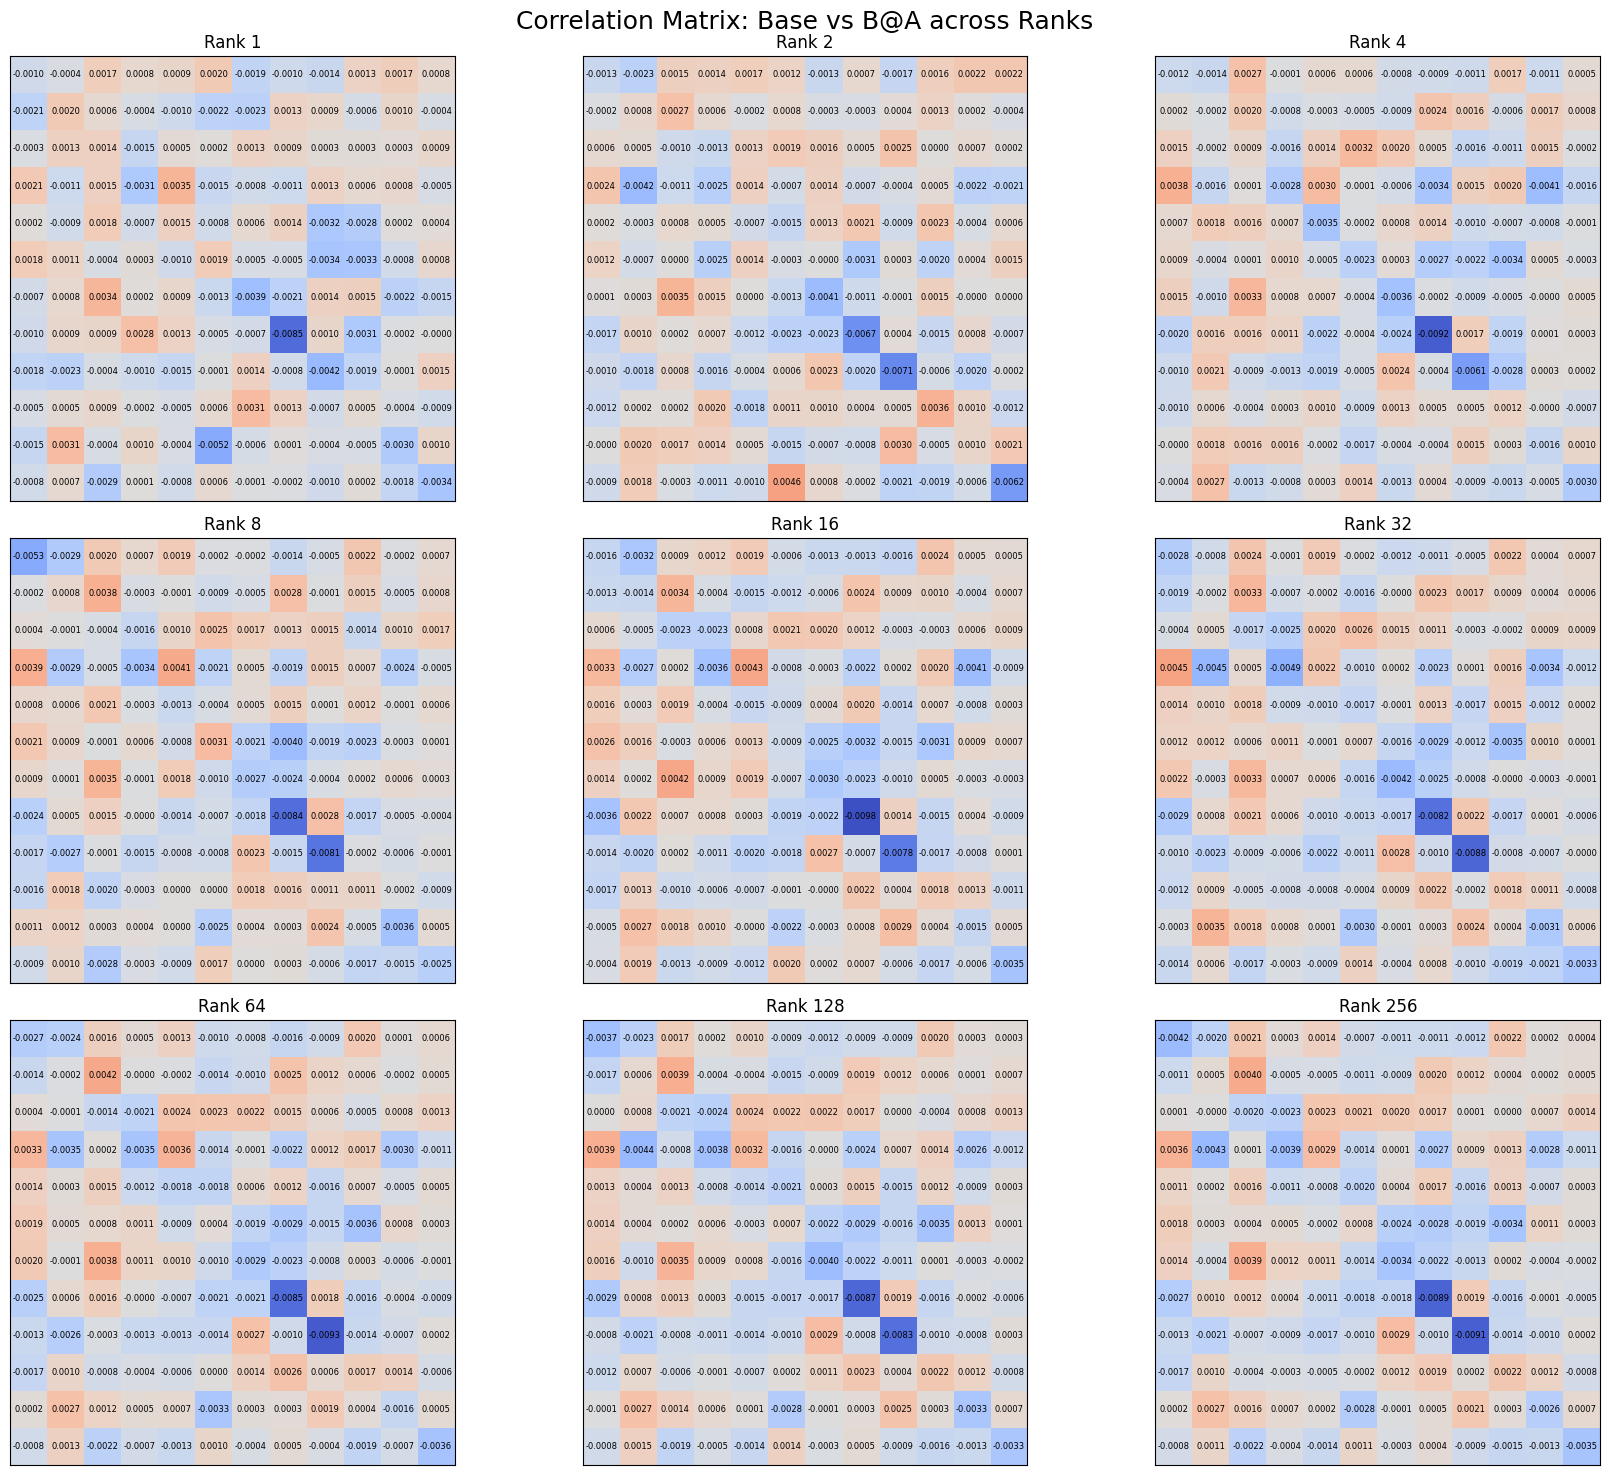

In [88]:
# Ranks to plot
rank_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
ncols = 3
nrows = int(np.ceil(len(rank_values) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for idx, rank in enumerate(rank_values):
    try:
        correlations = get_correlations(rank, "./saved_lora_weights/EMOTION")
        ax = axes[idx]
        cax = ax.matshow(correlations, cmap="coolwarm", vmin=-0.01, vmax=0.01)
        ax.set_title(f"Rank {rank}", fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        for i in range(12):
            for j in range(12):
                ax.text(j, i, f"{correlations[i, j]:.4f}", ha="center", va="center", fontsize=6, color="black")
    except Exception as e:
        print(f"Error at rank {rank}: {e}")
        axes[idx].set_visible(False)

# Hide unused subplots if any
for idx in range(len(rank_values), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle("Correlation Matrix: Base vs B@A across Ranks", fontsize=18)
plt.tight_layout()
plt.show()

### Results
Surprisingly, correlations amongst the augmented weight matrix and the original weight matrices are not strong. Upon further research, it seems as though there are severe changes in the directionality of the weight matrix. But this is concerning as we are no longer able to utilise the original weight matrix to offer clues to the formation of the augmented weight matrix.

Understandably, there are papers talking about the utilisation of low singular values in affecting the fine tuning process a bunch. "Small Singular Values Matter: A Random Matrix Analysis of Transformer
Models". The idea is that there is significant value in taking note of low singular values to provide directionality guidance in the fine tuning process.

## Understanding ELORA
Dynamic Changing of the intrinsic rank of the LORA >> neweest paper >> seeks to dynamically adapt the rank of the system

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
from transformers import DistilBertModel

class DynamicLoRA(nn.Module):
    def __init__(self, in_features, out_features, initial_rank=4, alpha=16):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = initial_rank
        self.alpha = alpha
        self.P = nn.Parameter(torch.randn(out_features, self.rank) * 0.01)
        self.Q = nn.Parameter(torch.randn(self.rank, in_features) * 0.01)
        self.scale = self.alpha / self.rank
        self.importance_scores = None

    def forward(self, x):
        delta_W = self.scale * (self.P @ self.Q)
        return x @ delta_W.T

    def update_importance_scores(self, loss):
        grads = grad(loss, [self.P, self.Q], retain_graph=True, create_graph=False)
        P_grad, Q_grad = grads
        score_P = torch.sum(torch.abs(self.P * P_grad), dim=0)
        score_Q = torch.sum(torch.abs(self.Q * Q_grad), dim=1)
        self.importance_scores = score_P + score_Q

    def prune_and_expand(self, k=1):
        if self.importance_scores is None or self.rank <= k:
            return
        _, prune_idx = torch.topk(self.importance_scores, k, largest=False)
        keep_idx = [i for i in range(self.rank) if i not in prune_idx.tolist()]
        P_new = self.P.data[:, keep_idx]
        Q_new = self.Q.data[keep_idx, :]
        P_expand = torch.randn(self.out_features, k) * 0.01
        Q_expand = torch.randn(k, self.in_features) * 0.01
        self.P = nn.Parameter(torch.cat([P_new, P_expand], dim=1))
        self.Q = nn.Parameter(torch.cat([Q_new, Q_expand], dim=0))
        self.rank = self.P.shape[1]
        self.scale = self.alpha / self.rank
        self.importance_scores = None

class LoRAInjectedLinear(nn.Module):
    def __init__(self, original_linear, r=4, alpha=16):
        super().__init__()
        self.original = original_linear
        self.lora = DynamicLoRA(
            in_features=original_linear.in_features,
            out_features=original_linear.out_features,
            initial_rank=r,
            alpha=alpha
        )

    def forward(self, x):
        return self.original(x) + self.lora(x)

    def update_importance_scores(self, loss):
        self.lora.update_importance_scores(loss)

    def prune_and_expand(self, k=1):
        self.lora.prune_and_expand(k)

def inject_dynamic_lora(model, r=4, alpha=16, target_modules=["q_lin", "v_lin"]):
    for name, module in model.named_modules():
        if any(tm in name for tm in target_modules):
            parent = dict(model.named_modules())[name.rsplit(".", 1)[0]]
            attr_name = name.rsplit(".", 1)[-1]
            original = getattr(parent, attr_name)
            setattr(parent, attr_name, LoRAInjectedLinear(original, r=r, alpha=alpha))

def adjust_lora_ranks(model, loss, every_n_steps=100, k=1, step=0):
    if step % every_n_steps != 0:
        return
    for module in model.modules():
        if isinstance(module, LoRAInjectedLinear):
            module.update_importance_scores(loss)
            module.prune_and_expand(k=k)

# Example usage
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
inject_dynamic_lora(model)


In [102]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
df

,col1,col2
0,1,3
1,2,4


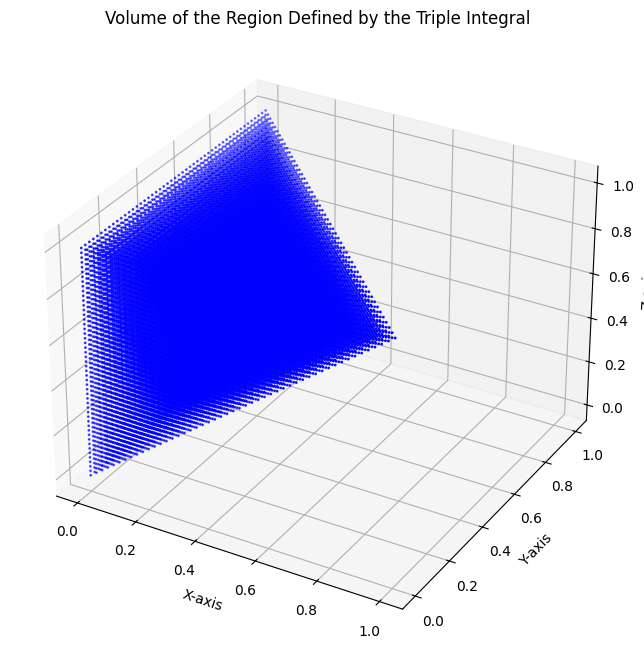

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a mesh grid for x, y, and z
z_vals = np.linspace(0, 1, 50)
x_vals = np.linspace(0, 1, 50)
y_vals = np.linspace(0, 1, 50)

# Initialize the mesh grid
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)

# Apply the condition for the volume: x <= z and y <= 1 - x
volume_mask = (X <= Z) & (Y <= (1 - X))

# Create a 3D plot to visualize the volume
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the volume, where the mask is True
ax.scatter(X[volume_mask], Y[volume_mask], Z[volume_mask], color='b', s=1)

# Set labels for axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set title
ax.set_title('Volume of the Region Defined by the Triple Integral')

plt.show()
